# Neural Collapse and Data Distillatioin

This notebook implements data distillation with neural collapse by only one step. The main papers considered here are https://github.com/SsnL/dataset-distillation and https://github.com/tding1/Neural-Collapse. The neural network is firstly trained to its terminal phase and then the distilled data are introduced by the decoder. Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/
    !git clone https://github.com/SzYang721/DD-NC.git
    %cd /content/drive/My Drive/DD-NC
    !git config --global user.email "yangsongze2008@gmail.com"
    !git config --global user.name "SzYang721"
    sys.path.append('/content/drive/My Drive/DD-NC/')
    sys.path.append('/content/drive/My Drive/model_weights/')
    print("Environment setup complete.")

In [2]:
# !pip install --upgrade wandb
import wandb
wandb.login()

wandb: Currently logged in as: yangsongze2008 (data-distillation-with-nc). Use `wandb login --relogin` to force relogin


True

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy
import scipy.linalg as scilin
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchsummary import summary

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [4]:
import models
from models import resnet_decode
from models import resnet_decode_light
from models.res_adapt import ResNet18_adapt
from utils import *

from train_Encoder import train
from validate_NC import *

from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *

# Control Board

In [5]:
TUNE_ENCODER  = False
TRAIN_ENCODER = False
EVALUATE_ENCODER = False

LOAD_ENCODER_STATE_DICT = True
ENCODER_STATE_DICT_NUMBER = 199

FREEZE_ENCODER = True

LOAD_DECODER_STATE_DICT = True
DECODER_STATE_DICT_NUMBER = 79

TUNE_AE  = False
TRAIN_AE = True

# Load Parameters

In [6]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=0
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=512
use_cudnn=True

# learning options
epochs = 200
batch_size = 256
loss = 'CrossEntropy'

# optimization
lr=0.05
patience = 40
history_size=10
optimizer = "SGD"
decay_type = "step"

# dataset
dataset='cifar10'
classes_to_include = [3,4,5]
data_dir='~/data'
normalize = False
uid= encoder+"-design(high)-"+optimizer+"-unnormalize_3class_data"
force=True
sample_size = None

## Check the best device on machine
check = False

Determine the best device to run on: CUDA, MPS (Apple Silicon GPU), or CPU

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(gpu_id)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

# device = torch.device("cpu")
# device_name = "CPU"

Using device: cuda:1, NVIDIA TITAN V


In [8]:
args_encoder = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
                  device = device,classes_to_include = classes_to_include)

override this uidresnet18-design(high)-SGD-unnormalize_3class_data
cudnn is used


# Load Dataset

In [9]:
set_seed(manualSeed = args_encoder.seed)
if TRAIN_ENCODER and SOTA == True:
    print("Loaded the SOTA Dataset")
    trainloader, testloader, num_classes = make_dataset(dataset, 
                                               data_dir, 
                                               batch_size, sample_size = sample_size,
                                               SOTA=SOTA,normalize = normalize,classes_to_include = classes_to_include)
else: 
    print("SOTA: ", SOTA)
    trainloader, testloader, num_classes = make_dataset(dataset, 
                                                        data_dir, 
                                                        batch_size, sample_size = sample_size,
                                                        normalize = normalize, classes_to_include = classes_to_include)
    
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class is ", num_classes)
print("Total number of data %d in train, %d in test"% (len(trainloader.dataset),len(testloader.dataset)))
print("Batch size: %d | Input size: %s" % (size_train,input_size))
print("The dataset ranges: (%d, %d)" % (torch.min(images), torch.max(images)))
args_encoder.num_classes = num_classes

SOTA:  False
Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class is  3
Total number of data 15000 in train, 3000 in test
Batch size: 256 | Input size: (32, 32, 3)
The dataset ranges: (0, 1)


# Load Model

In [10]:
if args_encoder.model == "MLP":
    Encoder = models.__dict__[args.model](hidden = args_encoder.width, depth = args_encoder.depth, fc_bias=args_encoder.bias, num_classes=num_classes).to(args_encoder.device)
elif args_encoder.model == "ResNet18_adapt":
    Encoder = ResNet18_adapt(width = args_encoder.width, num_classes=num_classes, fc_bias=args_encoder.bias).to(args_encoder.device)
else:
    Encoder = models.__dict__[args_encoder.model](num_classes=num_classes, fc_bias=args_encoder.bias, ETF_fc=args_encoder.ETF_fc, fixdim=args_encoder.fixdim, SOTA=args_encoder.SOTA).to(args_encoder.device)

print('# of model parameters: ' + str(count_network_parameters(Encoder)))
print(type(Encoder))

# of model parameters: 11176515
<class 'models.resnet.ResNet'>


In [11]:
summary(Encoder.to("cpu"), input_size=(3, 32, 32), device = "cpu")
Encoder.to(args_encoder.device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Create experiments on weights&biases

## Hyperparameter tuning

In [12]:
if TUNE_ENCODER:
    # Set up a sweep configuration
    sweep_configuration = {
        "method": "bayes",
        "name": "sweep",
        "metric": {"goal": "minimize", "name": "losses.avg"},
        "parameters": {
            "batch_size": {"values": [64, 128, 256]},
            "lr": {"max": 0.1, "min": 0.0001},
        },
    }
    # Get sweep ID
    sweep_id = wandb.sweep(sweep_configuration, project="DDNC_hyper")
    def hypertuning_train(config = None, args = args_encoder):
        # Initial a new run
        run = wandb.init(project="DDNC_hyper", config = config, settings=wandb.Settings(start_method="thread"))
        print("Initialise finished, starting now...")
        args.lr = wandb.config.lr
        args.batch_size = wandb.config.batch_size
        train(args_encoder,Encoder,trainloader)
    # hypertuning_train(config = sweep_configuration, args = args)
    # Start sweep
    wandb.agent(sweep_id, function=hypertuning_train, count=10)

## Model Training

In [13]:
if TRAIN_ENCODER or EVALUATE_ENCODER:
    config = {
        # architecture params
        "model":encoder,
        "bias": bias,
        "ETF_fc":ETF_fc,
        "fixdim":fixdim,
        "SOTA":SOTA,
        
        # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
        "width":width,
        "depth":depth,
        
        # hardware settings
        "gpu_id":gpu_id,
        "seed":seed,
        "use_cudnn":use_cudnn,
        
        # dataset
        "dataset":dataset,
        "data_dir":data_dir,
        "uid":uid,
        "force":force,
        
        # learning options
        "epochs": epochs,
        "batch_size":batch_size,
        "loss": loss,
        "sample_size": sample_size,
        
        # optimization
        "lr":lr,
        "optimizer":optimizer,
        "decay type": decay_type,
        "device" :device
    }
    
    run = wandb.init(
        project="DD&NC",
        notes="Resnet18 with SOTA",
        tags=["Epochs: 200","Resnet18","SGD","cifar10","SOTA"],
        config= config
    )

In [14]:
if TRAIN_ENCODER:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    train(args_encoder,Encoder,trainloader)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

## Model Evaluating

In [15]:
if EVALUATE_ENCODER:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+args_encoder.uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/model_weights/'+args_encoder.uid+"/"
    else:
        load_path = "./model_weights/"+args.args_encoder+"/"
    
    evaluate_NC(args_encoder,load_path,Encoder,trainloader,testloader,nearest_neighbor=True)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [16]:
if TRAIN_ENCODER or EVALUATE_ENCODER:
    wandb.finish()

# Validation of Neural Collapse

Neural collapse, emerged in the terminal phase of training(TPT), let us understand the behavior of a special class of neural network, deep classifier neural network. It has widely observed in a number of data set and model structures. Is has mainly 4 fold of meaning:

- **(NC1)** Cross-example within-class variability of last-layer training activations collapses to zero, as the individual activations themselves collapse to their class means. 

- **(NC2)** The class means collapse to the vertices of a simplex equiangular tight frame (ETF). 

- **(NC3)** Up to rescaling, the last-layer classifiers collapse to the class means or in other words, to the simplex ETF (i.e., to a self-dual configuration). 

- **(NC4)** For a given activation, the classifier’s decision collapses to simply choosing whichever class has the closest train class mean (i.e., the nearest class center decision rule).

Let's denote the last linear layer as, which is also known as unconstrained feature model:

$$
h = \phi_\theta(x) \in R^{d \times n}
$$

The output of the neural network as:

$$
\Phi_\Theta(x) = W_Lh+b_L
$$

Denote $N = nk, H = [h_{1,1},..., h_{k,n}] \in R^{d \times N}$, so that the last layer can be written as $R^d \rightarrow R^k$. Also, let's denote the within-class and between-class covariance matrices as $\Sigma_W$ and $\Sigma_B$.

In general, neural collapse can be written in summary as:

$$
\Sigma_W \rightarrow 0, \\
H \rightarrow \bar{H} \rightarrow ETF, W \rightarrow \bar{H}
$$

We can measure the NC in 4 metrics:

$$
NC_1:=\frac{1}{K}trace(\Sigma_W\Sigma_B^{+})\\
NC_2:= ||\frac{WW^T}{||WW^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_3:= ||\frac{W\bar{H}^T}{||W\bar{H}^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_4:=||b+Wh_G||_2
$$

The $NC_4$ follows the simplified rule: $Wh_{k,i}+b = W(h_{k,i} - h_G) + Wh_G +b$, and $Wh_G +b$ should be 0 in the TPT.

## Find the ETF center

Let's introduce the global mean and class mean of the last-layer features ${h_{k,i}}$ as:

$$
h_G = \frac{1}{nK}\sum^{K}_{k=1}\sum^{n}_{i=1}h_{k,i}, \ \bar{h_k} = \frac{1}{n}\sum_{i=1}^{n}h_{k,i}(1\leq k \leq K)
$$

The ETF center of the last layer features, or the centered class-mean matrix,: $\bar{H} = [\bar{h_{1}} - h_G,..., \bar{h_{K}} - h_G]$. 


## Visualization of K-ETF

A (K-Simplex ETF) is a collection of points in $R^K$ specified by the columns of:

$$
M = \sqrt\frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

where $I_K \in R^{K \times K}$ is the identity matrix, and 1K ∈ RK is the all ones vector. In the other words, we also have

$$
M^TM = MM^T =\frac{K}{K − 1}(I_K −\frac{1}{K}1_K1_K^T)
$$

However, the learned features of neural network is often up to some scaling and rotation, thus we consider the general ETF as a collection of points in $R^d$ specified by the columns of $\sqrt\frac{K}{K-1} P (I_K −\frac{1}{K}1_K1_K^T)$, where $P \in R{d \times K} (d \leq K)$ is a orthonormal matrix, i.e., $P^TP = I_K$.

### Further Explaination

The neural collapse shows that as training proceeds, last-layer features $H$ collapse onto their class means ($NC1$), class means converge to the vertices of the simplex ETF ($NC2$), and the linear classifiers $W$ approach their corresponding class means ($NC3$). 

In the collapse stage, the $NC2$ says that the class-means centered at their global means form a Simplex Equiangular Tight Frame - or Simplex ETF. More specifically, the weigths matrix $W^{*T} \in R^{d \times d}$ with $U^TU = I_d$, the normalised matrix $M:=\frac{1}{w^*}UW^{*T}$

$$
M^TM = \frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

Depending on whether to fix the output dimension, we will get shapeful $W \in R^{k \times d}$ and $H \in R^{d \times N}$. The dimension of bias in the last linear layer is always fixed at $b \in R^{k \times N}$. Define $N=nk$ and k is the number of classes and n is the number of images (input data) in each class.

If we fixed the $W$, it is easy to show that the class means will converge to a standard K-ETF.

In [17]:
def k_etf(K=10):
    constant = torch.sqrt(torch.tensor(K/(K-1)))
    ETF = (torch.eye(K)-(1/K)*torch.ones((K, K)))
    return constant*ETF

def k_etf_normalize(etf):
    K = etf.shape[1]
    norm = torch.sqrt((1/K*torch.norm(etf, 'fro')**2))
    return etf/norm

def k_etf_colunm_norm(etf):
    return torch.sqrt(torch.sum(torch.square(etf), axis=0))

In [18]:
print(k_etf(K=10))

print(k_etf_colunm_norm(k_etf_normalize(k_etf(K=10))))

tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
          0.9487, -0.1054],
        [-0.1054, -

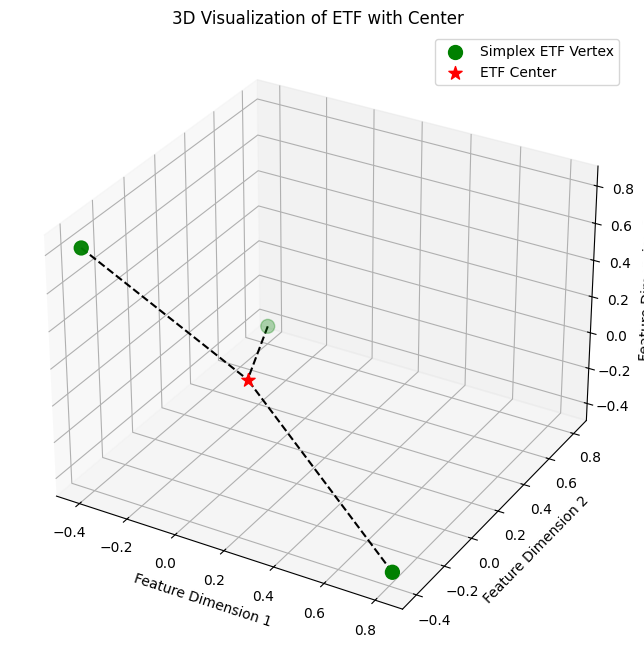

In [19]:
# Step 1: Generate the ETF matrix (as a PyTorch tensor)
simplex_vertices = k_etf(3)

# Step 2: Calculate the ETF center with PyTorch
etf_center = torch.mean(simplex_vertices, dim=0)

# Step 3: Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert PyTorch tensors to numpy arrays for plotting
simplex_vertices_np = simplex_vertices.numpy()
etf_center_np = etf_center.numpy()

# Plotting simplex ETF vertices
ax.scatter(simplex_vertices_np[:, 0], simplex_vertices_np[:, 1], simplex_vertices_np[:, 2], color='green', s=100, marker='o', label='Simplex ETF Vertex')

# Plotting the ETF center
ax.scatter(etf_center_np[0], etf_center_np[1], etf_center_np[2], color='red', s=100, marker='*', label='ETF Center')

# Drawing lines from each vertex to the ETF center
for vertex in simplex_vertices_np:
    ax.plot([vertex[0], etf_center_np[0]], [vertex[1], etf_center_np[1]], [vertex[2], etf_center_np[2]], 'k--')

# Labels and legend
ax.set_xlabel('Feature Dimension 1')
ax.set_ylabel('Feature Dimension 2')
ax.set_zlabel('Feature Dimension 3')
plt.title('3D Visualization of ETF with Center')
ax.legend()

plt.show()

## Analysis of Features

The improved neural network design shows us that we can fix the weight matrix $W$ as standard K-ETF and set the feature dimension $d$ equal to $k$, the number of class. We can plot this ETF and see if it matches.

In [20]:
if LOAD_ENCODER_STATE_DICT:
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+args_encoder.uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/songze/model_weights/'+args_encoder.uid+"/"
    else:
        load_path = "./model_weights/"+args_encoder.uid+"/"

    fc_features = FCFeatures()
    Encoder.fc.register_forward_pre_hook(fc_features)
    
    Encoder = Encoder.to(device)
    
    print('--------------------- Evaluating -------------------------------')
    
    ### investigate a specific epochs
    i = ENCODER_STATE_DICT_NUMBER
    ###
    
    map_location=torch.device(args_encoder.device)
    if LOAD_ENCODER_STATE_DICT:
        Encoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))
    
    Encoder.eval()
    
    for n, p in Encoder.named_parameters():
        if 'fc.weight' in n:
            W = p
        if 'fc.bias' in n:
            b = p
            
    W = W.to(device)
    b = b.to(device)
    
    print("W is", W)
    print("The shape of our weigths in this epochs is ", W.shape)

--------------------- Evaluating -------------------------------
W is Parameter containing:
tensor([[ 0.8165, -0.4082, -0.4082,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4082,  0.8165, -0.4082,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4082, -0.4082,  0.8165,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:1')
The shape of our weigths in this epochs is  torch.Size([3, 512])


In [21]:
if LOAD_ENCODER_STATE_DICT:
    mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args_encoder, Encoder, fc_features, trainloader, isTrain=True)
    mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args_encoder, Encoder, fc_features, testloader, isTrain=False)
    print('[epoch: %d] | train top1: %.4f | train top%d: %.4f | test top1: %.4f | test top%d: %.4f ' %
          (i + 1, train_acc1, int(args_encoder.num_classes/2), train_acc5, 
           test_acc1, int(args_encoder.num_classes/2), test_acc5))
    
    _, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
    
    print("H is", H)
    print("H is", k_etf_normalize(H))
    print("The colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H))
    print("The colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H)))

[epoch: 200] | train top1: 100.0000 | train top1: 100.0000 | test top1: 72.2000 | test top1: 72.2000 
H is tensor([[ 4.3857, -2.2111, -2.1747],
        [-2.4915,  4.9857, -2.4941],
        [-2.2558, -2.2821,  4.5379],
        ...,
        [-0.2532,  0.3787, -0.1255],
        [-0.0623,  0.3447, -0.2824],
        [-0.0741,  0.0655,  0.0086]], device='cuda:1')
H is tensor([[ 0.4794, -0.2417, -0.2377],
        [-0.2723,  0.5449, -0.2726],
        [-0.2466, -0.2494,  0.4960],
        ...,
        [-0.0277,  0.0414, -0.0137],
        [-0.0068,  0.0377, -0.0309],
        [-0.0081,  0.0072,  0.0009]], device='cuda:1')
The colmun norm of unnormalised centered features is  tensor([8.6589, 9.7175, 9.0392], device='cuda:1')
The colmun norm of normalised centered features is  tensor([0.9464, 1.0621, 0.9880], device='cuda:1')


In [22]:
if LOAD_ENCODER_STATE_DICT:
    _, H_test = compute_W_H_relation(W, mu_c_dict_test, mu_G_test)
    print(H_test)
    print(k_etf_normalize(H_test))
    print("The colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H_test))
    print("The colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H_test)))

tensor([[ 1.8884, -1.2951, -0.5933],
        [-1.5820,  3.3795, -1.7974],
        [-0.6659, -1.6199,  2.2858],
        ...,
        [-0.1431,  0.1994, -0.0563],
        [-0.0906,  0.2485, -0.1579],
        [ 0.0208, -0.0423,  0.0215]], device='cuda:1')
tensor([[ 0.3514, -0.2410, -0.1104],
        [-0.2944,  0.6289, -0.3345],
        [-0.1239, -0.3015,  0.4254],
        ...,
        [-0.0266,  0.0371, -0.0105],
        [-0.0169,  0.0463, -0.0294],
        [ 0.0039, -0.0079,  0.0040]], device='cuda:1')
The colmun norm of unnormalised centered features is  tensor([4.1332, 6.6647, 5.0118], device='cuda:1')
The colmun norm of normalised centered features is  tensor([0.7692, 1.2403, 0.9327], device='cuda:1')


## Visualize misclassified images

In [23]:
# Display the misclassified images
images, labels, preds = find_misclassified_images(Encoder, trainloader)
import math

num_images = len(images)
rows = math.ceil(num_images / 5)
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
for i in range(num_images):
    plt.subplot(rows, 10, i + 1)
    plt.imshow(images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
    plt.title(f'True: {labels[i]}\nPred: {preds[i]}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

# Data Distillation by Autoencoder

In [24]:
# architecture params
decoder='resnet18_decoder'

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# learning options
epochs=80
loss='MSE'

# optimization (change for autoencoder)
lr=0.0005
patience=80
history_size=10
optimizer="SGD"
decay_type="step"

# dataset
uid=decoder+"-design(high)-"+optimizer+"-unnormalize_3class_data-late-from80"
force=True

## Check the best device on machine
check=False

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(gpu_id)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

# device = torch.device("cpu")
# device_name = "CPU"

Using device: cuda:1, NVIDIA TITAN V


In [26]:
args_decoder = train_args(model=decoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
                  device = device)

override this uidresnet18_decoder-design(high)-SGD-unnormalize_3class_data-late-from80
cudnn is used


In [27]:
if args_decoder.model == "MLP":
    Decoder = models.__dict__[args_decoder.model](hidden = width, depth = depth, fc_bias=bias, num_classes=num_classes).to(args_decoder.device)
elif args_decoder.model == "ResNet18_adapt":
    Decoder = ResNet18_adapt(width = args_decoder.width, num_classes=num_classes, fc_bias=bias).to(args_decoder.device)
elif args_decoder.model.find('light') >= 0:
    Decoder = resnet_decode_light.__dict__[args_decoder.model](num_classes=num_classes, fixdim=fixdim, SOTA=SOTA).to(args_decoder.device)
else:
    Decoder = resnet_decode.__dict__[args_decoder.model](num_classes=num_classes, fixdim=fixdim, SOTA=SOTA).to(args_decoder.device)

print(type(Decoder))

<class 'models.resnet_decode.ResNet_decoder'>


In [28]:
summary(Decoder.to("cpu"), input_size=(512, 1, 1), device = "cpu")
Decoder.to(args_encoder.device)
if LOAD_DECODER_STATE_DICT:
    Target_uid = decoder+"-design(high)-"+optimizer+"-unnormalize_3class_data-late"
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+Target_uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/songze/model_weights/'+Target_uid+"/"
    else:
        load_path = "./model_weights/"+Target_uid+"/"
    i = DECODER_STATE_DICT_NUMBER
    Decoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 1, 1]         262,144
   ConvTranspose2d-2            [-1, 512, 1, 1]       2,359,296
       BatchNorm2d-3            [-1, 512, 1, 1]           1,024
              ReLU-4            [-1, 512, 1, 1]               0
   ConvTranspose2d-5            [-1, 512, 1, 1]       2,359,296
       BatchNorm2d-6            [-1, 512, 1, 1]           1,024
              ReLU-7            [-1, 512, 1, 1]               0
        BasicBlock-8            [-1, 512, 1, 1]               0
   ConvTranspose2d-9            [-1, 512, 1, 1]       2,359,296
      BatchNorm2d-10            [-1, 512, 1, 1]           1,024
             ReLU-11            [-1, 512, 1, 1]               0
  ConvTranspose2d-12            [-1, 256, 2, 2]       1,179,648
      BatchNorm2d-13            [-1, 256, 2, 2]             512
  ConvTranspose2d-14            [-1, 25

In [29]:
from models.AE import Autoencoder
autoencoder = Autoencoder(Encoder,Decoder)

if FREEZE_ENCODER:
    autoencoder.freeze_encoder()
autoencoder.unfreeze_decoder()
print('# of model parameters: ' + str(count_network_parameters(autoencoder)))
print(type(autoencoder))

# of model parameters: 11473670
<class 'models.AE.Autoencoder'>


## Create experiments on weights&biases

In [30]:
from train_AE import AE_train

In [31]:
if TUNE_AE:
    # Set up a sweep configuration
    sweep_configuration = {
        "method": "bayes",
        "name": "sweep",
        "metric": {"goal": "minimize", "name": "losses.avg"},
        "parameters": {
            "batch_size": {"values": [64, 128, 256, 512]},
            "lr": {"max": 0.5, "min": 0.0005},
        },
    }
    # Get sweep ID
    sweep_id = wandb.sweep(sweep_configuration, project="DDNC_hyper_auto")
    def hypertuning_train_AE(config = None, args = args_decoder):
        # Initial a new run
        run = wandb.init(project="DDNC_hyper_auto", config = config, settings=wandb.Settings(start_method="thread"))
        print("Initialise finished, starting now...")
        args_decoder.lr = wandb.config.lr
        args_decoder.batch_size = wandb.config.batch_size
        AE_train(args_decoder,autoencoder,trainloader,visualize=True)
    # hypertuning_train(config = sweep_configuration, args = args)
    # Start sweep
    wandb.agent(sweep_id, function=hypertuning_train_AE, count=10)

In [32]:
if TRAIN_AE:
    config = {
        # architecture params
        "model":decoder,
        "bias": bias,
        "ETF_fc":ETF_fc,
        "fixdim":fixdim,
        "SOTA":SOTA,
        
        # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
        "width":width,
        "depth":depth,
        
        # hardware settings
        "gpu_id":gpu_id,
        "seed":seed,
        "use_cudnn":use_cudnn,
        
        # dataset
        "dataset":dataset,
        "data_dir":data_dir,
        "uid":uid,
        "encoder_uid": args_encoder.uid,
        "force":force,
        
        # learning options
        "epochs": epochs,
        "batch_size":batch_size,
        "loss": loss,
        "sample_size": sample_size,
        
        # optimization
        "lr":lr,
        "optimizer":optimizer,
        "decay type": decay_type,
        "device" :device
    }
    
    run = wandb.init(
        project="DD&NC",
        notes="Undesigned Autoencoder",
        tags=["Epochs: 200","Resnet18","Adam","cifar10","SOTA"],
        config= config
    )

Start time: 2024-06-16 03:59:06
optimizer:  SGD
# of model parameters: 11473670
--------------------- Training -------------------------------

Training Epoch: [1 | 80] LR: 0.000500
[epoch: 1] (59/59) | Loss: 0.0144 |


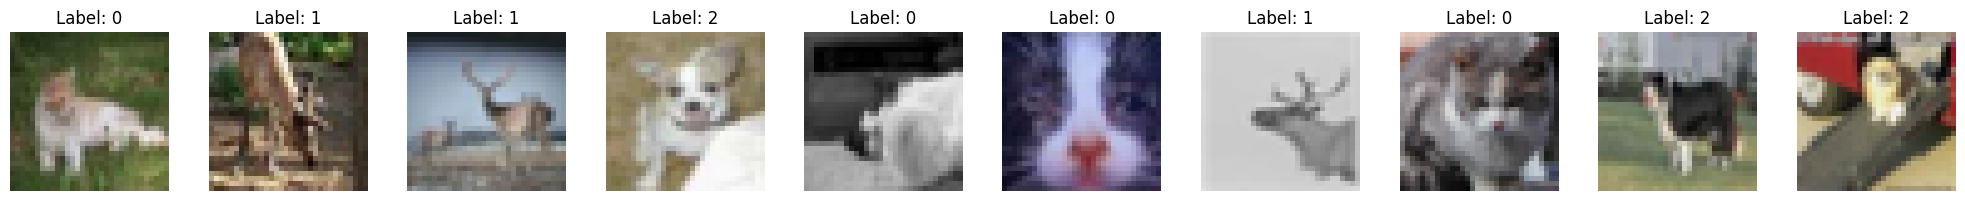

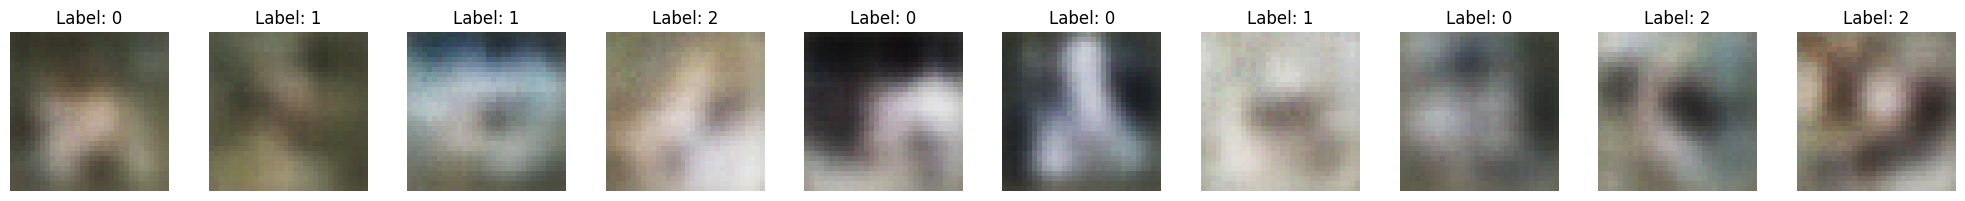

Memory cached in GPU: 0

Training Epoch: [2 | 80] LR: 0.000500
[epoch: 2] (59/59) | Loss: 0.0143 |


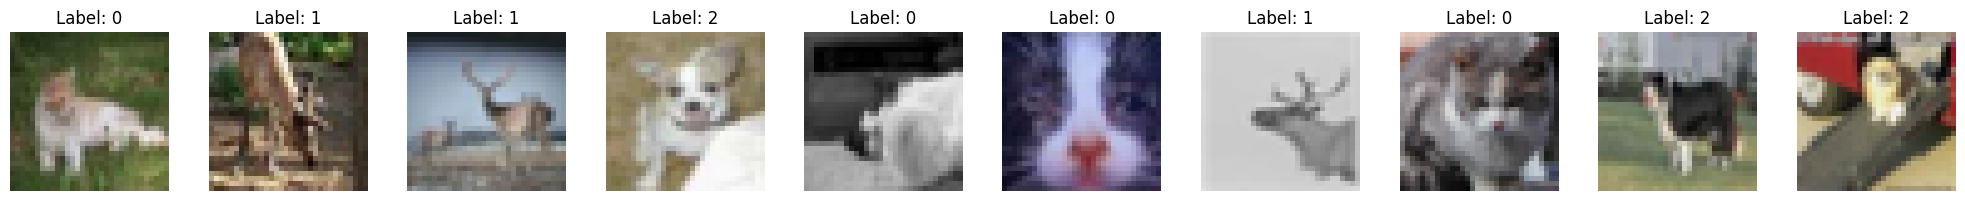

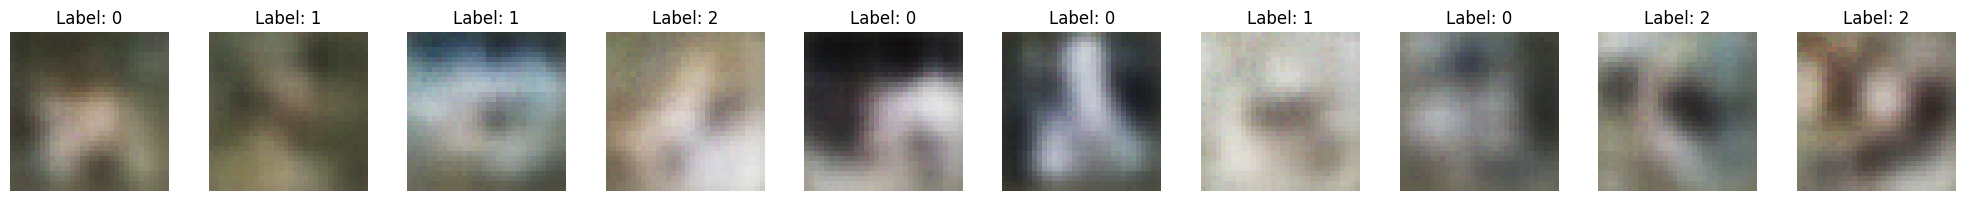

Memory cached in GPU: 0

Training Epoch: [3 | 80] LR: 0.000500
[epoch: 3] (59/59) | Loss: 0.0143 |


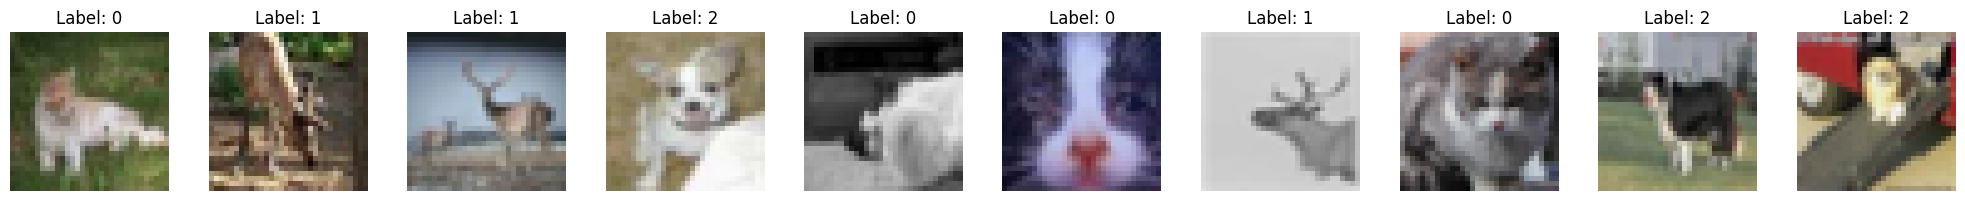

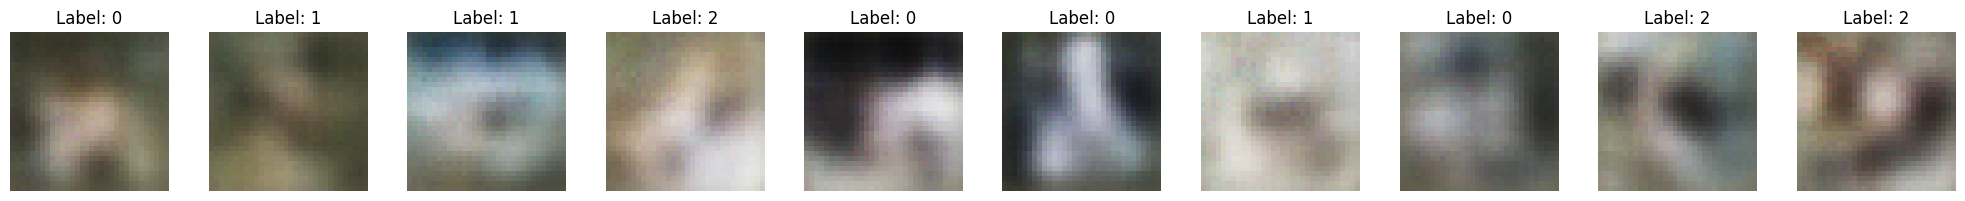

Memory cached in GPU: 0

Training Epoch: [4 | 80] LR: 0.000500
[epoch: 4] (59/59) | Loss: 0.0143 |


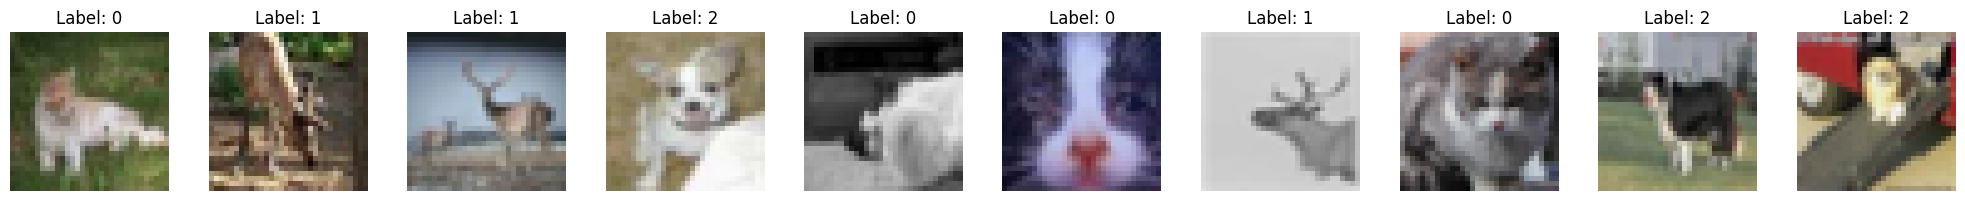

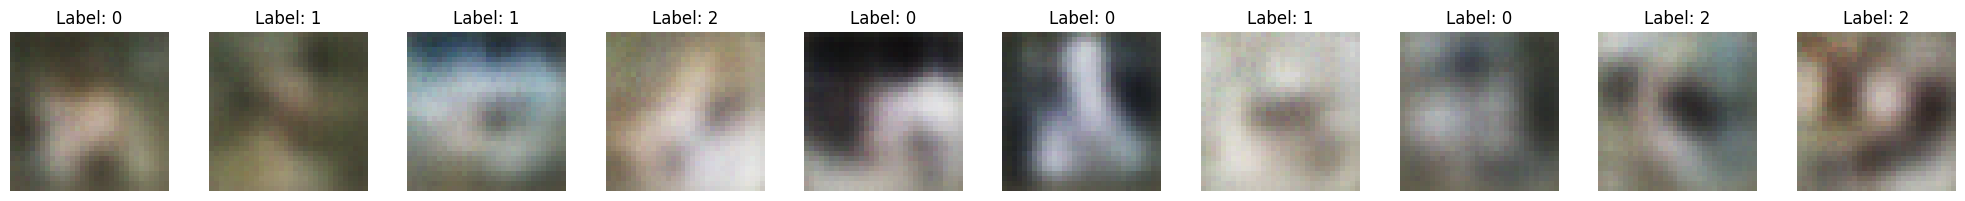

Memory cached in GPU: 0

Training Epoch: [5 | 80] LR: 0.000500
[epoch: 5] (59/59) | Loss: 0.0143 |


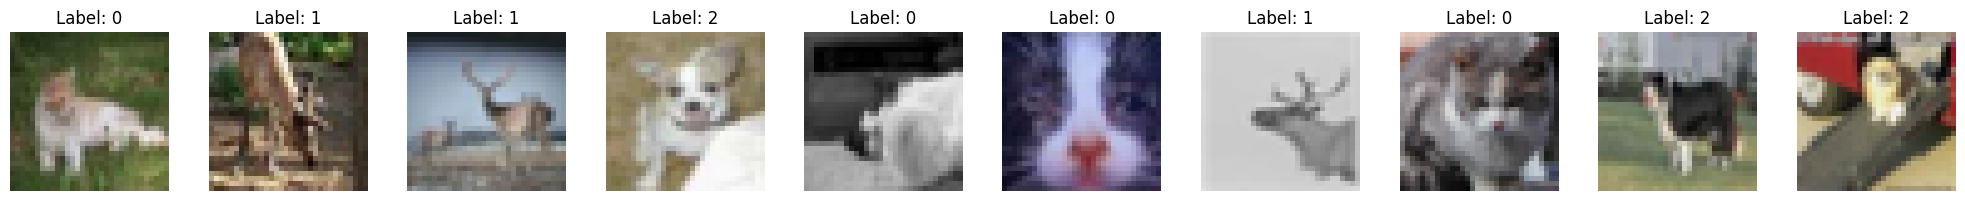

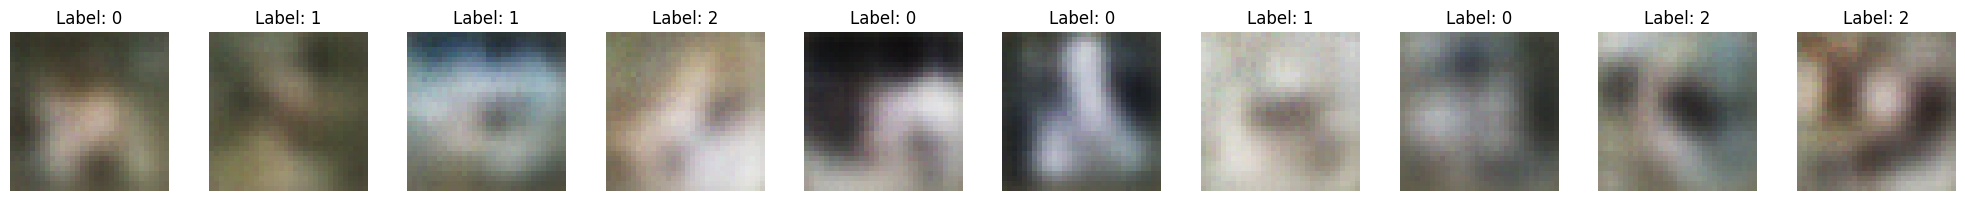

Memory cached in GPU: 0

Training Epoch: [6 | 80] LR: 0.000500
[epoch: 6] (59/59) | Loss: 0.0143 |


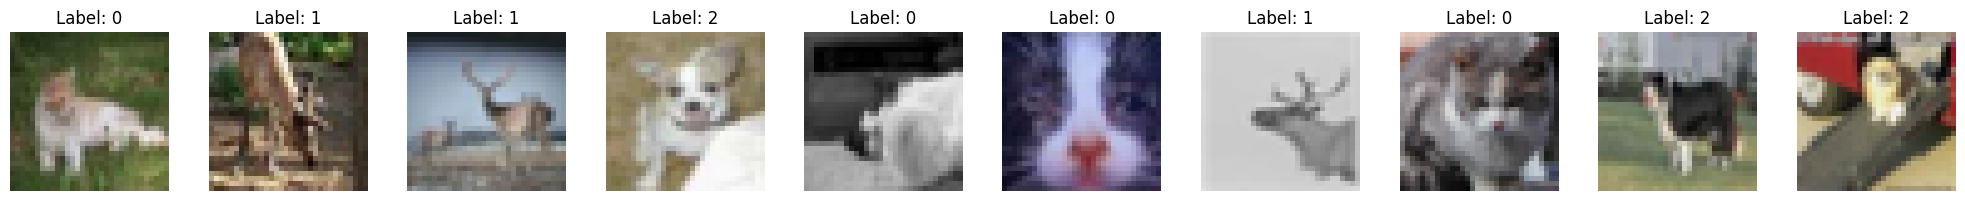

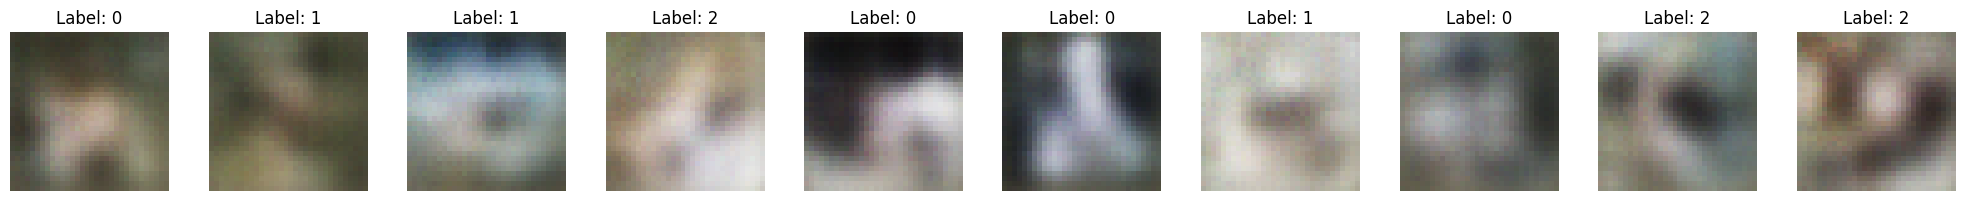

Memory cached in GPU: 0

Training Epoch: [7 | 80] LR: 0.000500
[epoch: 7] (59/59) | Loss: 0.0143 |


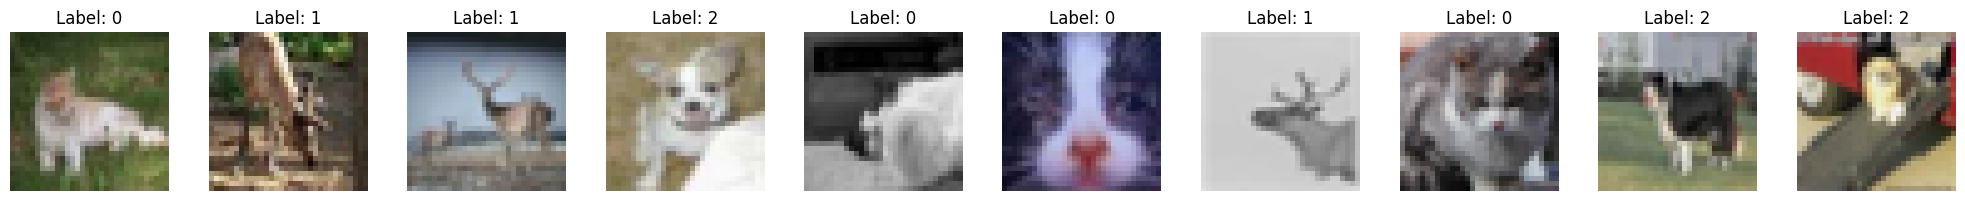

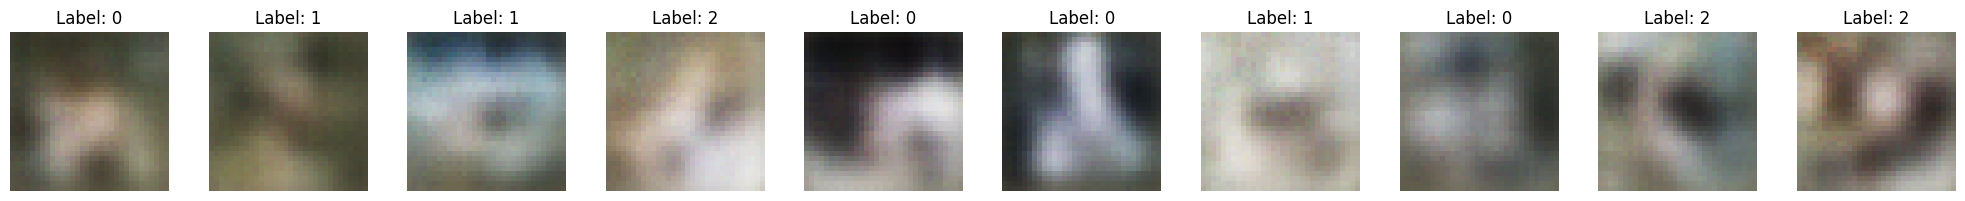

Memory cached in GPU: 0

Training Epoch: [8 | 80] LR: 0.000500
[epoch: 8] (59/59) | Loss: 0.0143 |


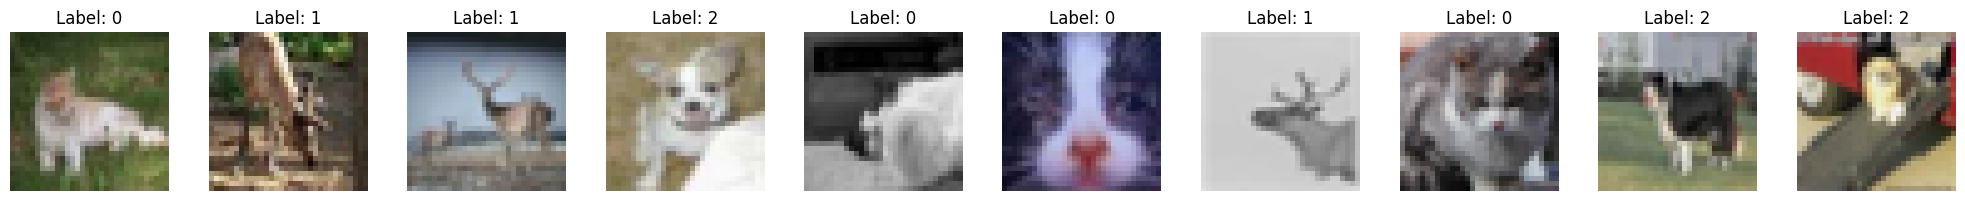

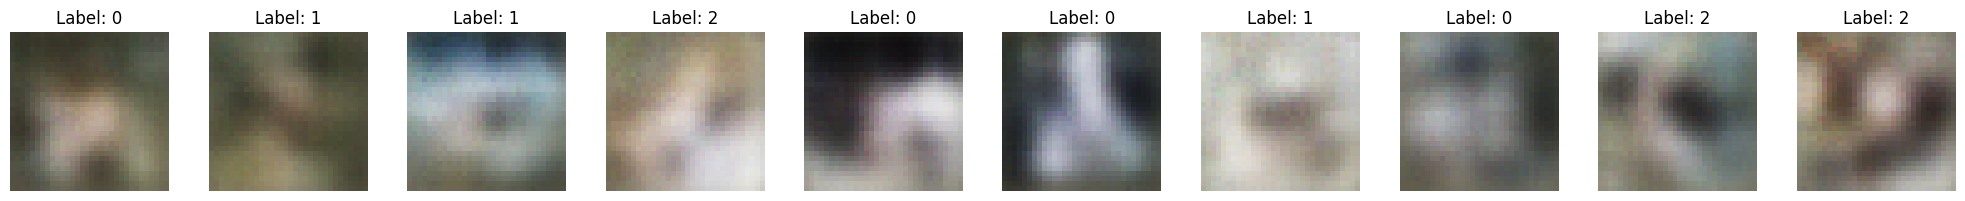

Memory cached in GPU: 0

Training Epoch: [9 | 80] LR: 0.000500
[epoch: 9] (59/59) | Loss: 0.0142 |


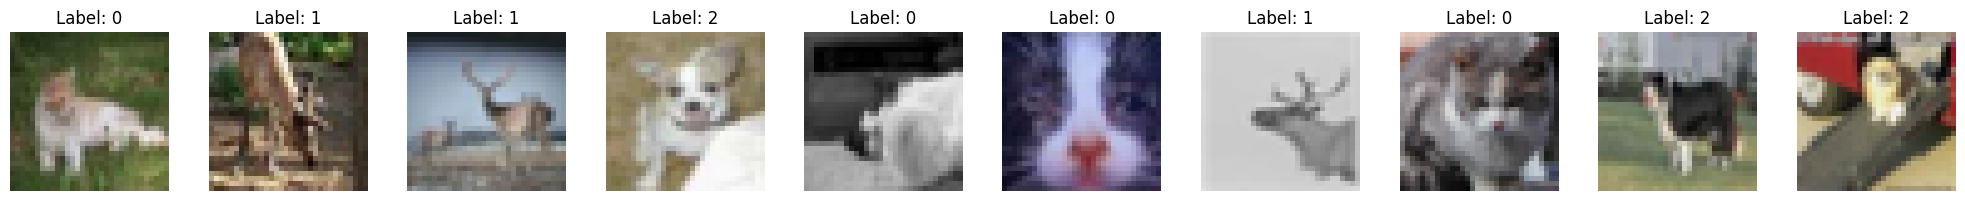

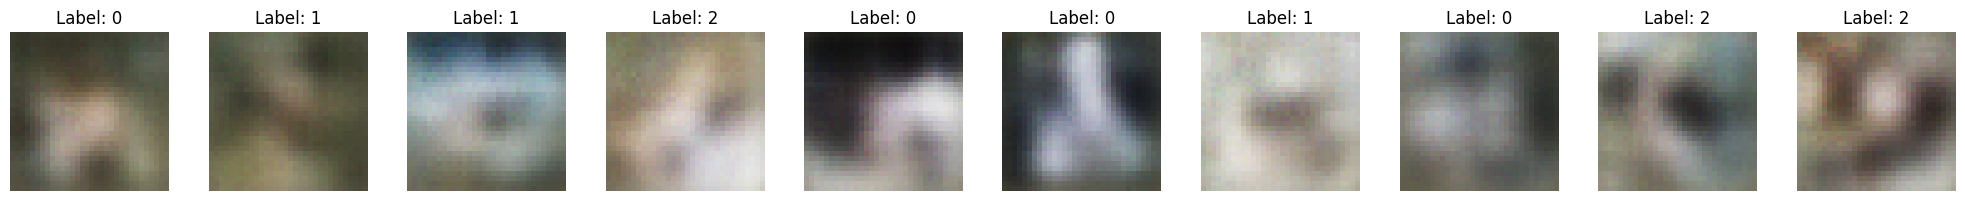

Memory cached in GPU: 0

Training Epoch: [10 | 80] LR: 0.000500
[epoch: 10] (59/59) | Loss: 0.0142 |


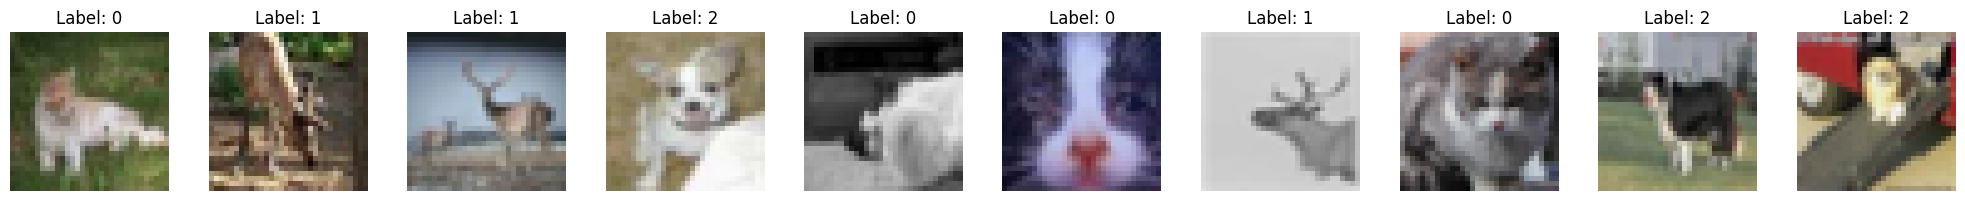

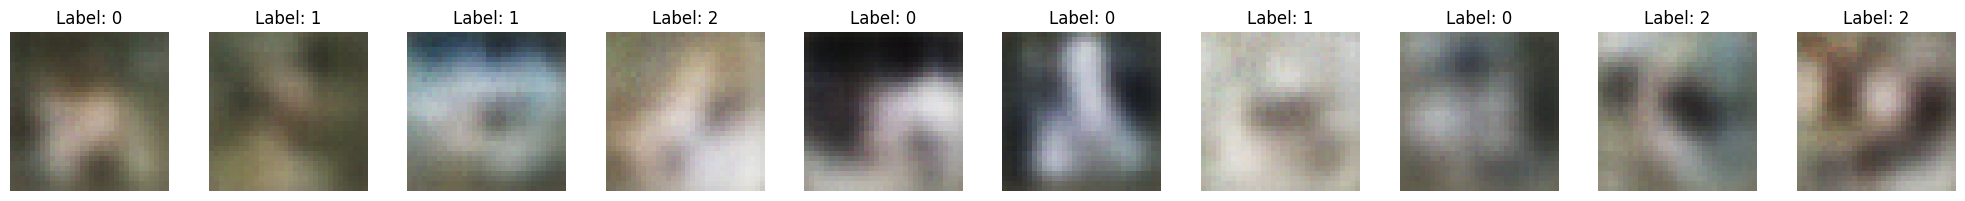

Memory cached in GPU: 0

Training Epoch: [11 | 80] LR: 0.000500
[epoch: 11] (59/59) | Loss: 0.0142 |


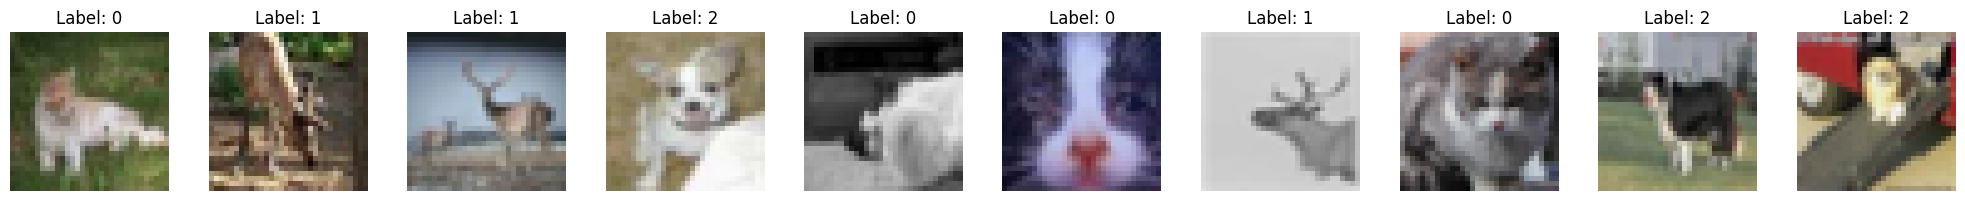

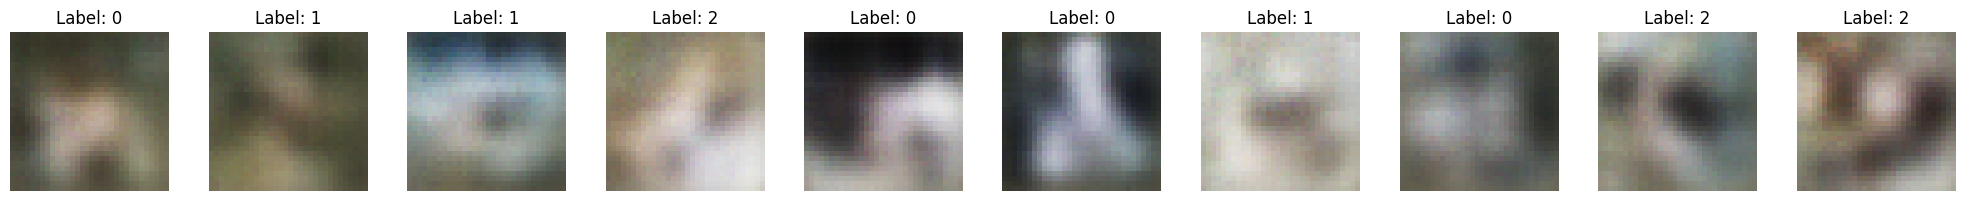

Memory cached in GPU: 0

Training Epoch: [12 | 80] LR: 0.000500
[epoch: 12] (59/59) | Loss: 0.0142 |


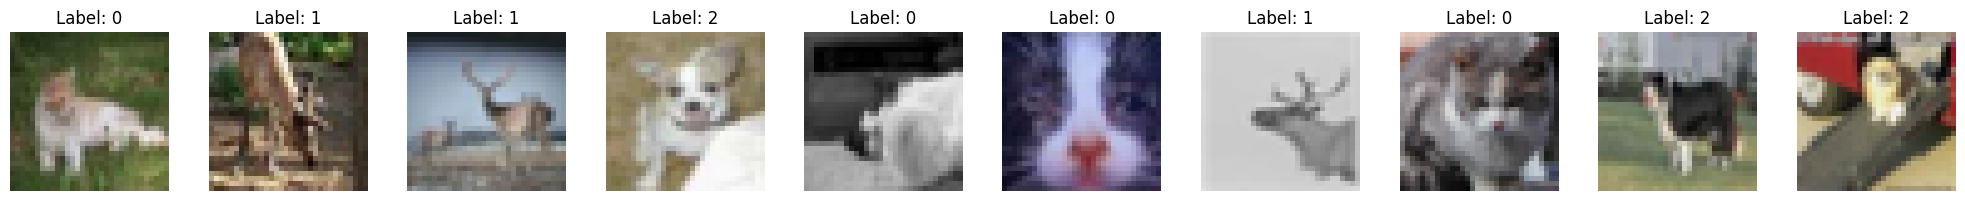

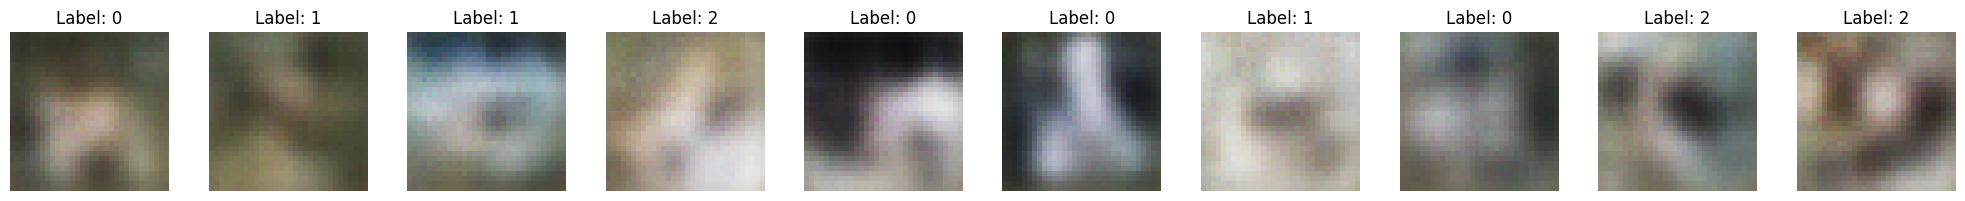

Memory cached in GPU: 0

Training Epoch: [13 | 80] LR: 0.000500
[epoch: 13] (59/59) | Loss: 0.0142 |


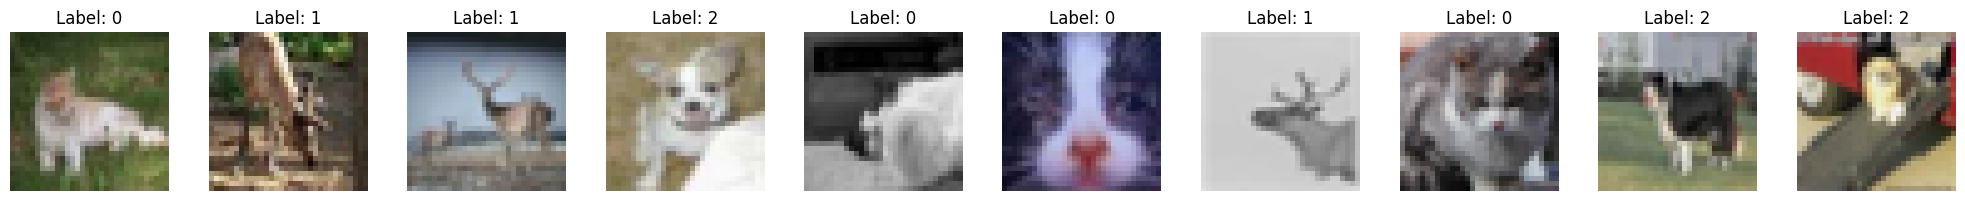

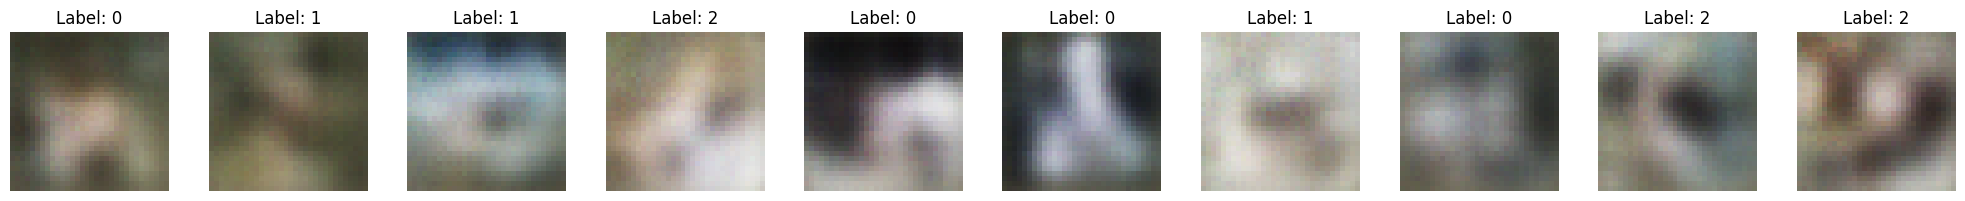

Memory cached in GPU: 0

Training Epoch: [14 | 80] LR: 0.000500
[epoch: 14] (59/59) | Loss: 0.0142 |


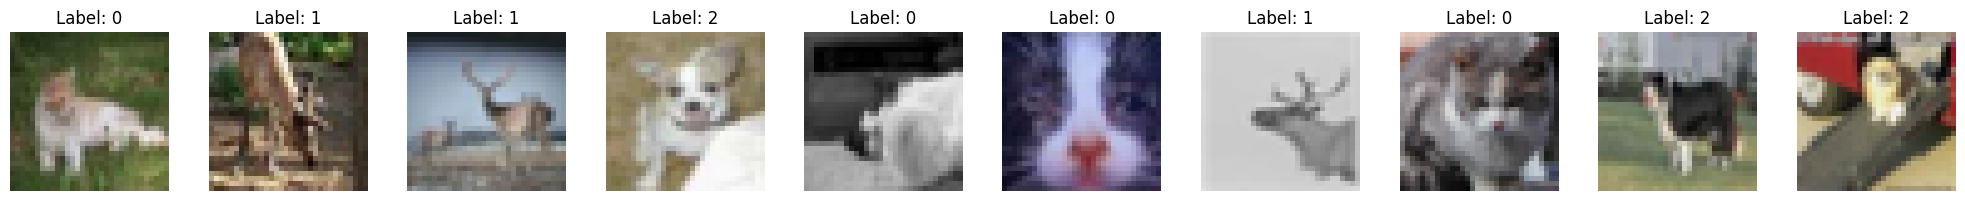

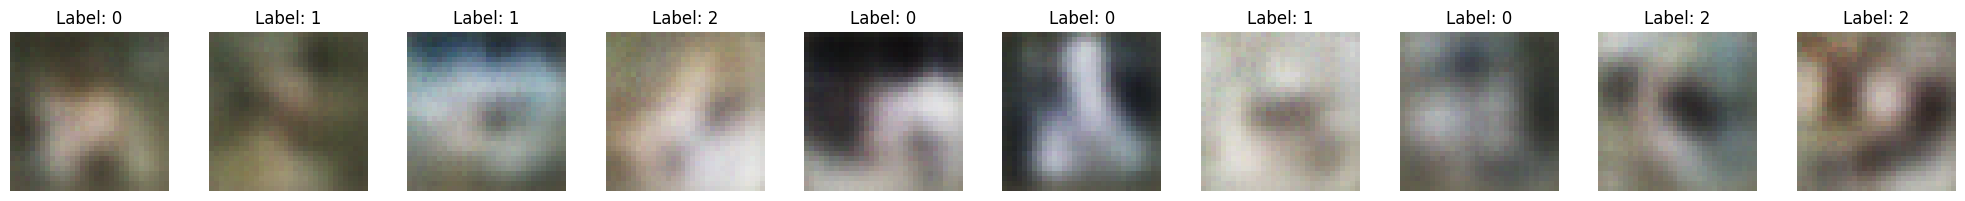

Memory cached in GPU: 0

Training Epoch: [15 | 80] LR: 0.000500
[epoch: 15] (59/59) | Loss: 0.0142 |


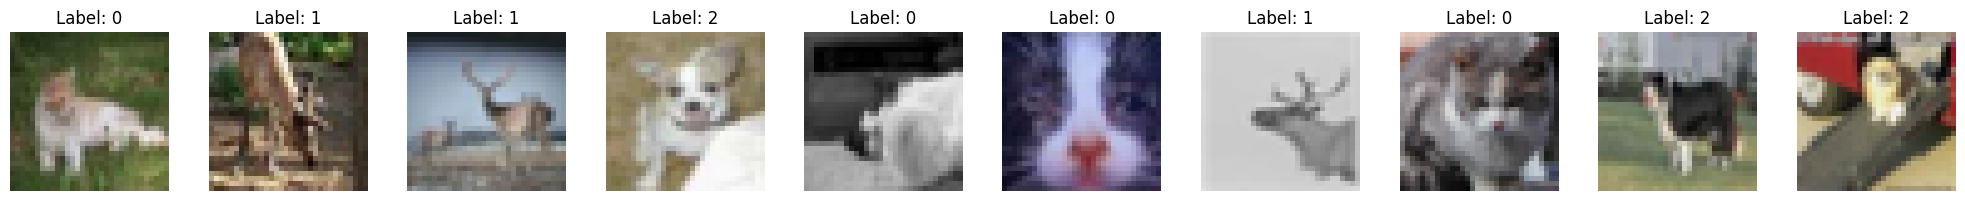

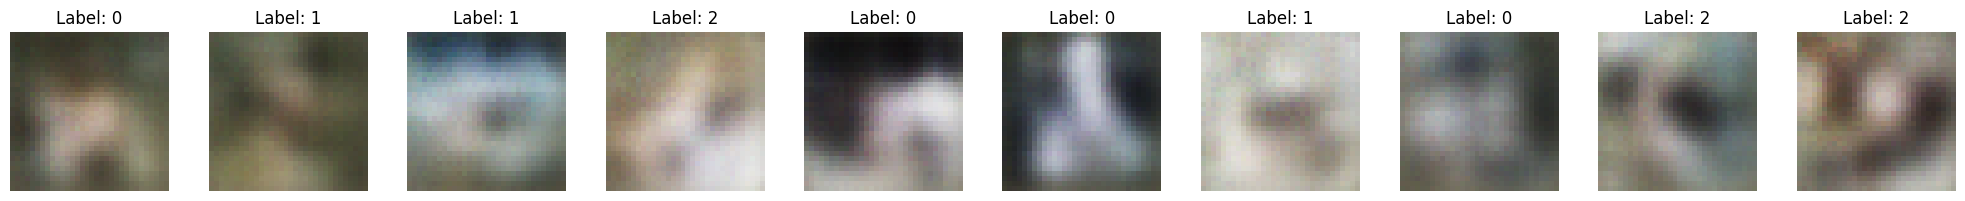

Memory cached in GPU: 0

Training Epoch: [16 | 80] LR: 0.000500
[epoch: 16] (59/59) | Loss: 0.0142 |


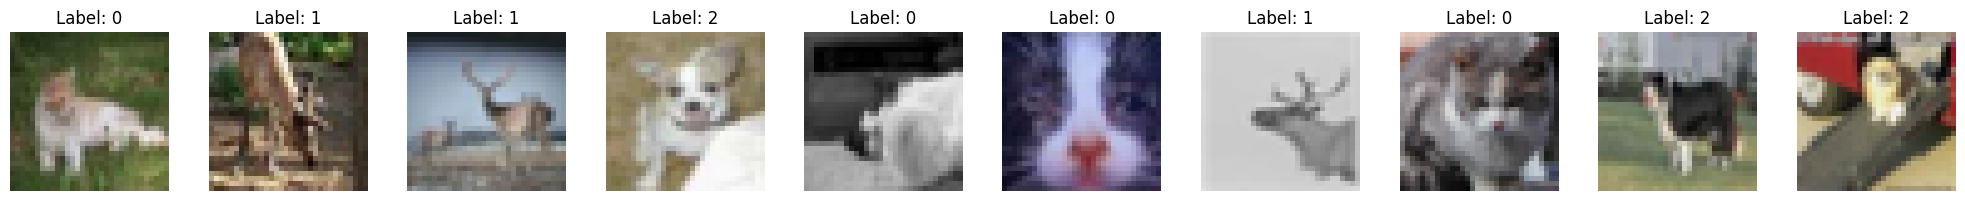

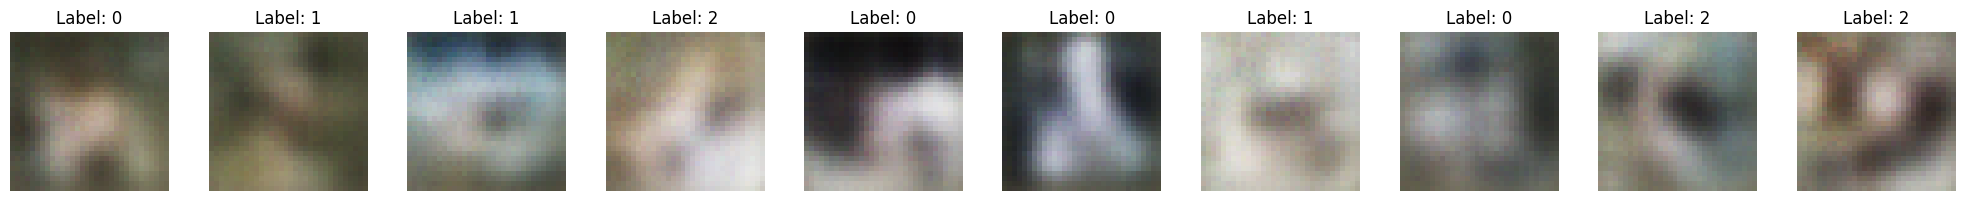

Memory cached in GPU: 0

Training Epoch: [17 | 80] LR: 0.000500
[epoch: 17] (59/59) | Loss: 0.0142 |


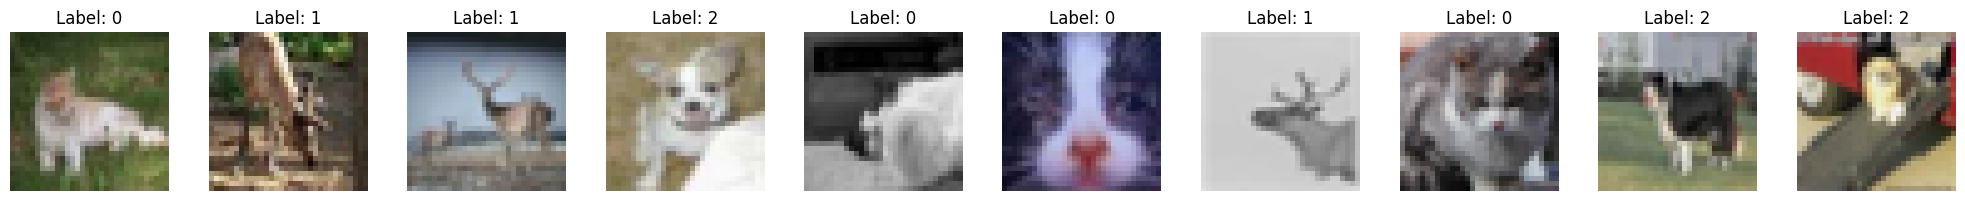

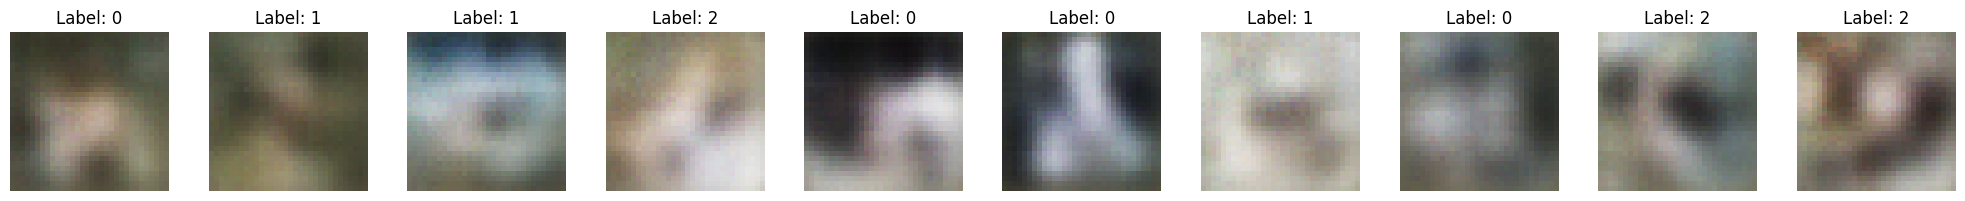

Memory cached in GPU: 0

Training Epoch: [18 | 80] LR: 0.000500
[epoch: 18] (59/59) | Loss: 0.0142 |


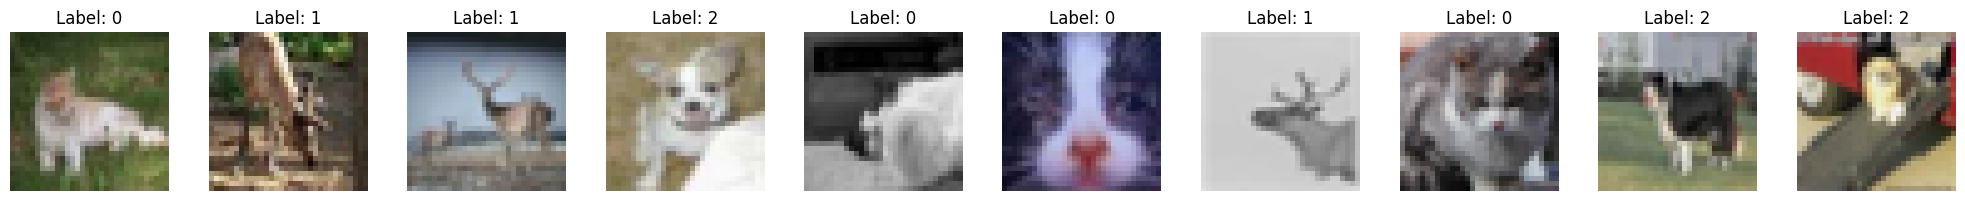

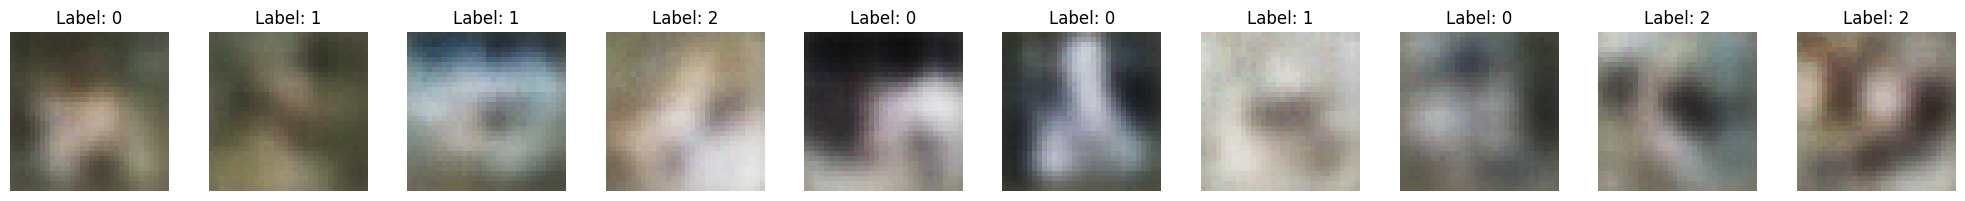

Memory cached in GPU: 0

Training Epoch: [19 | 80] LR: 0.000500
[epoch: 19] (59/59) | Loss: 0.0142 |


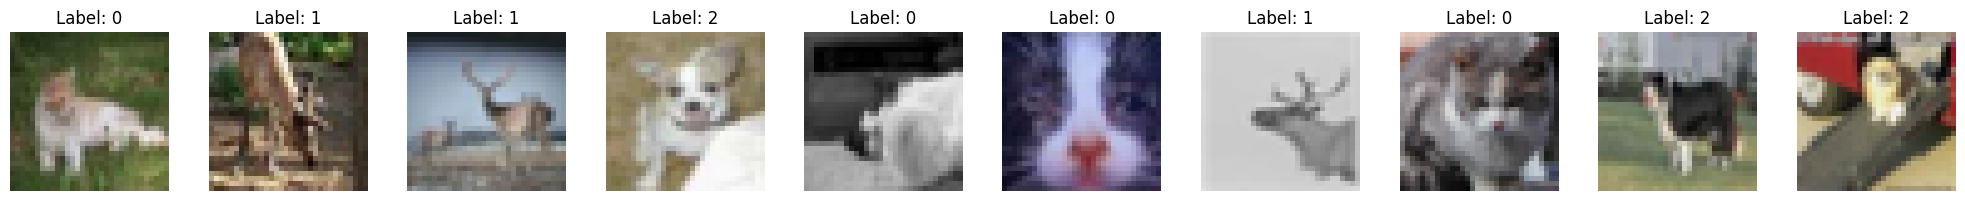

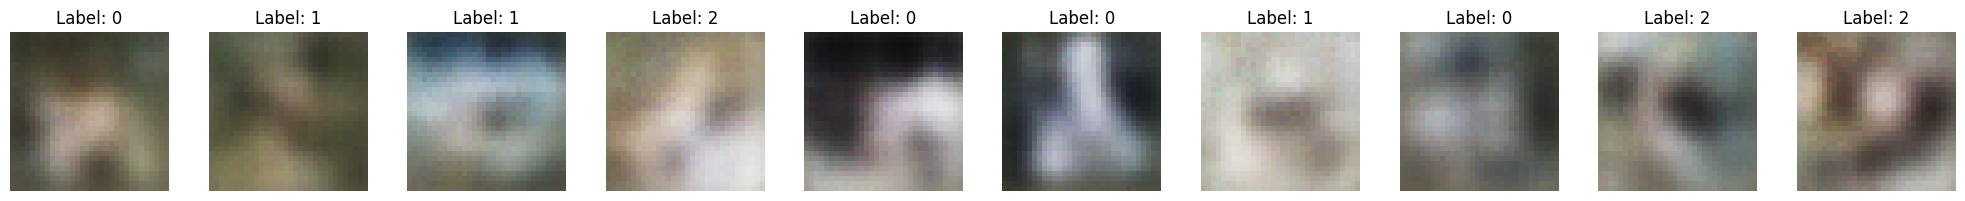

Memory cached in GPU: 0

Training Epoch: [20 | 80] LR: 0.000500
[epoch: 20] (59/59) | Loss: 0.0142 |


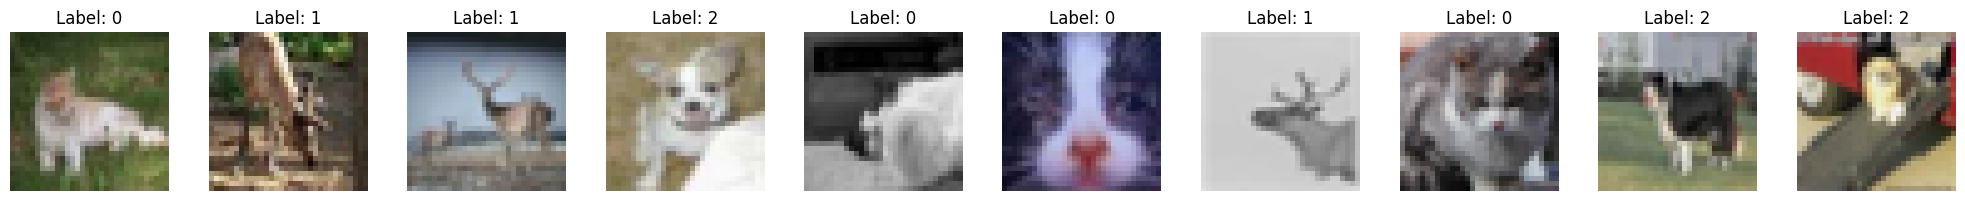

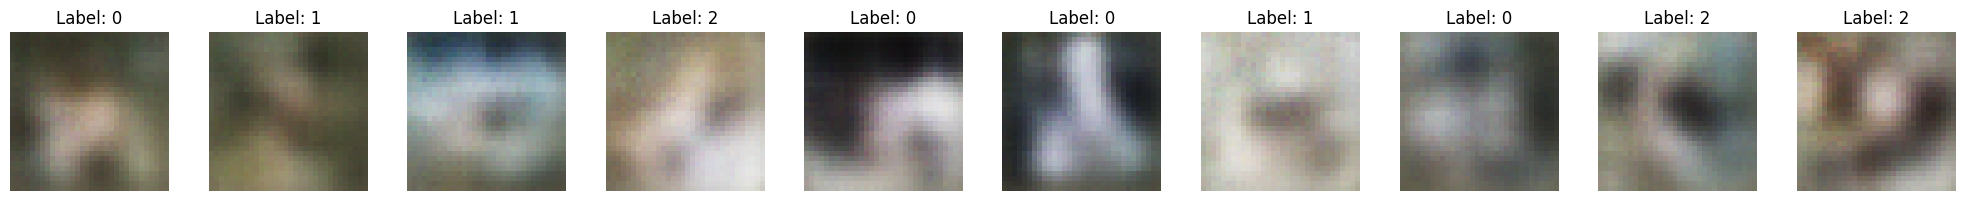

Memory cached in GPU: 0

Training Epoch: [21 | 80] LR: 0.000500
[epoch: 21] (59/59) | Loss: 0.0142 |


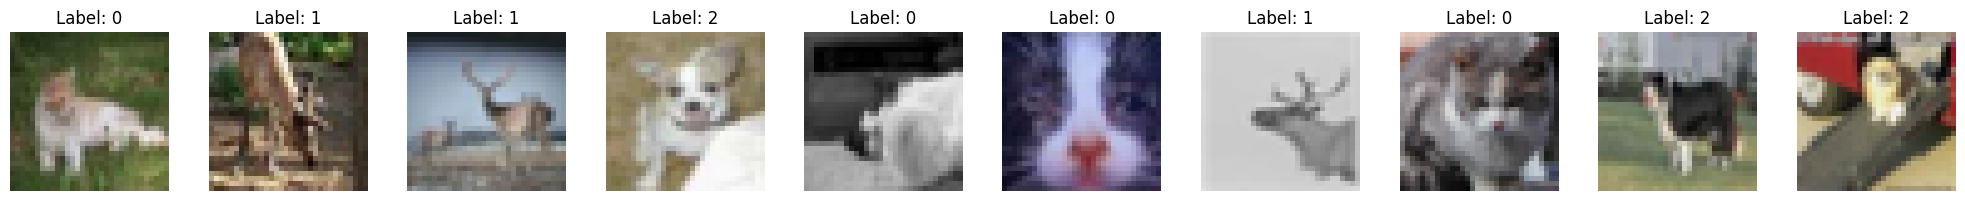

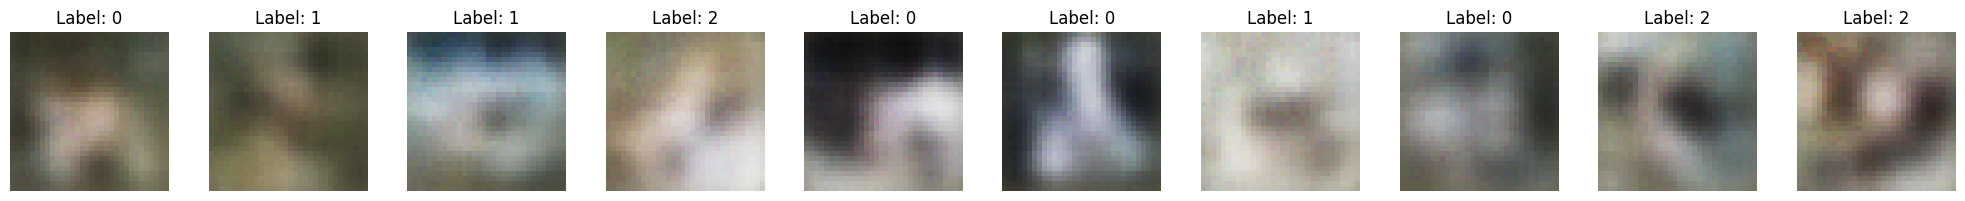

Memory cached in GPU: 0

Training Epoch: [22 | 80] LR: 0.000500
[epoch: 22] (59/59) | Loss: 0.0142 |


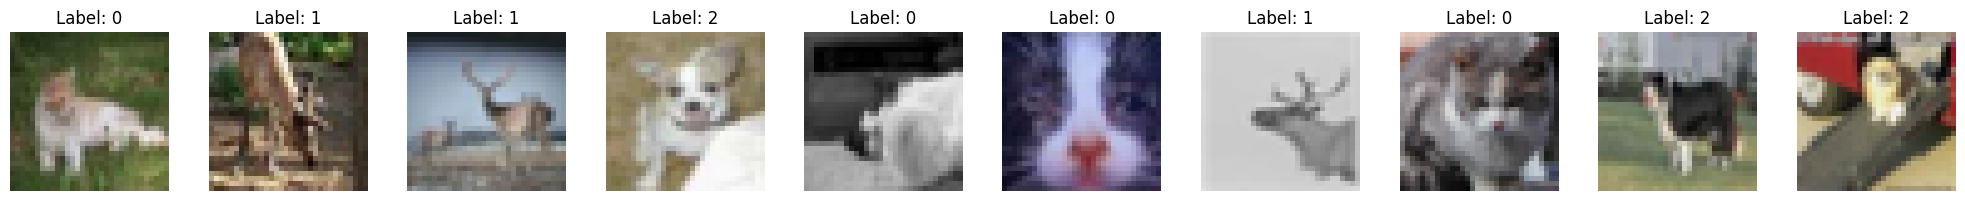

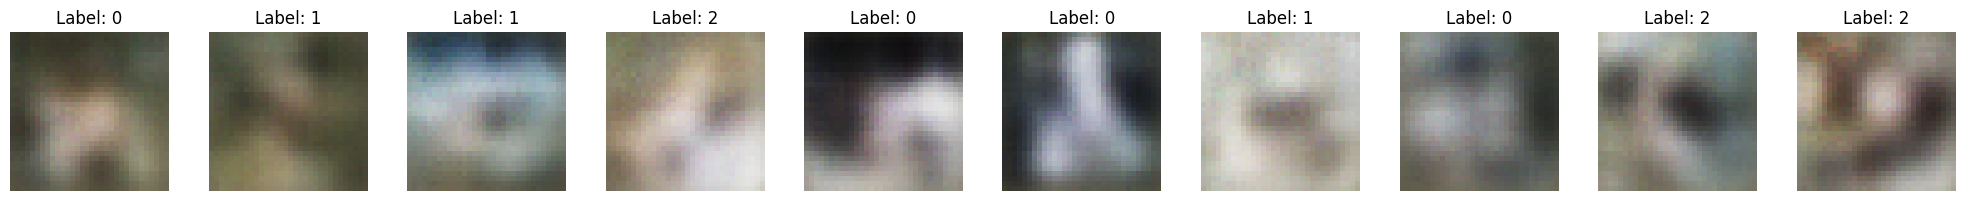

Memory cached in GPU: 0

Training Epoch: [23 | 80] LR: 0.000500
[epoch: 23] (59/59) | Loss: 0.0141 |


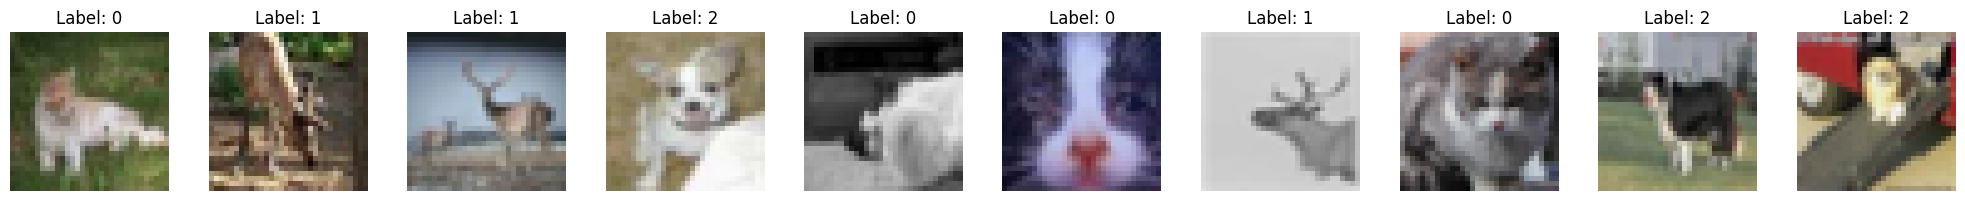

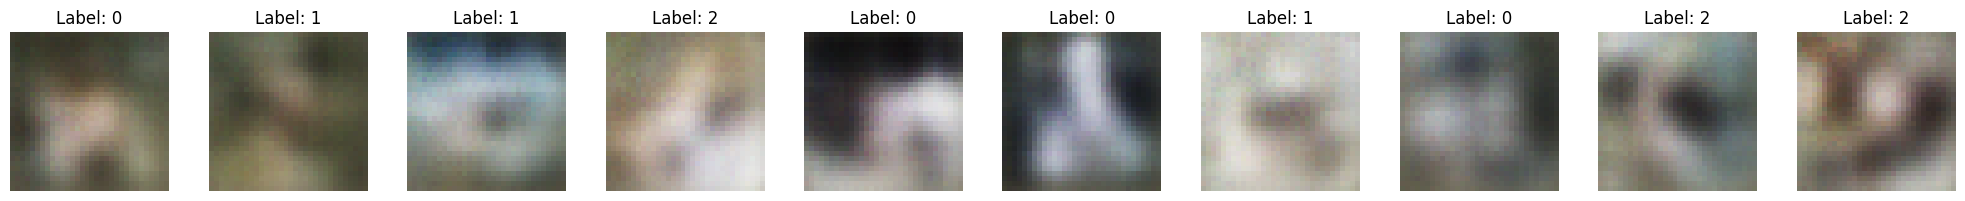

Memory cached in GPU: 0

Training Epoch: [24 | 80] LR: 0.000500
[epoch: 24] (59/59) | Loss: 0.0141 |


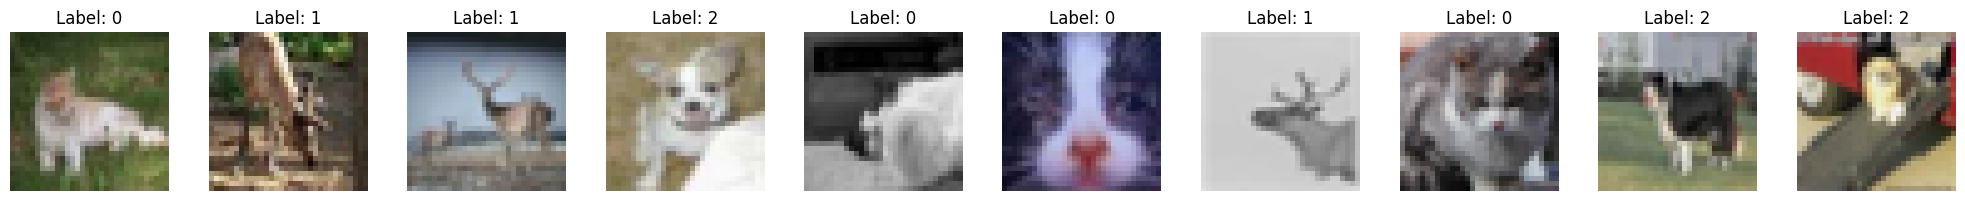

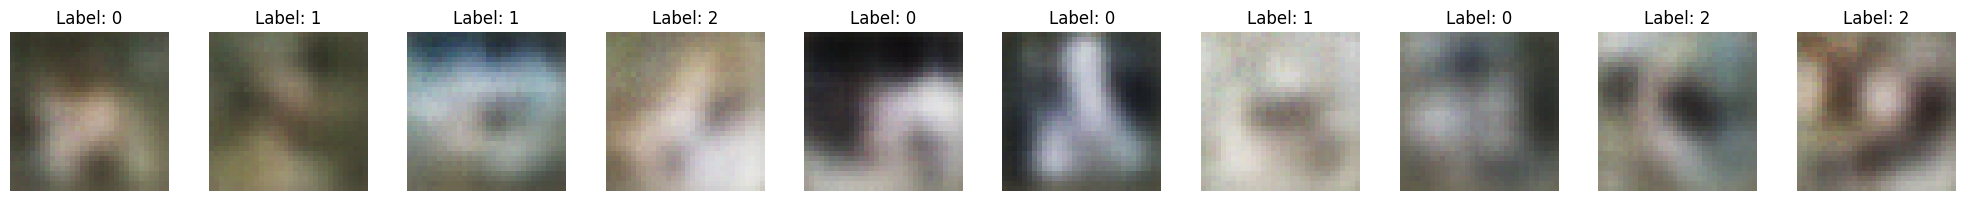

Memory cached in GPU: 0

Training Epoch: [25 | 80] LR: 0.000500
[epoch: 25] (59/59) | Loss: 0.0141 |


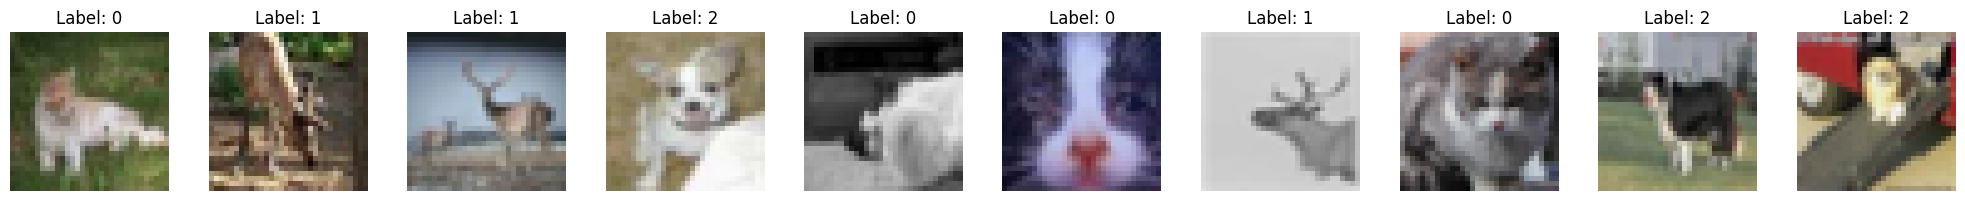

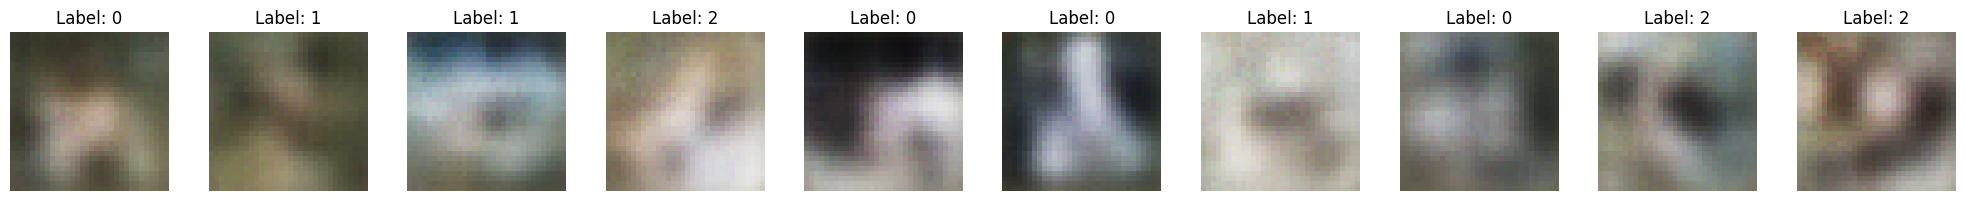

Memory cached in GPU: 0

Training Epoch: [26 | 80] LR: 0.000500
[epoch: 26] (59/59) | Loss: 0.0141 |


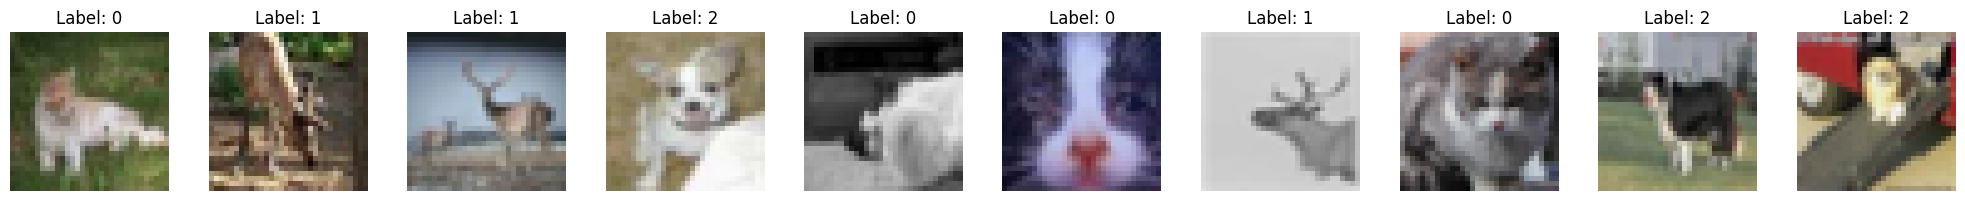

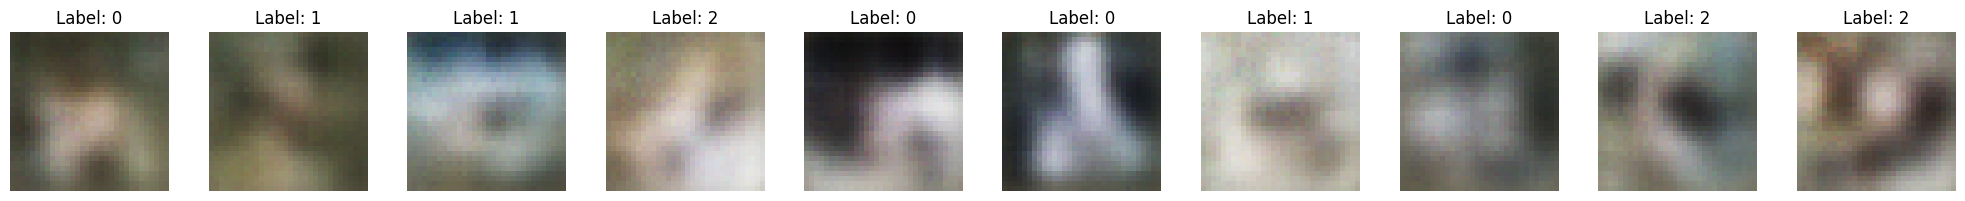

Memory cached in GPU: 0

Training Epoch: [27 | 80] LR: 0.000500
[epoch: 27] (59/59) | Loss: 0.0141 |


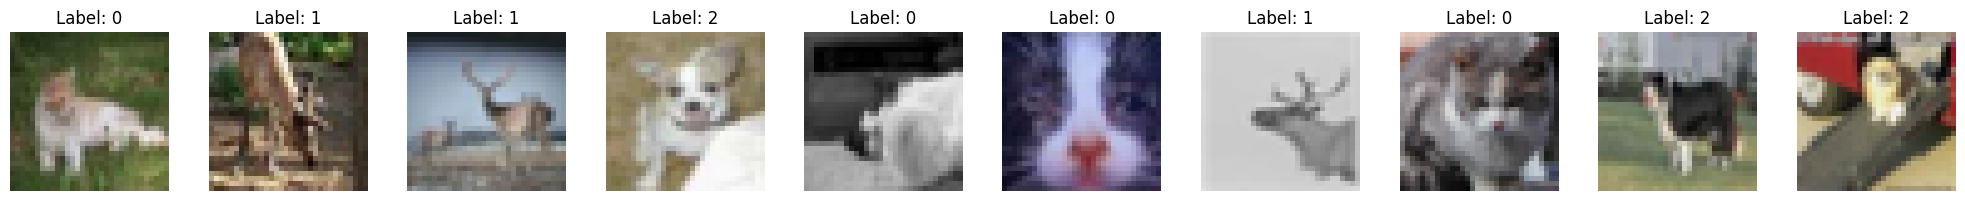

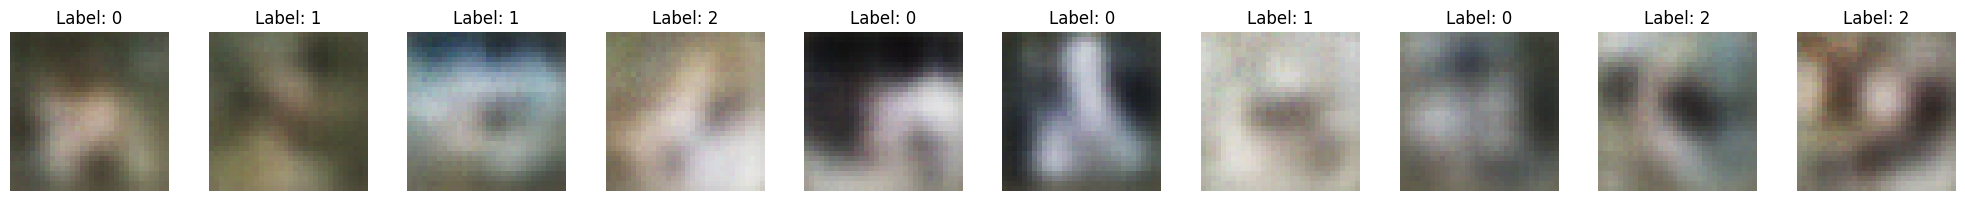

Memory cached in GPU: 0

Training Epoch: [28 | 80] LR: 0.000500
[epoch: 28] (59/59) | Loss: 0.0141 |


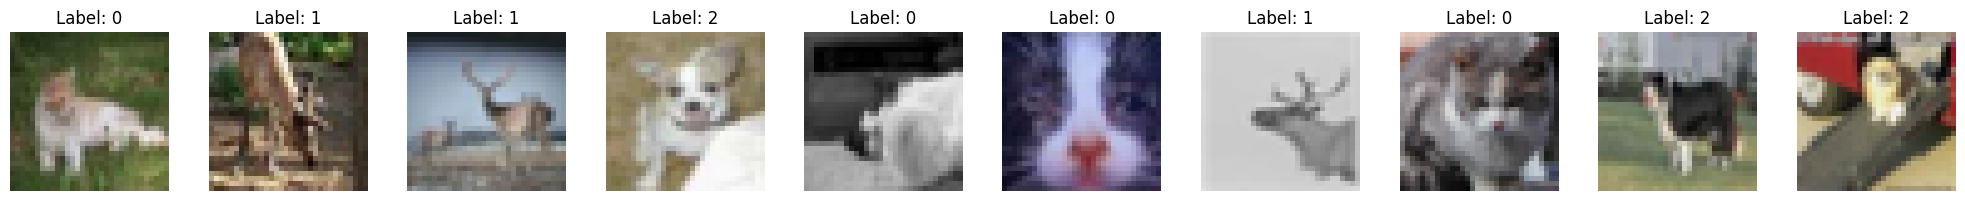

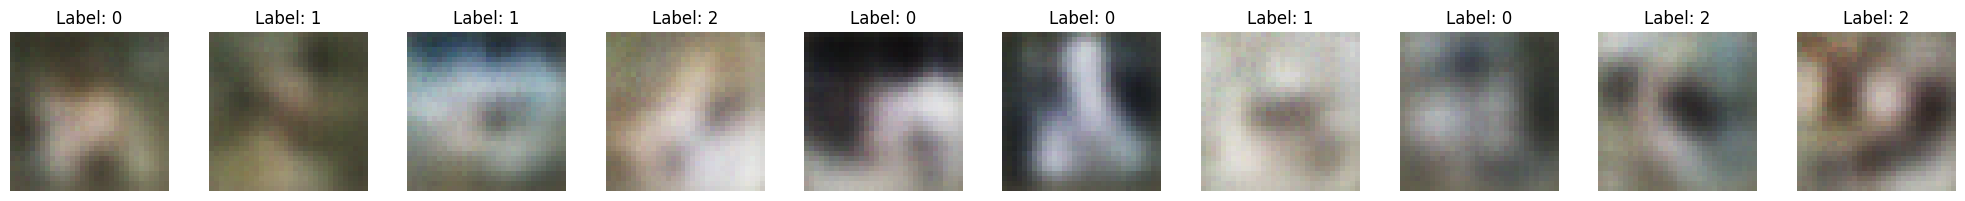

Memory cached in GPU: 0

Training Epoch: [29 | 80] LR: 0.000500
[epoch: 29] (59/59) | Loss: 0.0141 |


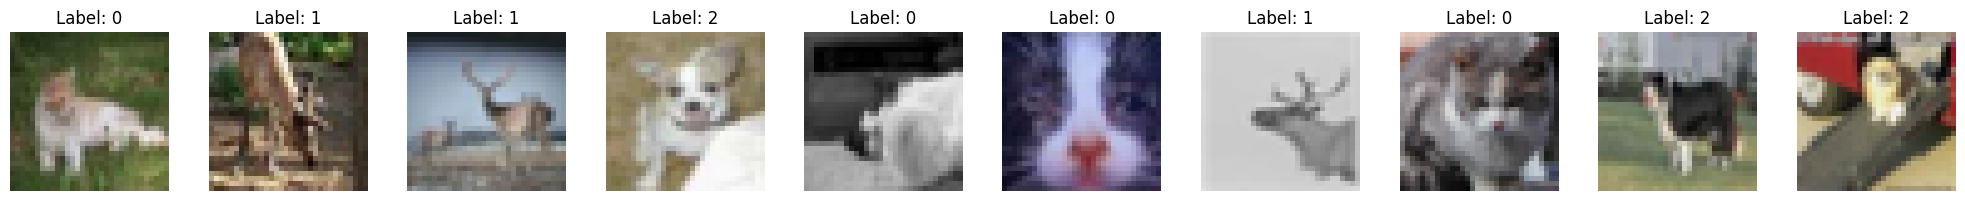

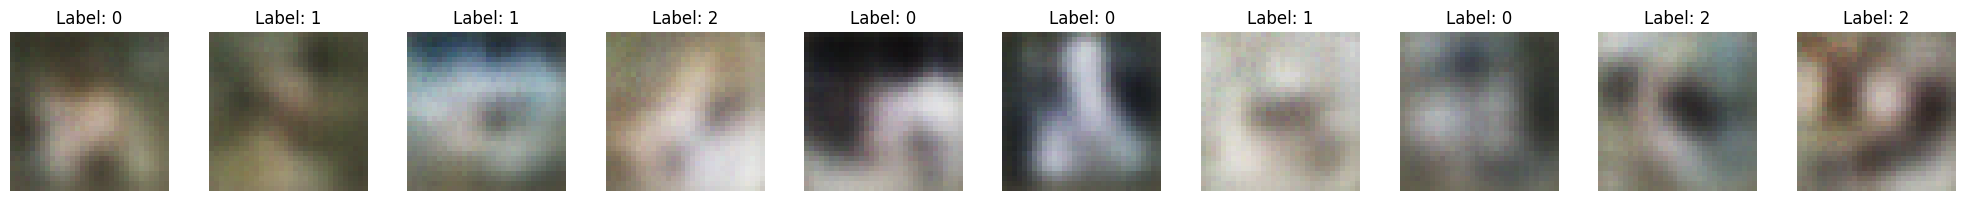

Memory cached in GPU: 0

Training Epoch: [30 | 80] LR: 0.000500
[epoch: 30] (59/59) | Loss: 0.0141 |


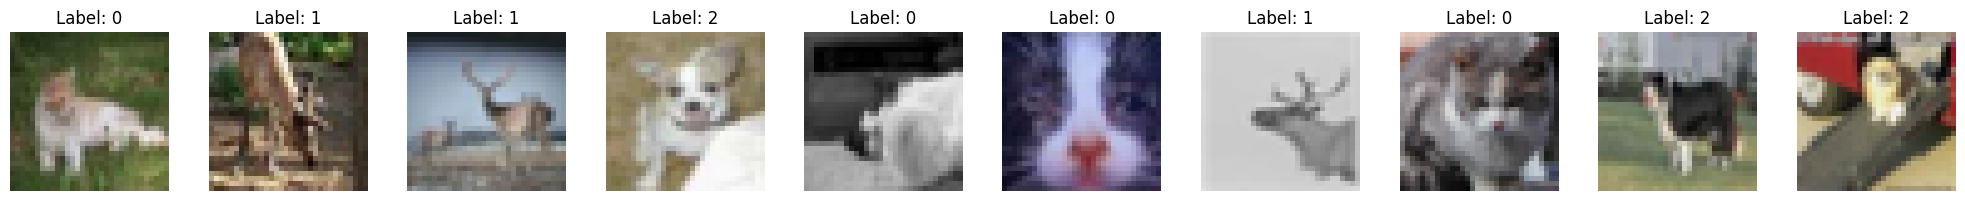

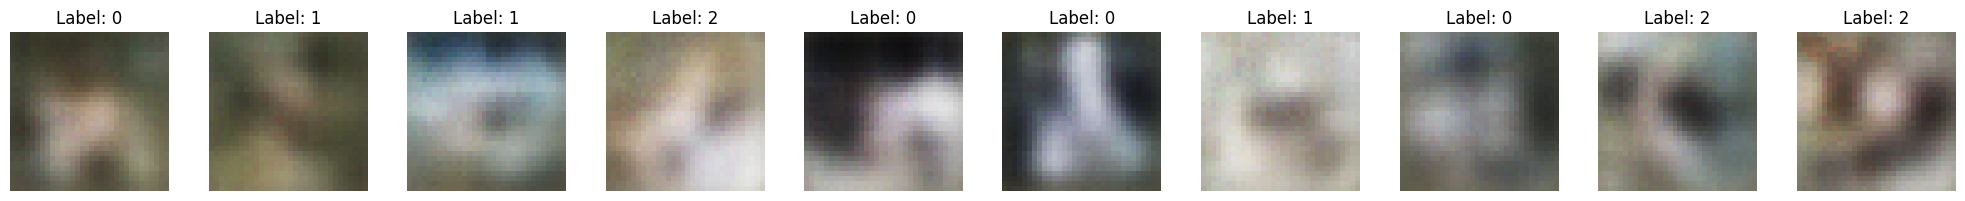

Memory cached in GPU: 0

Training Epoch: [31 | 80] LR: 0.000500
[epoch: 31] (59/59) | Loss: 0.0141 |


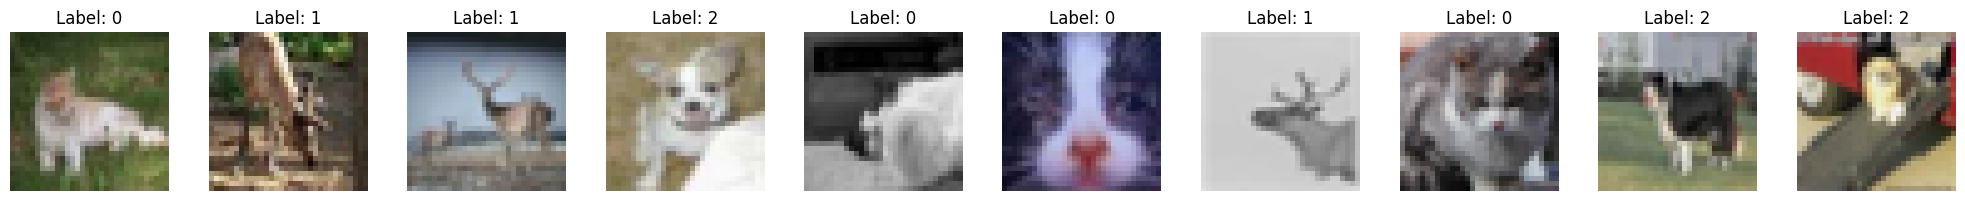

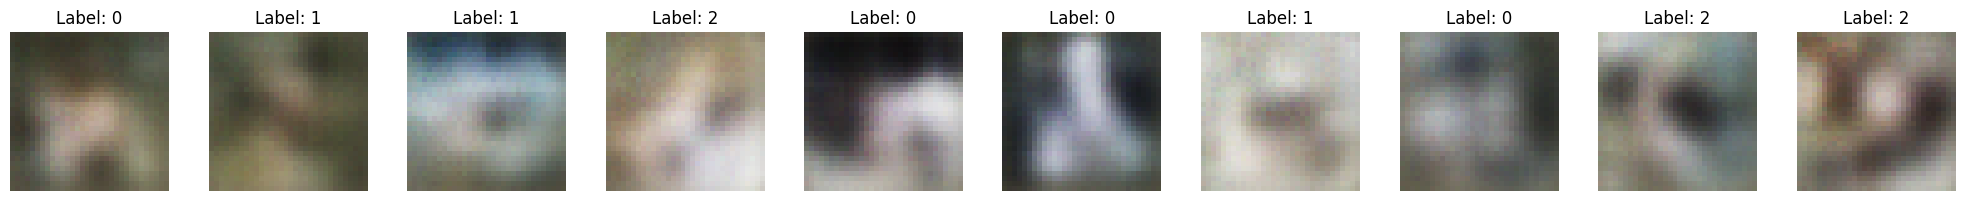

Memory cached in GPU: 0

Training Epoch: [32 | 80] LR: 0.000500
[epoch: 32] (59/59) | Loss: 0.0141 |


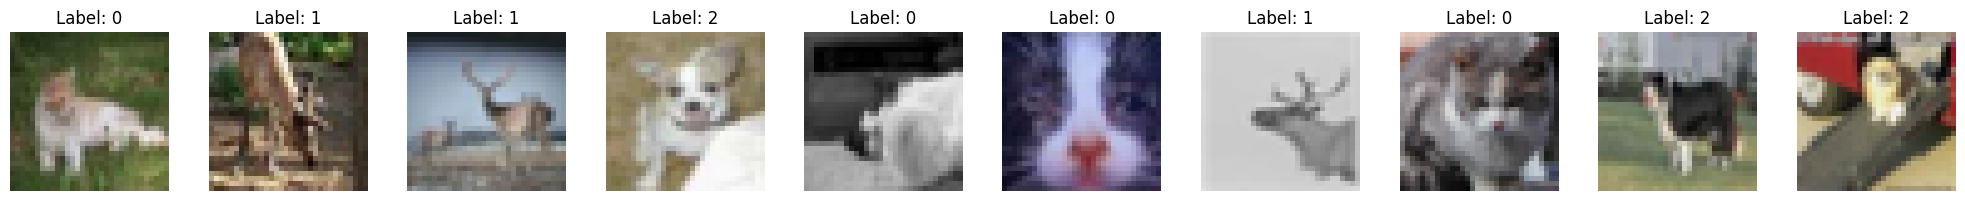

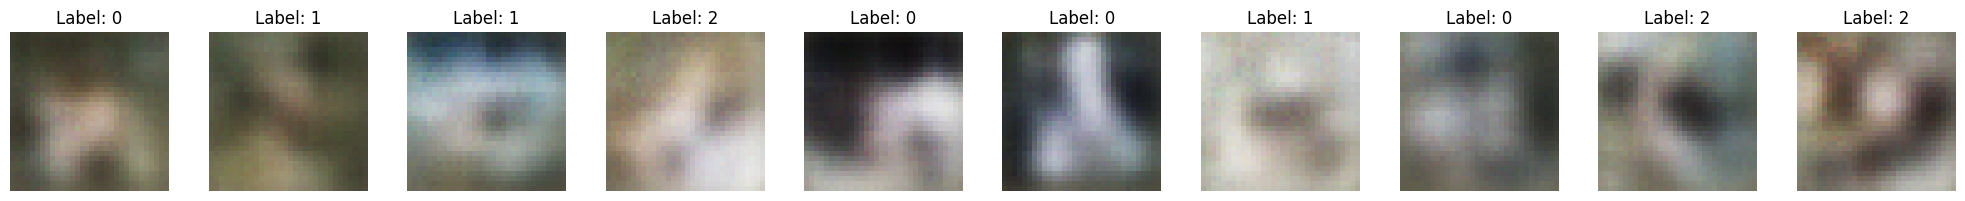

Memory cached in GPU: 0

Training Epoch: [33 | 80] LR: 0.000500
[epoch: 33] (59/59) | Loss: 0.0141 |


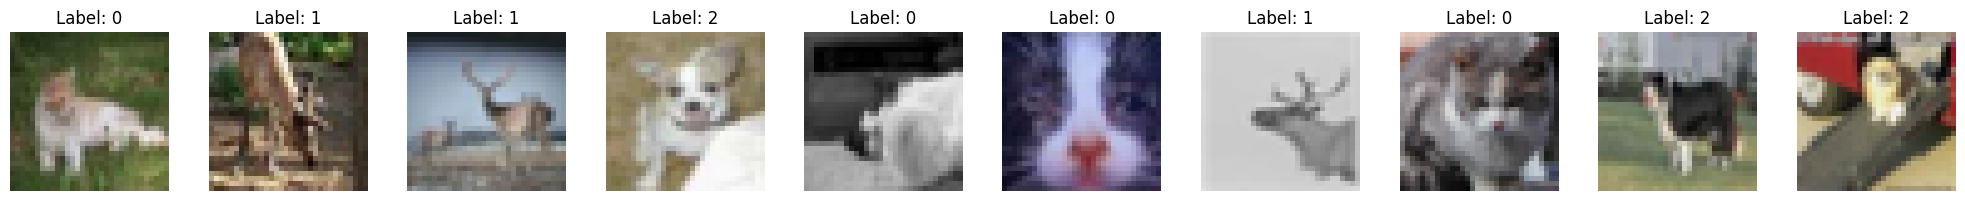

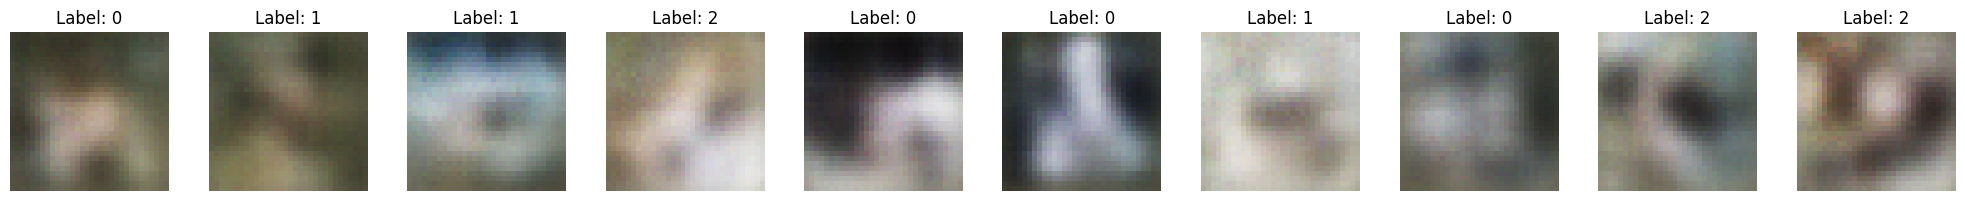

Memory cached in GPU: 0

Training Epoch: [34 | 80] LR: 0.000500
[epoch: 34] (59/59) | Loss: 0.0141 |


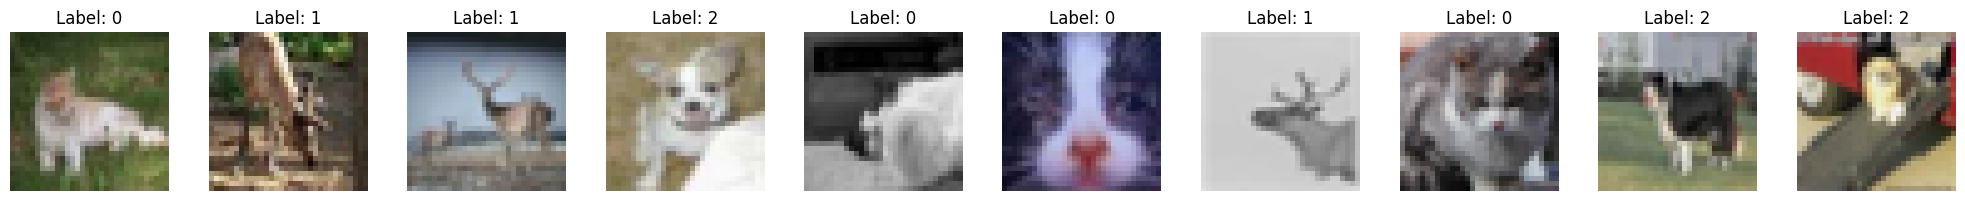

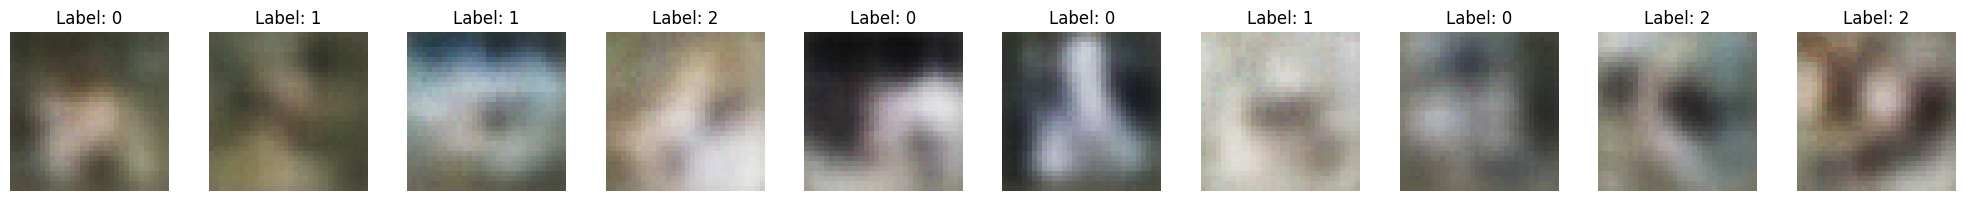

Memory cached in GPU: 0

Training Epoch: [35 | 80] LR: 0.000500
[epoch: 35] (59/59) | Loss: 0.0141 |


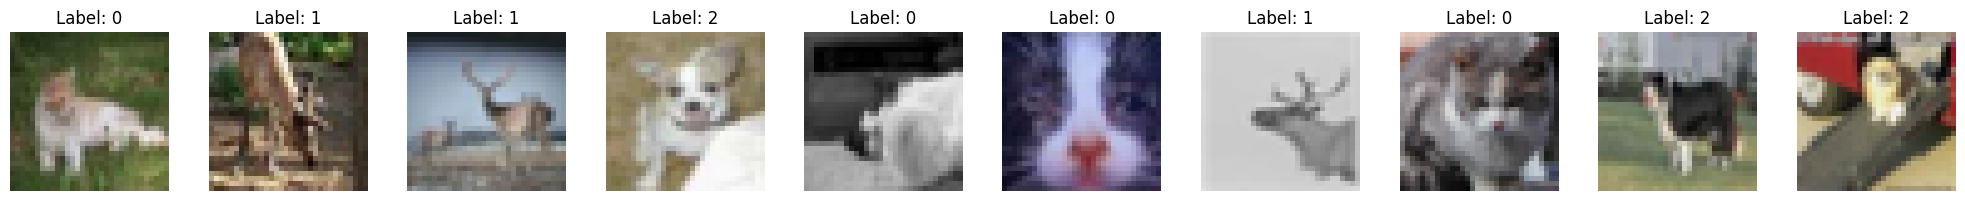

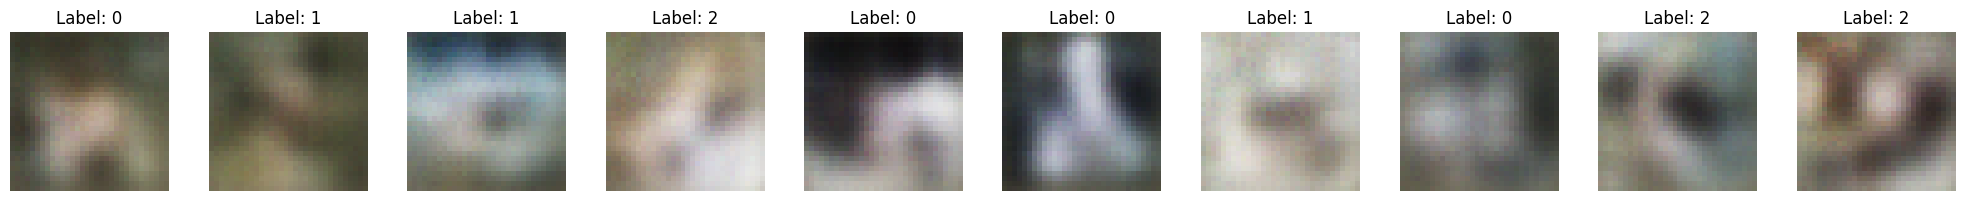

Memory cached in GPU: 0

Training Epoch: [36 | 80] LR: 0.000500
[epoch: 36] (59/59) | Loss: 0.0141 |


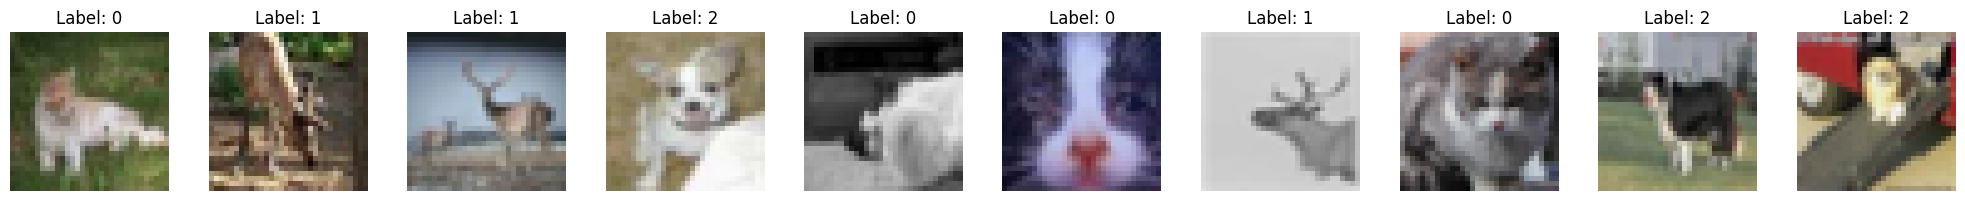

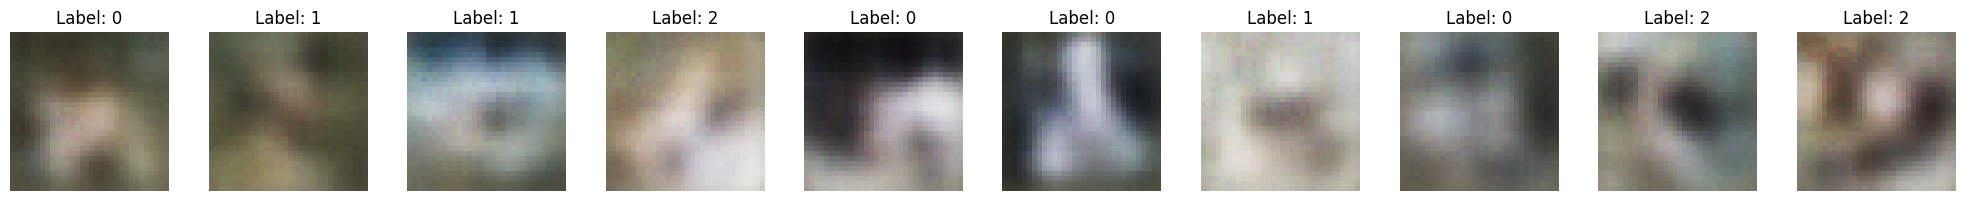

Memory cached in GPU: 0

Training Epoch: [37 | 80] LR: 0.000500
[epoch: 37] (59/59) | Loss: 0.0141 |


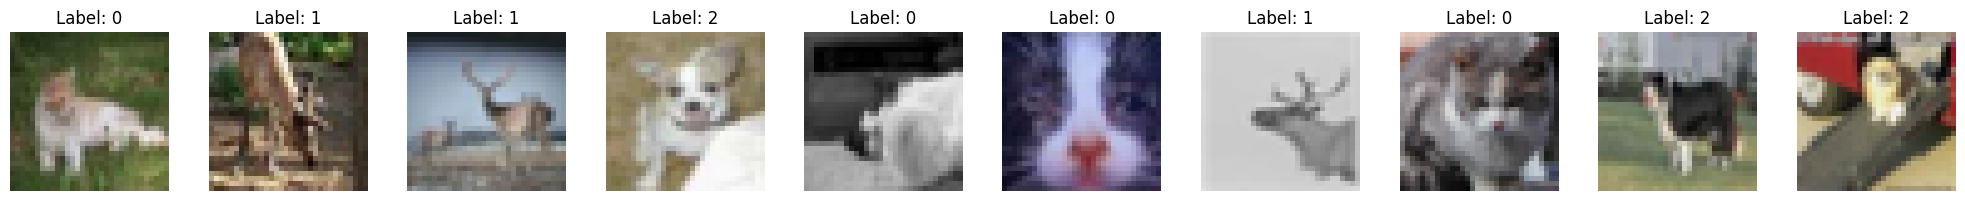

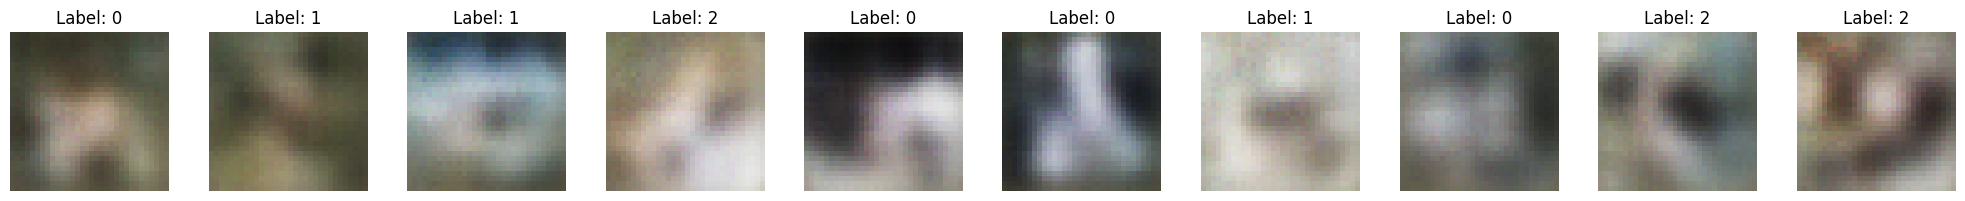

Memory cached in GPU: 0

Training Epoch: [38 | 80] LR: 0.000500
[epoch: 38] (59/59) | Loss: 0.0141 |


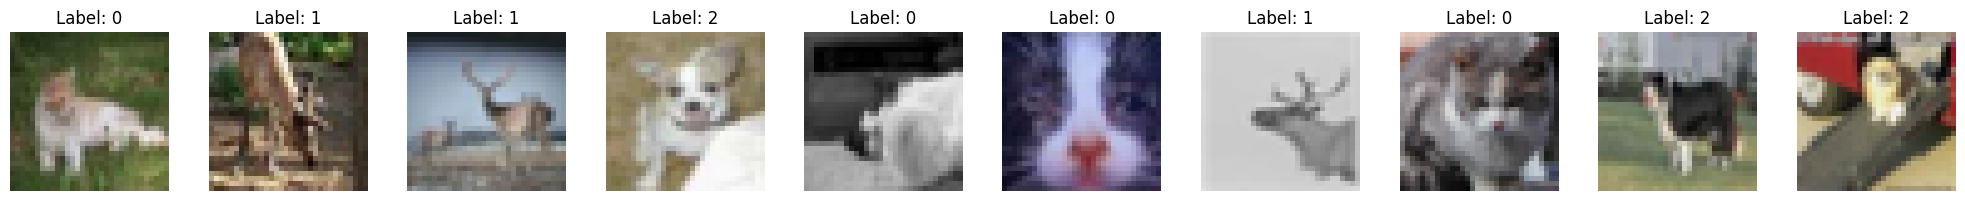

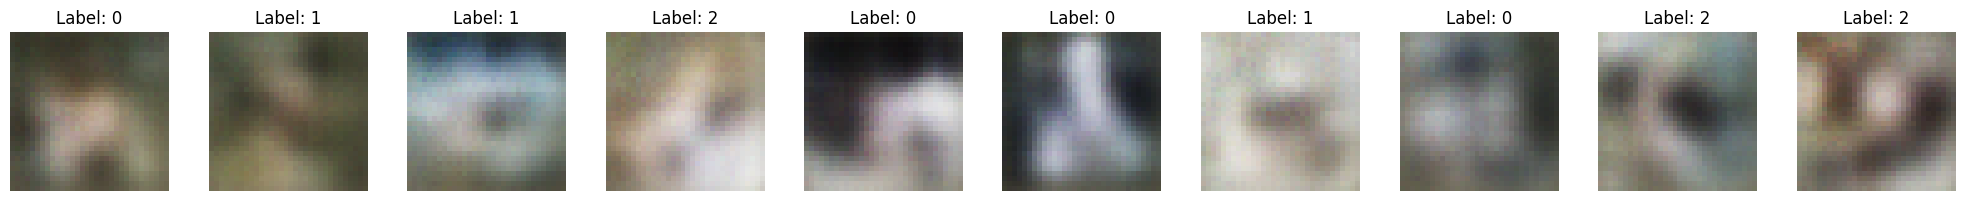

Memory cached in GPU: 0

Training Epoch: [39 | 80] LR: 0.000500
[epoch: 39] (59/59) | Loss: 0.0140 |


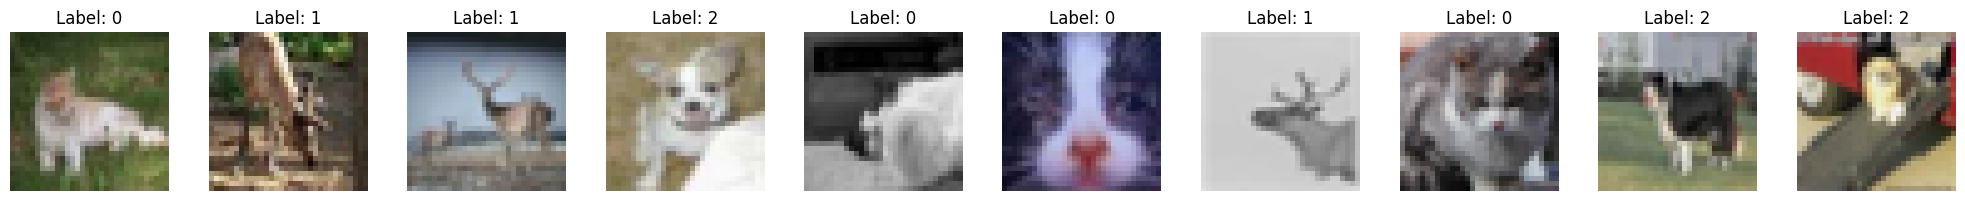

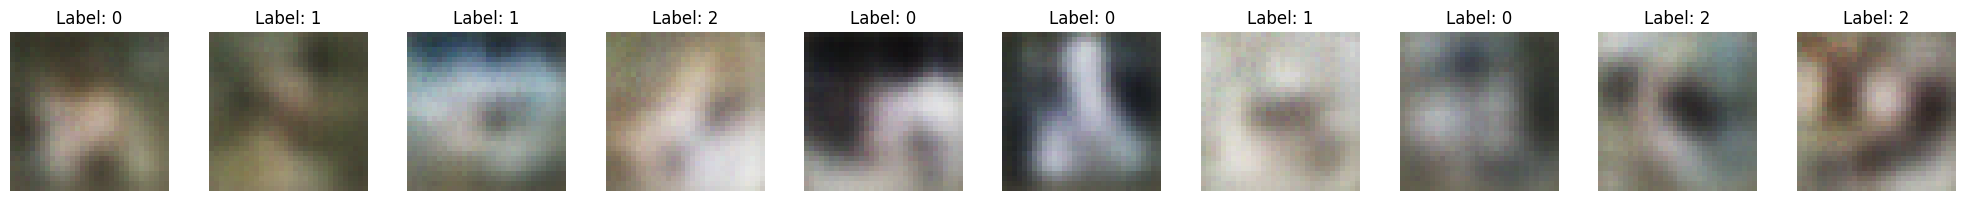

Memory cached in GPU: 0

Training Epoch: [40 | 80] LR: 0.000500
[epoch: 40] (59/59) | Loss: 0.0140 |


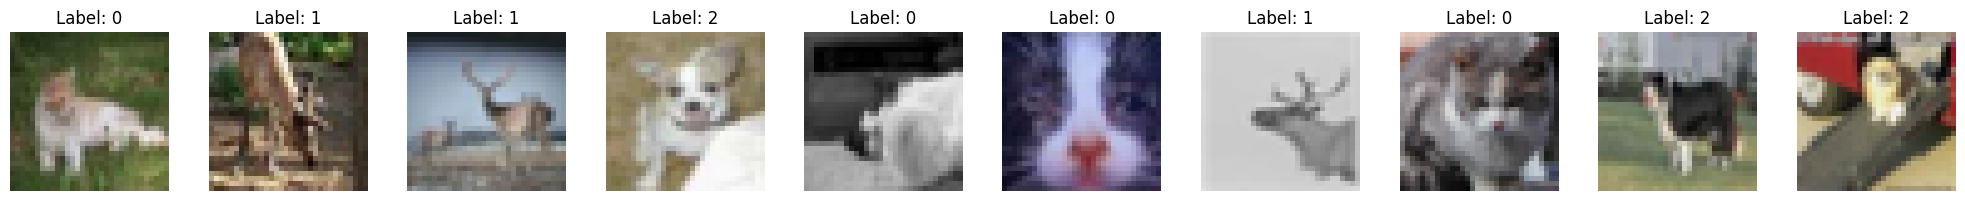

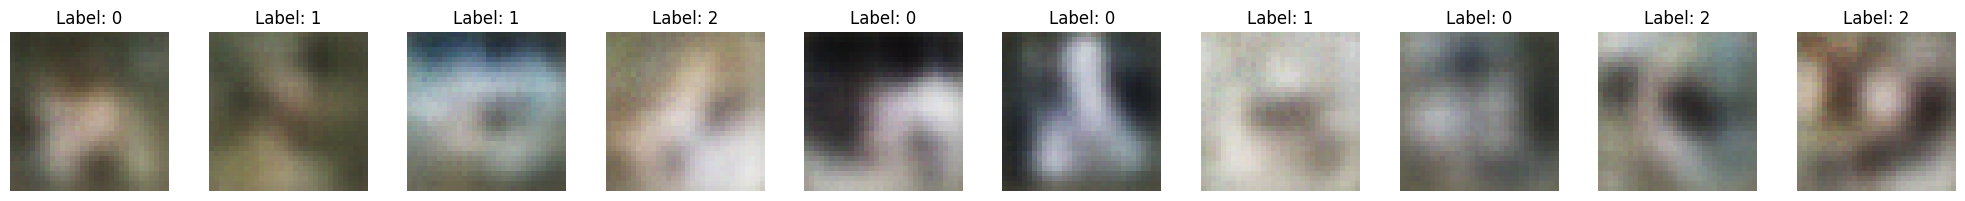

Memory cached in GPU: 0

Training Epoch: [41 | 80] LR: 0.000500
[epoch: 41] (59/59) | Loss: 0.0140 |


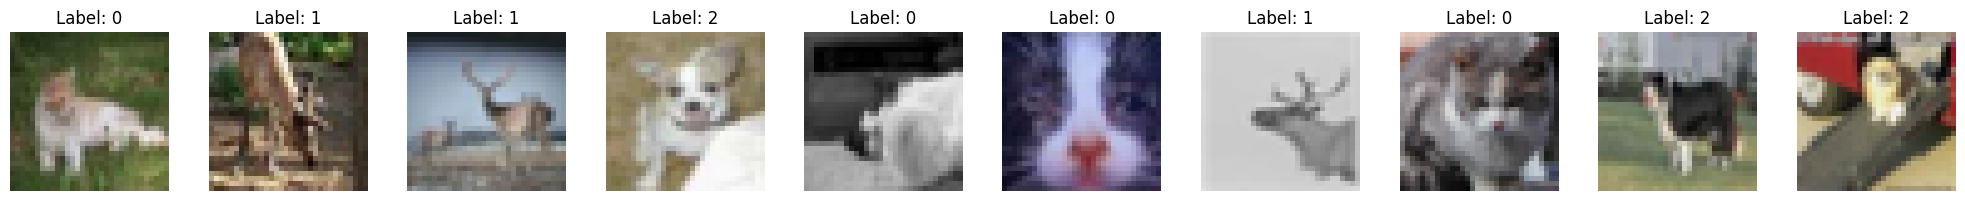

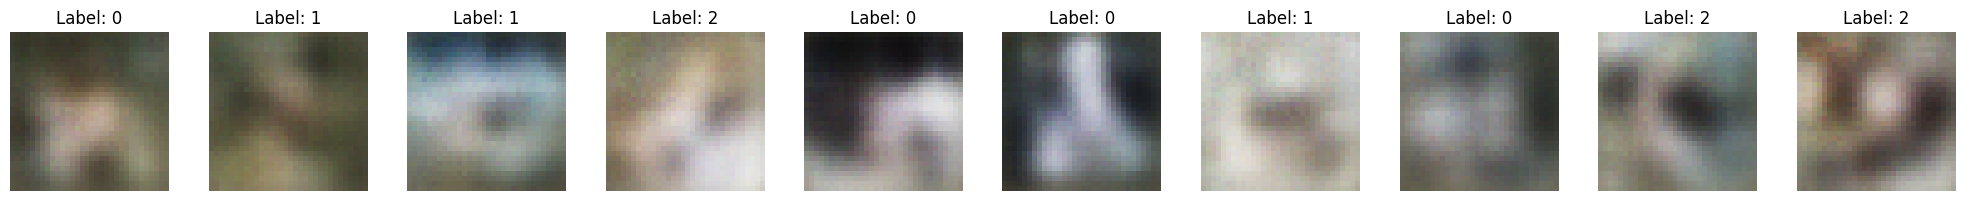

Memory cached in GPU: 0

Training Epoch: [42 | 80] LR: 0.000500
[epoch: 42] (59/59) | Loss: 0.0140 |


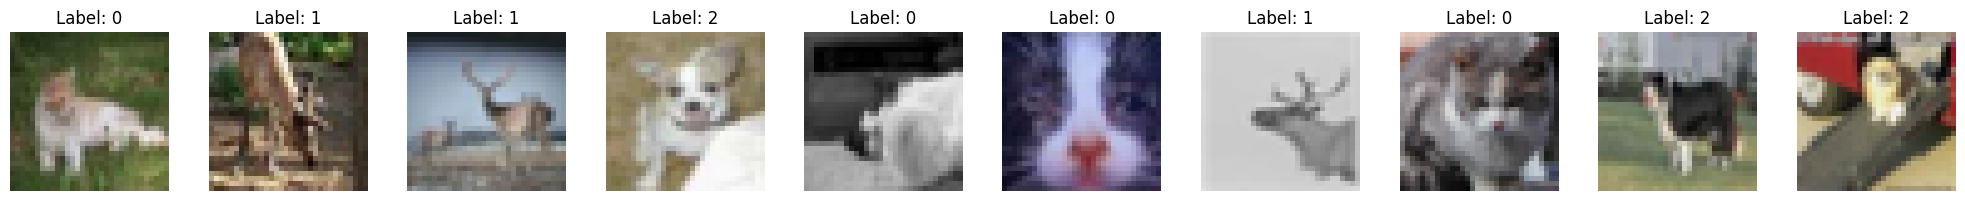

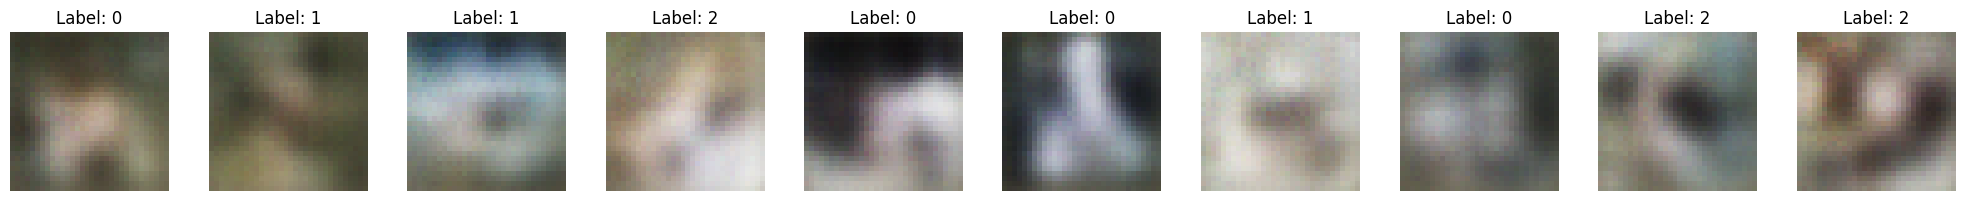

Memory cached in GPU: 0

Training Epoch: [43 | 80] LR: 0.000500
[epoch: 43] (59/59) | Loss: 0.0140 |


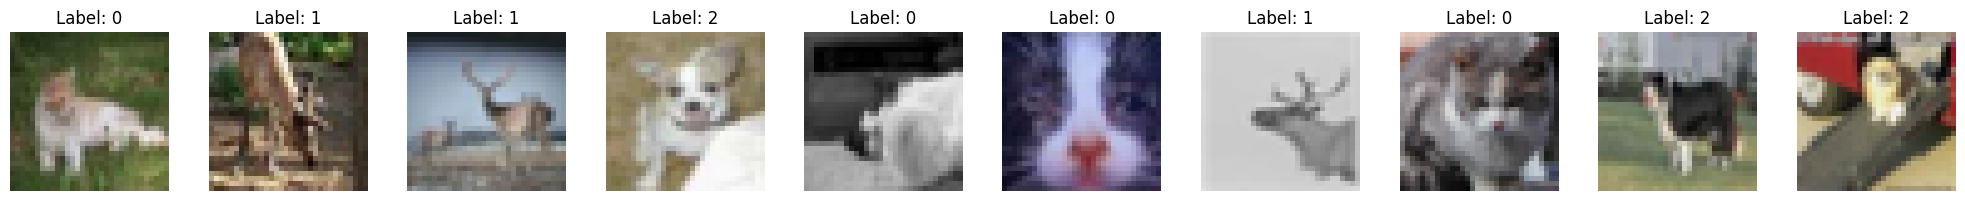

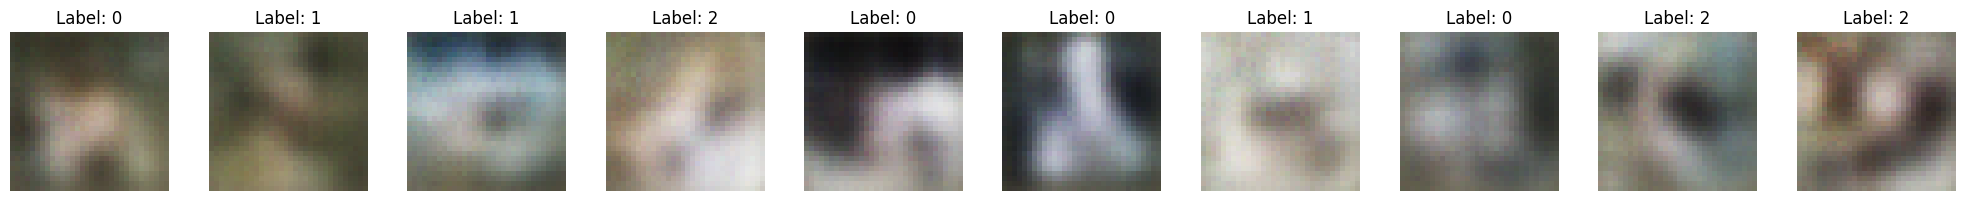

Memory cached in GPU: 0

Training Epoch: [44 | 80] LR: 0.000500
[epoch: 44] (59/59) | Loss: 0.0140 |


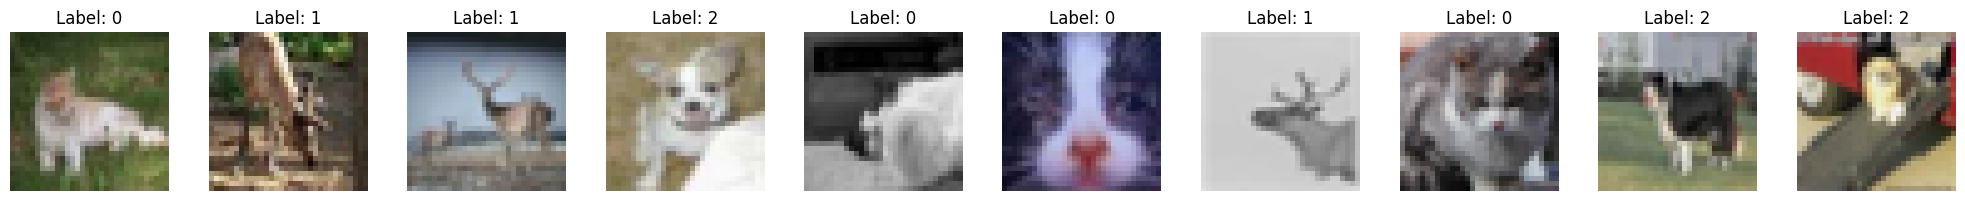

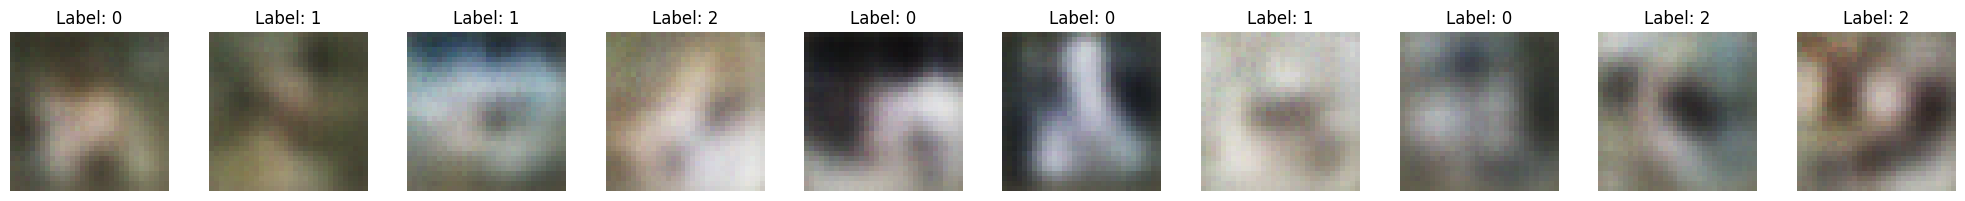

Memory cached in GPU: 0

Training Epoch: [45 | 80] LR: 0.000500
[epoch: 45] (59/59) | Loss: 0.0140 |


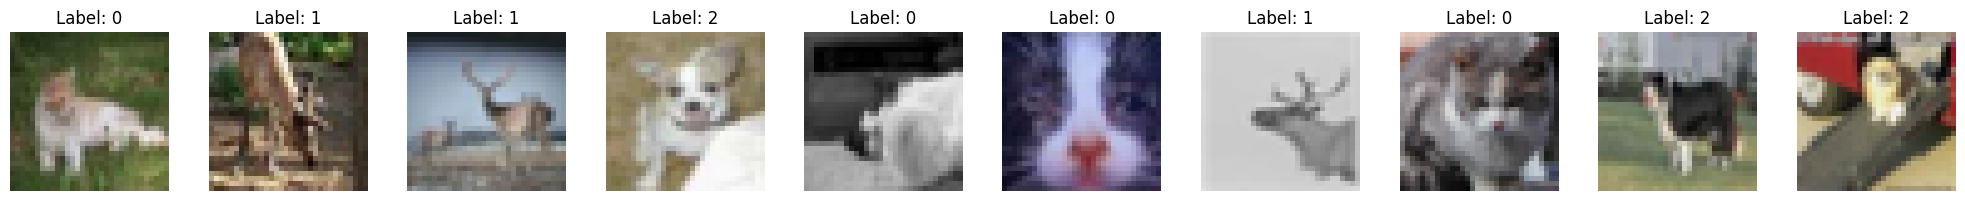

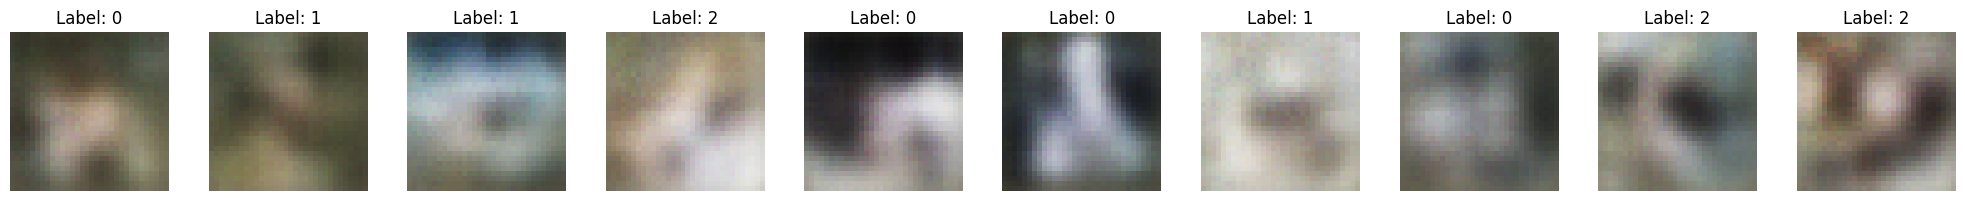

Memory cached in GPU: 0

Training Epoch: [46 | 80] LR: 0.000500
[epoch: 46] (59/59) | Loss: 0.0140 |


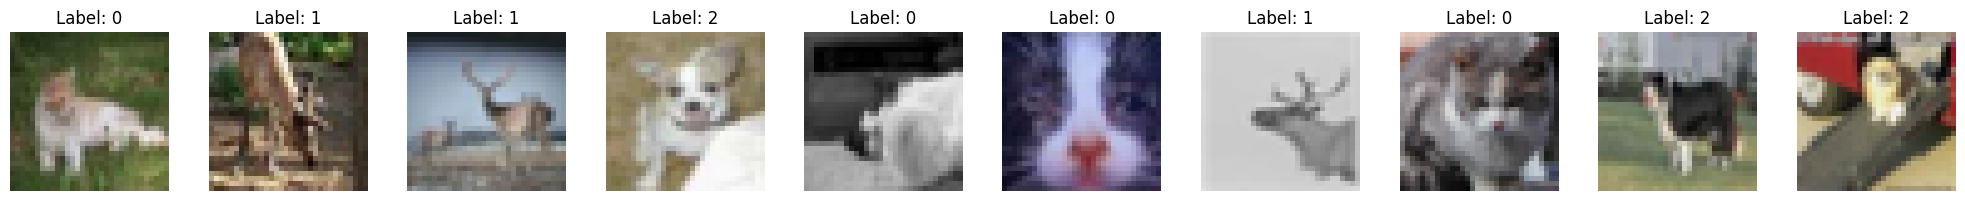

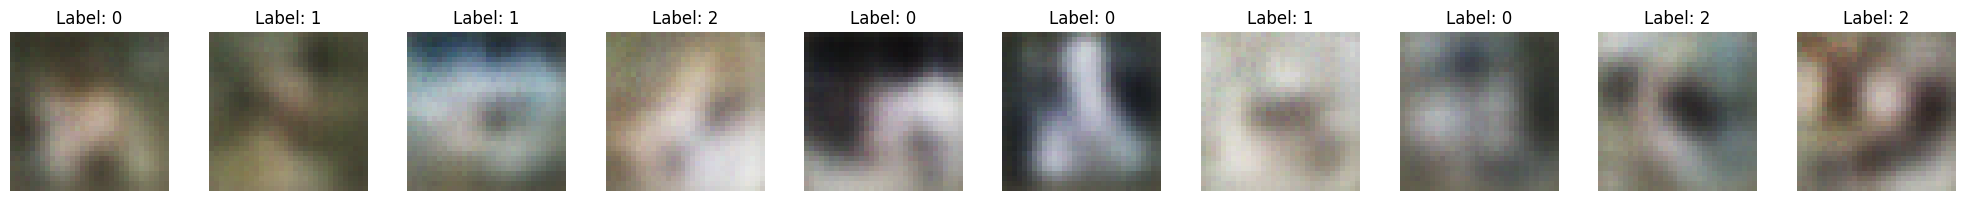

Memory cached in GPU: 0

Training Epoch: [47 | 80] LR: 0.000500
[epoch: 47] (59/59) | Loss: 0.0140 |


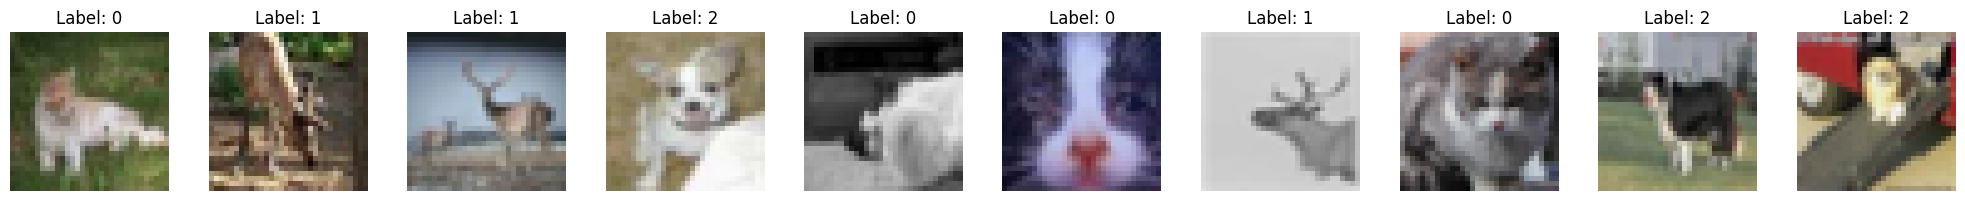

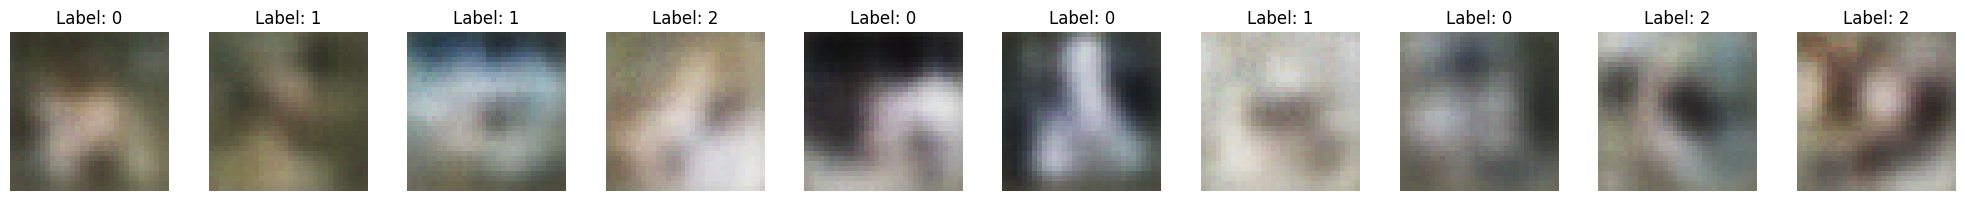

Memory cached in GPU: 0

Training Epoch: [48 | 80] LR: 0.000500
[epoch: 48] (59/59) | Loss: 0.0140 |


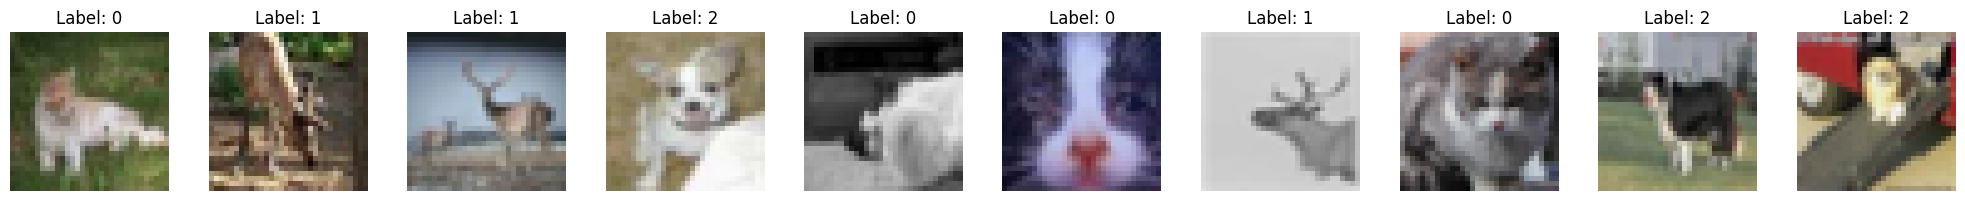

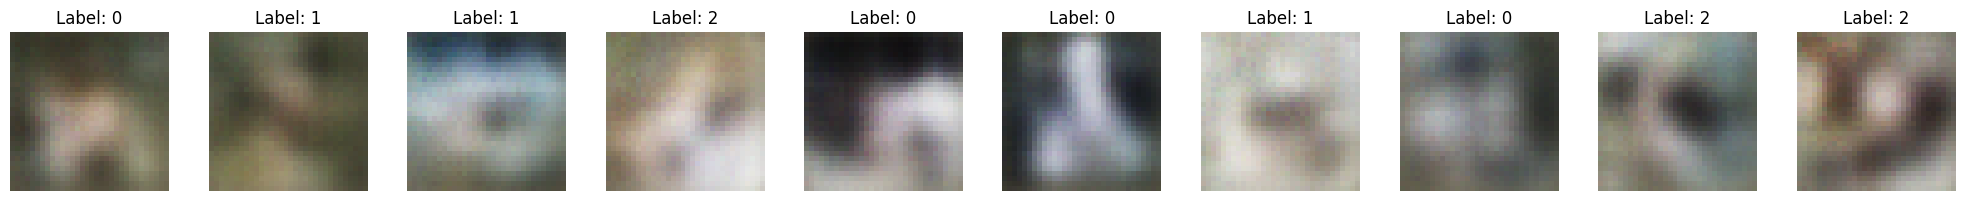

Memory cached in GPU: 0

Training Epoch: [49 | 80] LR: 0.000500
[epoch: 49] (59/59) | Loss: 0.0140 |


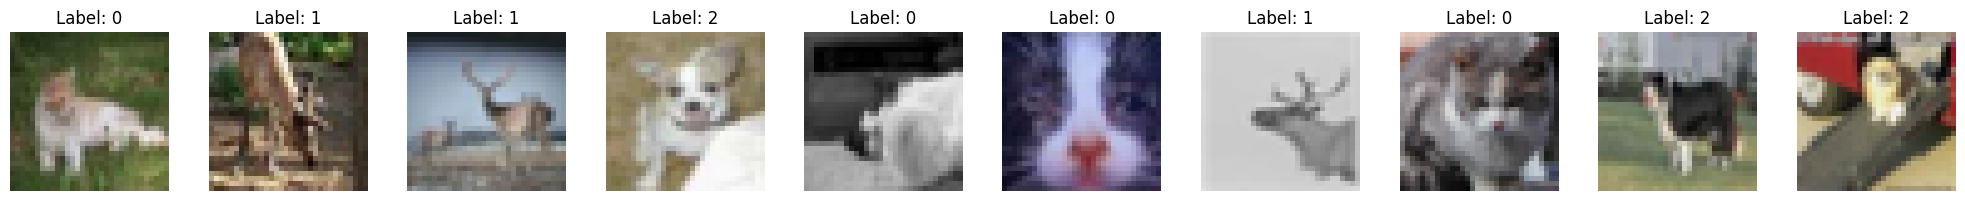

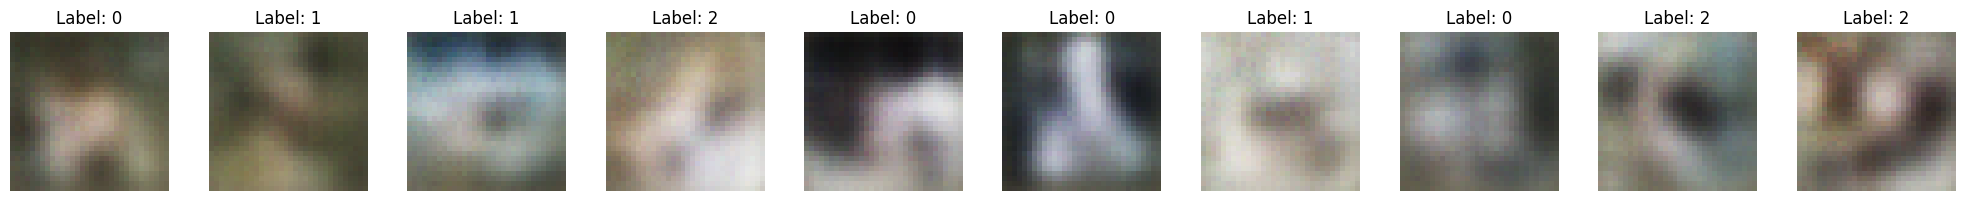

Memory cached in GPU: 0

Training Epoch: [50 | 80] LR: 0.000500
[epoch: 50] (59/59) | Loss: 0.0140 |


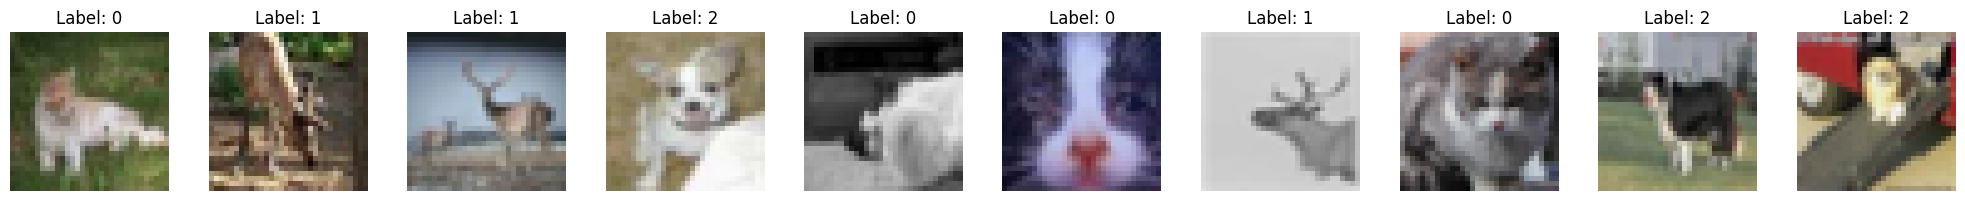

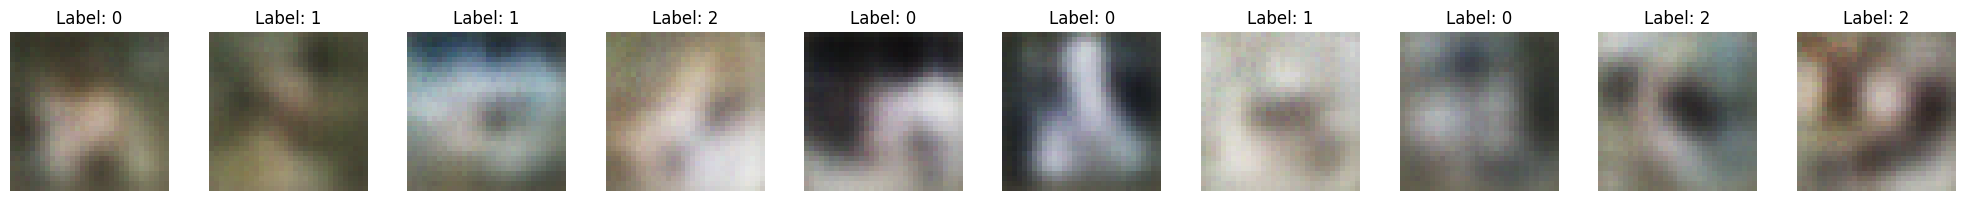

Memory cached in GPU: 0

Training Epoch: [51 | 80] LR: 0.000500
[epoch: 51] (59/59) | Loss: 0.0140 |


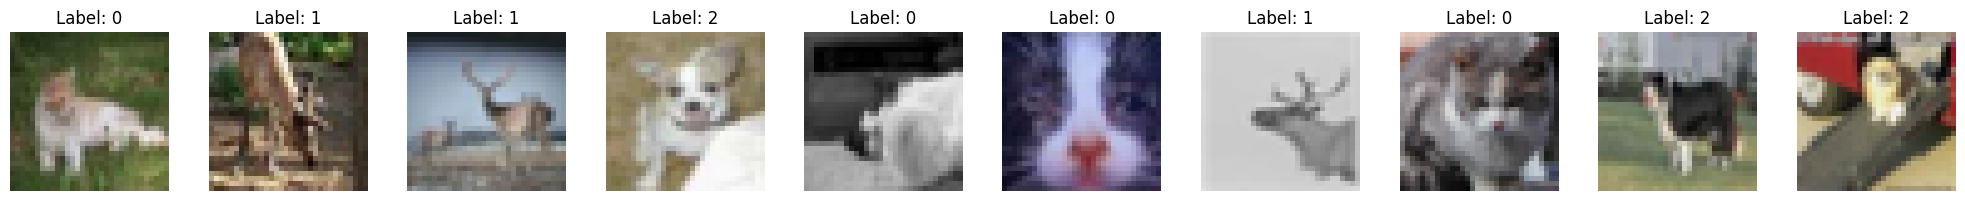

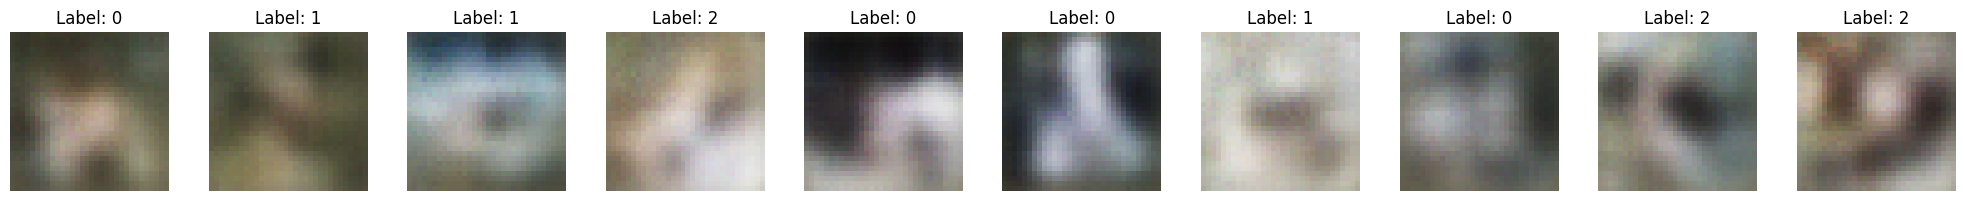

Memory cached in GPU: 0

Training Epoch: [52 | 80] LR: 0.000500
[epoch: 52] (59/59) | Loss: 0.0140 |


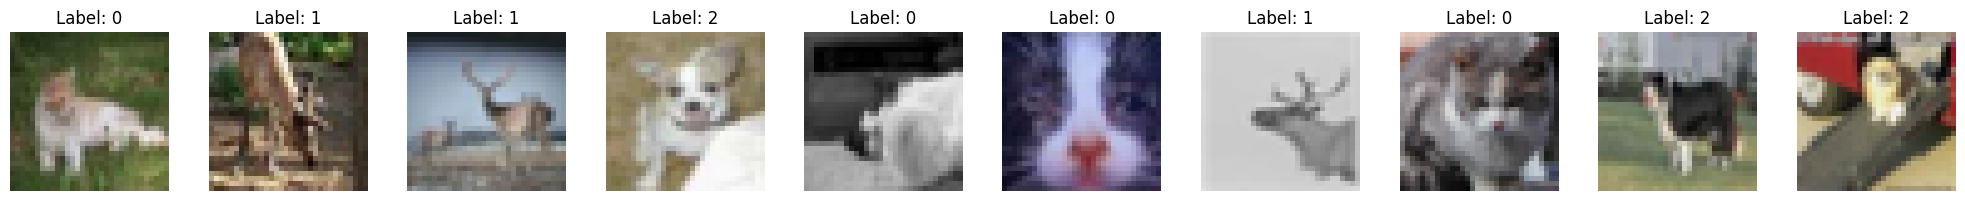

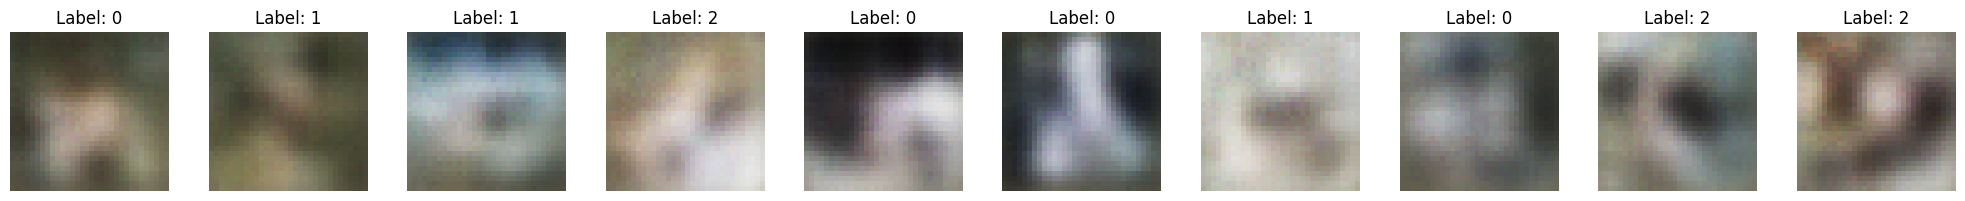

Memory cached in GPU: 0

Training Epoch: [53 | 80] LR: 0.000500
[epoch: 53] (59/59) | Loss: 0.0140 |


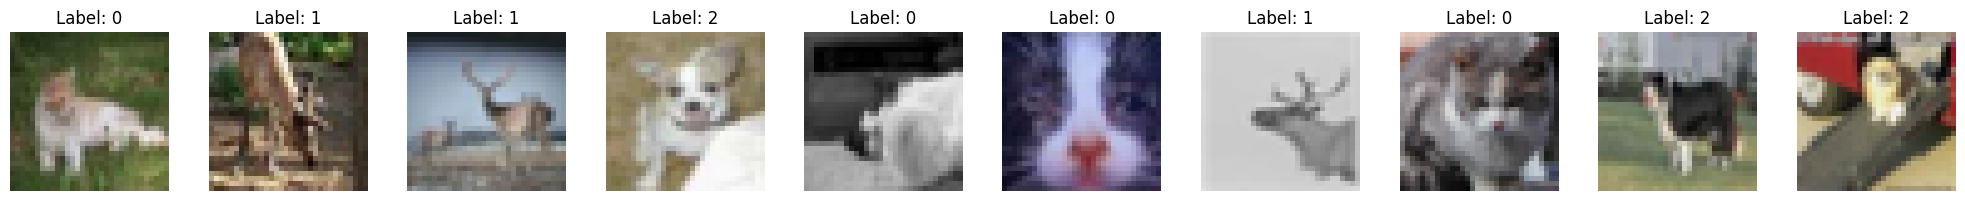

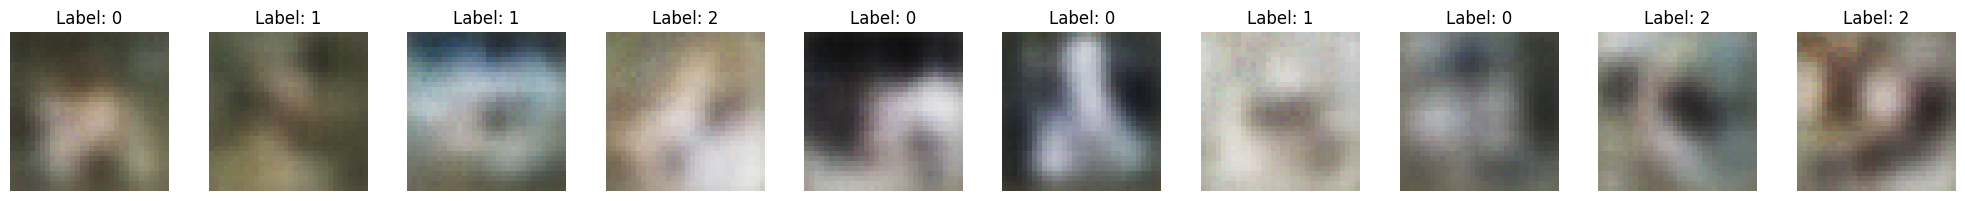

Memory cached in GPU: 0

Training Epoch: [54 | 80] LR: 0.000500
[epoch: 54] (59/59) | Loss: 0.0140 |


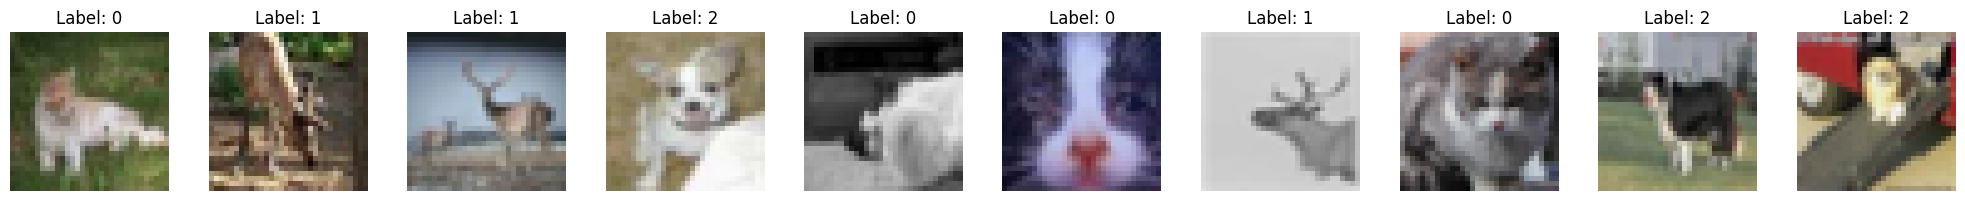

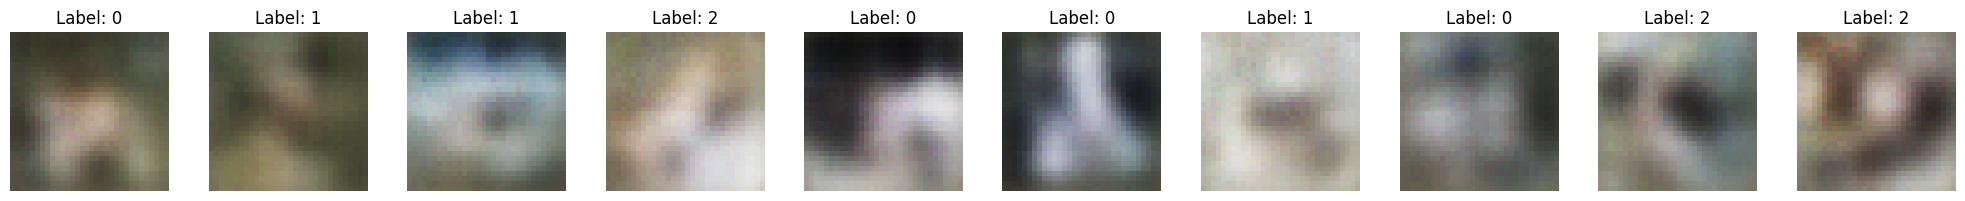

Memory cached in GPU: 0

Training Epoch: [55 | 80] LR: 0.000500
[epoch: 55] (59/59) | Loss: 0.0140 |


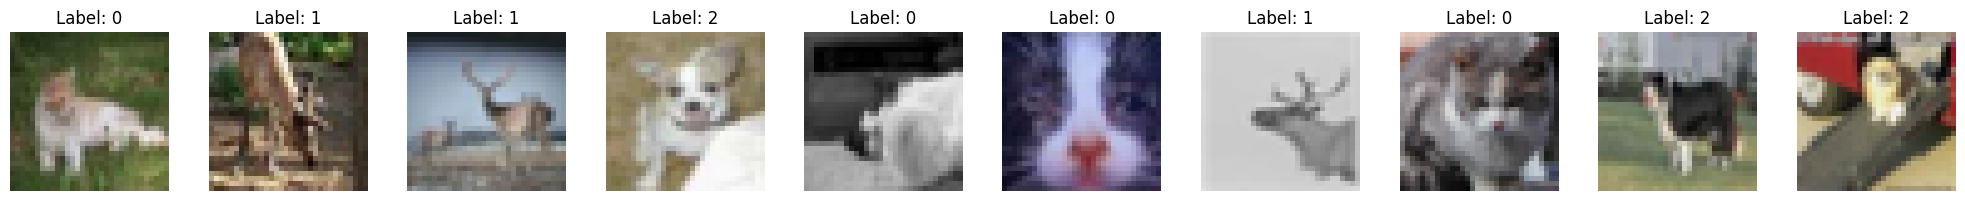

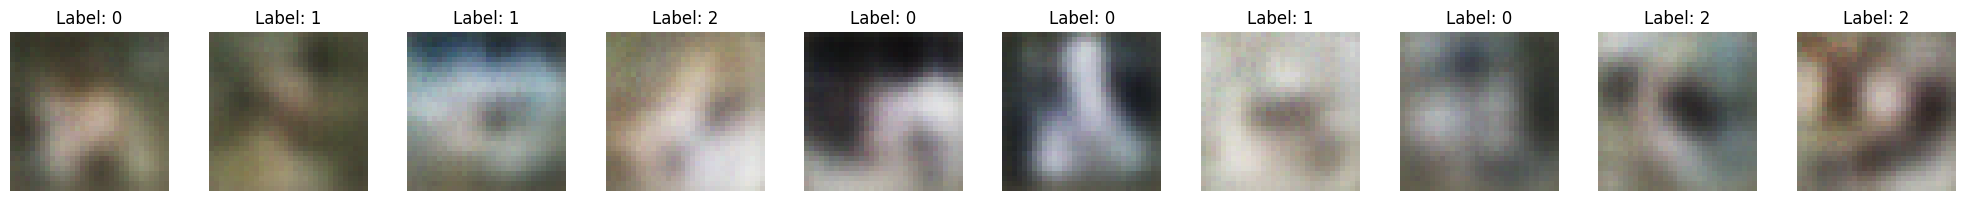

Memory cached in GPU: 0

Training Epoch: [56 | 80] LR: 0.000500
[epoch: 56] (59/59) | Loss: 0.0140 |


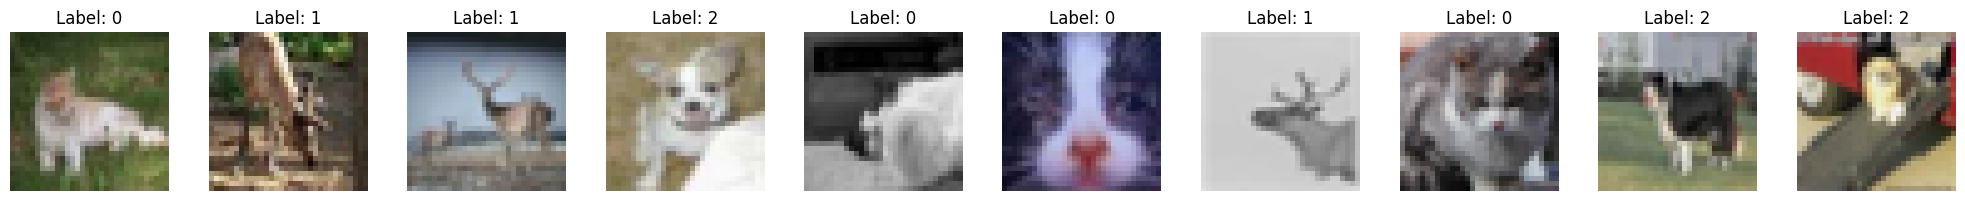

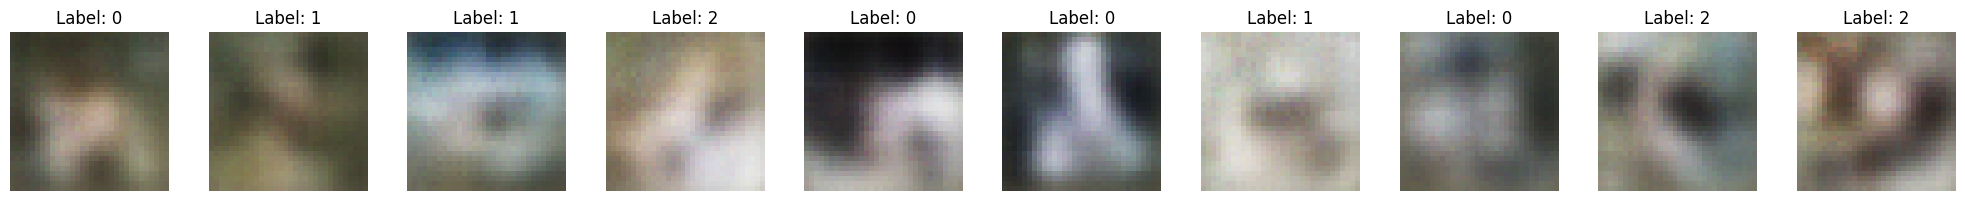

Memory cached in GPU: 0

Training Epoch: [57 | 80] LR: 0.000500
[epoch: 57] (59/59) | Loss: 0.0139 |


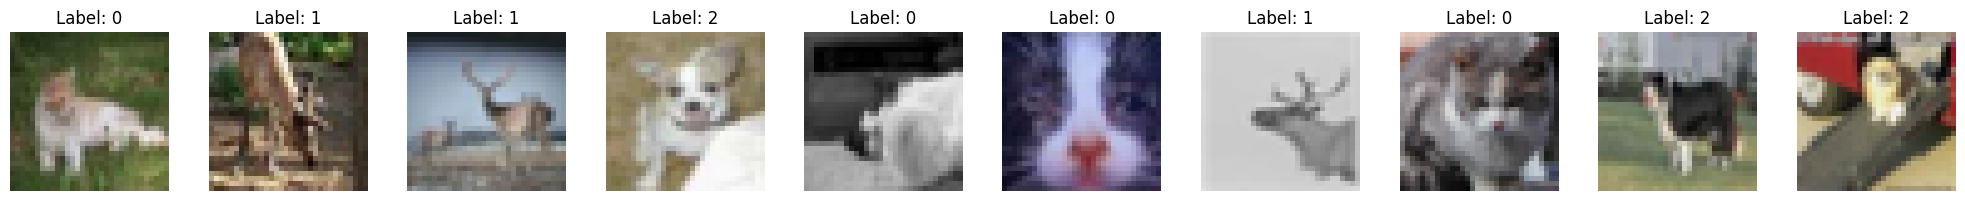

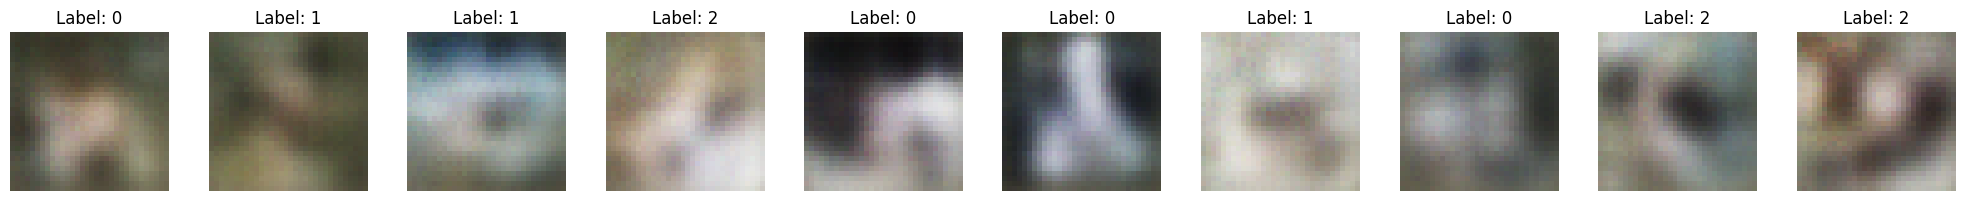

Memory cached in GPU: 0

Training Epoch: [58 | 80] LR: 0.000500
[epoch: 58] (59/59) | Loss: 0.0139 |


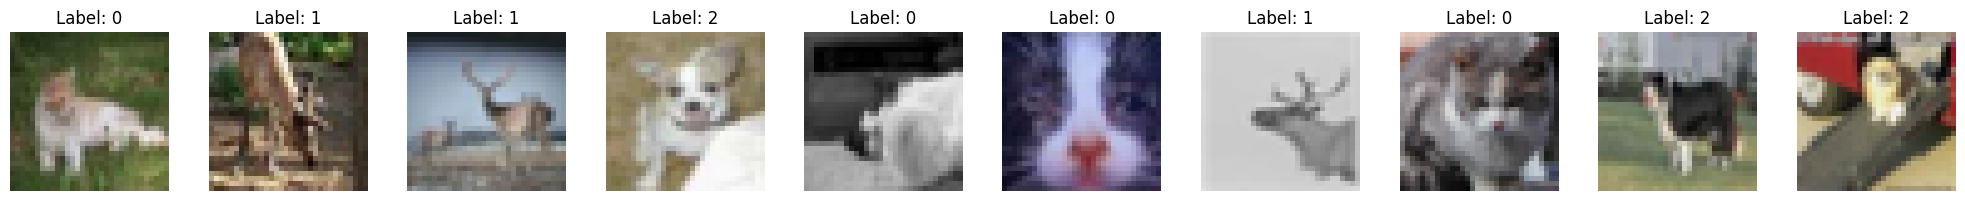

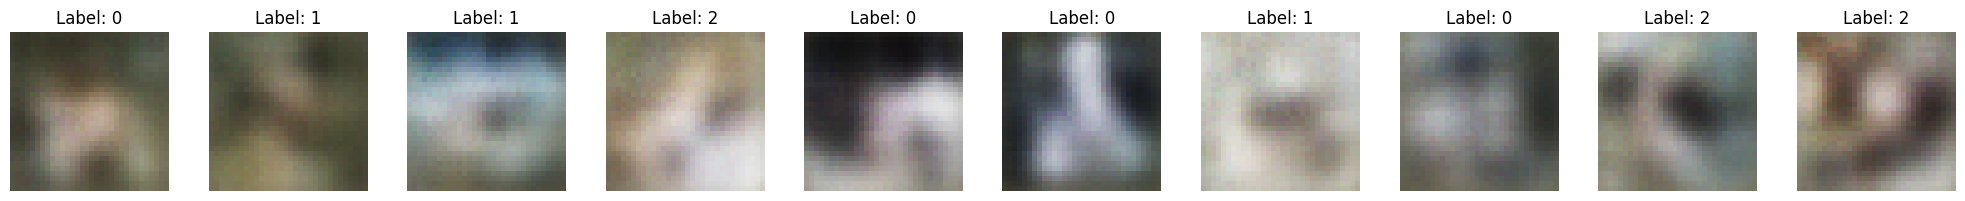

Memory cached in GPU: 0

Training Epoch: [59 | 80] LR: 0.000500
[epoch: 59] (59/59) | Loss: 0.0139 |


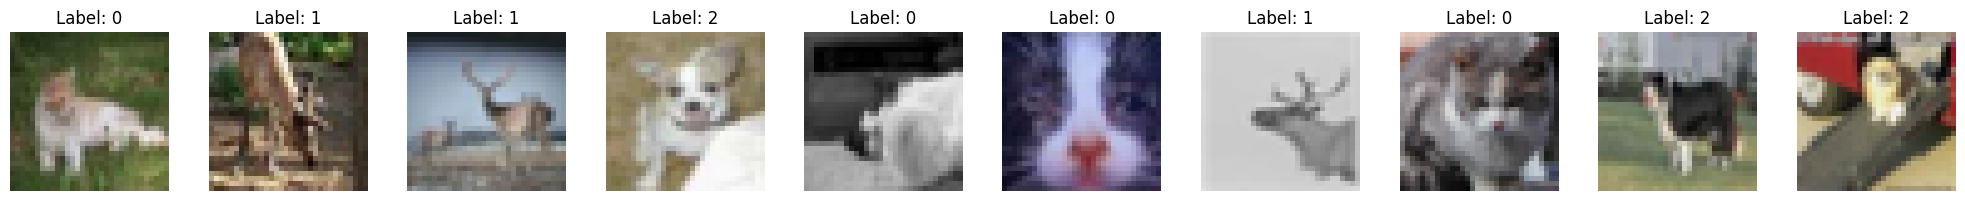

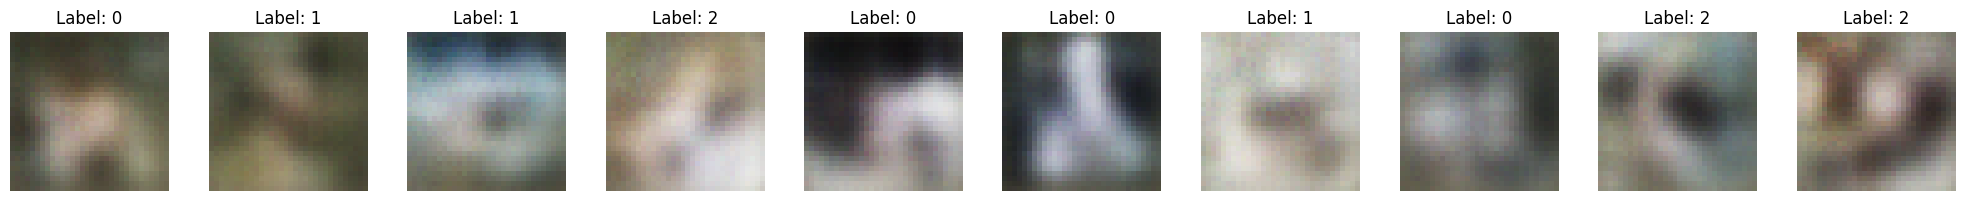

Memory cached in GPU: 0

Training Epoch: [60 | 80] LR: 0.000500
[epoch: 60] (59/59) | Loss: 0.0139 |


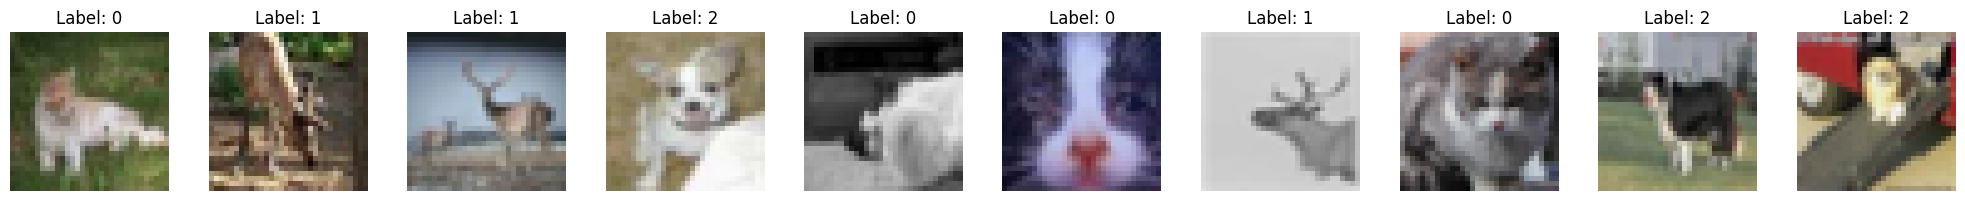

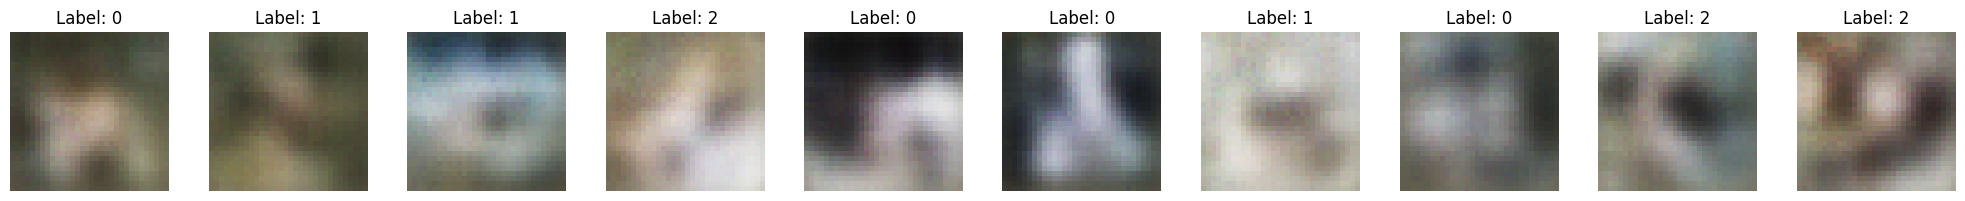

Memory cached in GPU: 0

Training Epoch: [61 | 80] LR: 0.000500
[epoch: 61] (59/59) | Loss: 0.0139 |


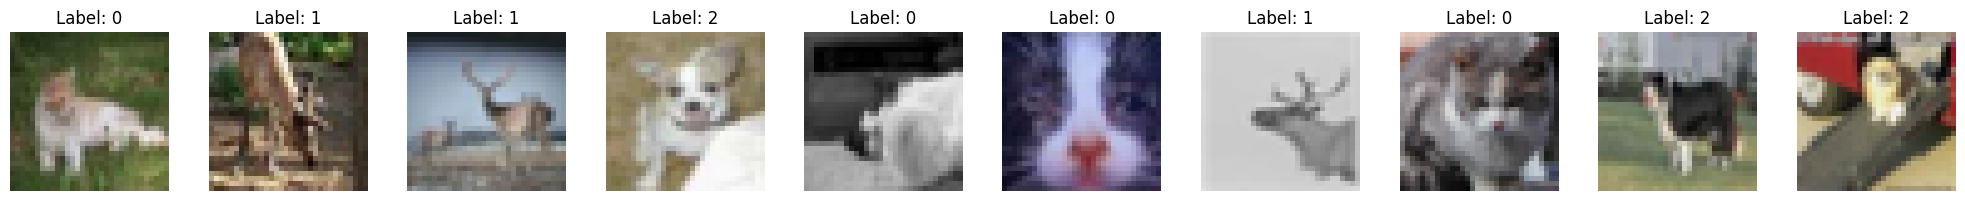

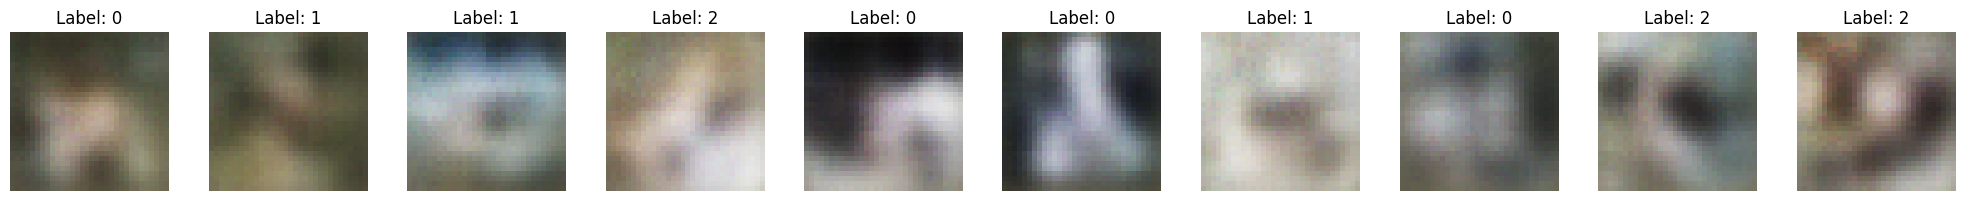

Memory cached in GPU: 0

Training Epoch: [62 | 80] LR: 0.000500
[epoch: 62] (59/59) | Loss: 0.0139 |


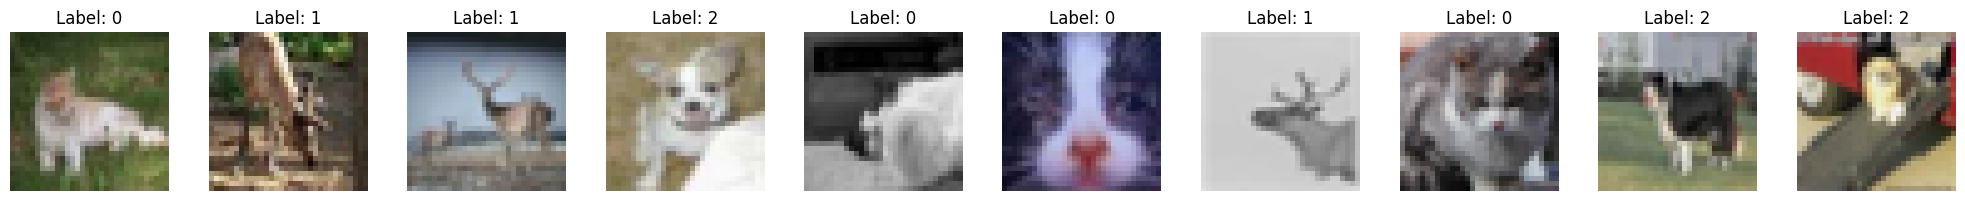

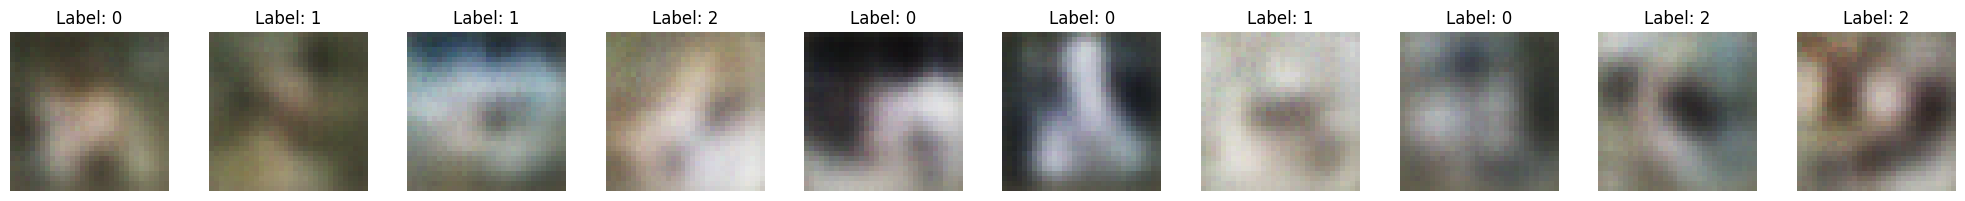

Memory cached in GPU: 0

Training Epoch: [63 | 80] LR: 0.000500
[epoch: 63] (59/59) | Loss: 0.0139 |


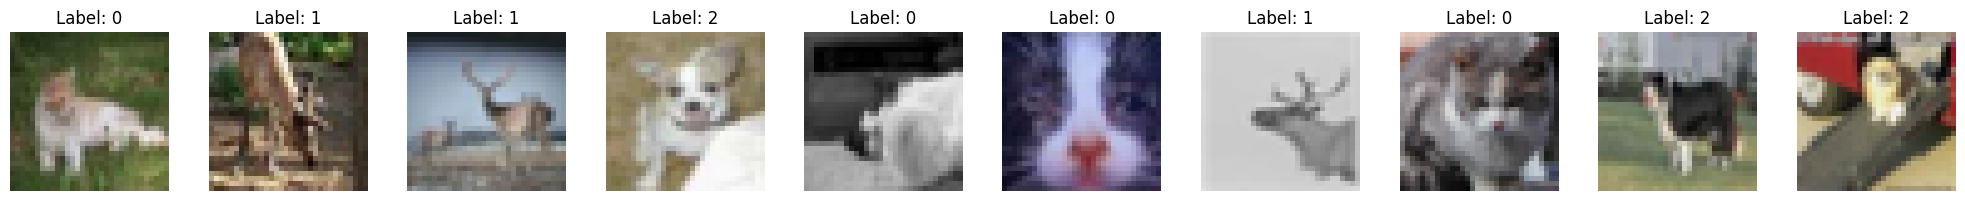

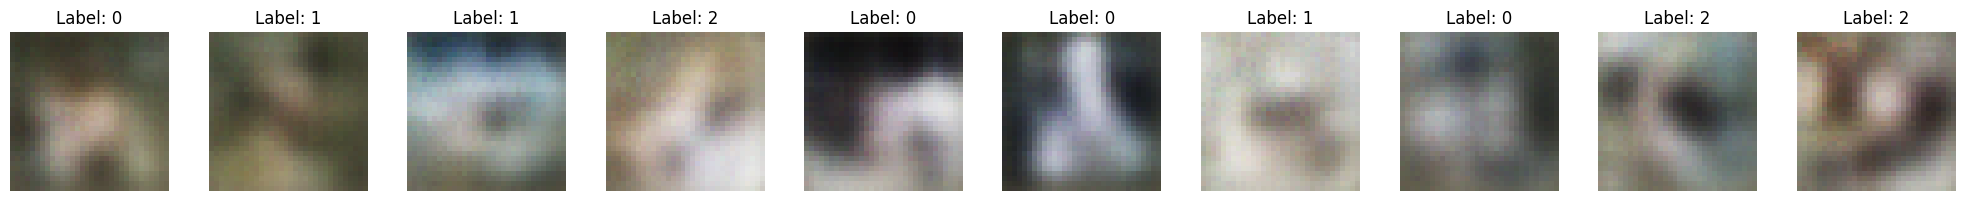

Memory cached in GPU: 0

Training Epoch: [64 | 80] LR: 0.000500
[epoch: 64] (59/59) | Loss: 0.0139 |


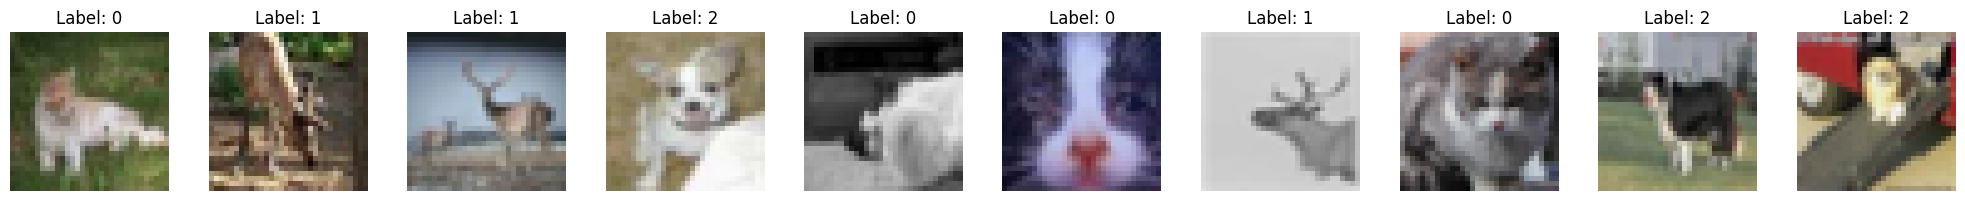

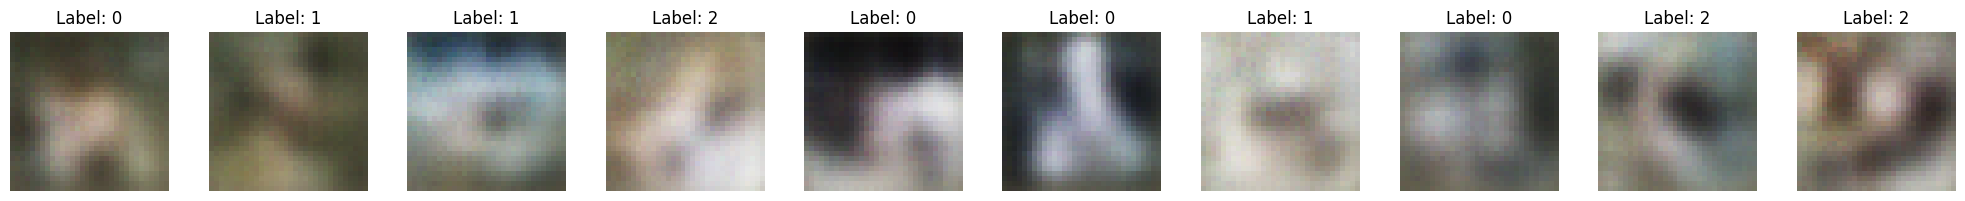

Memory cached in GPU: 0

Training Epoch: [65 | 80] LR: 0.000500
[epoch: 65] (59/59) | Loss: 0.0139 |


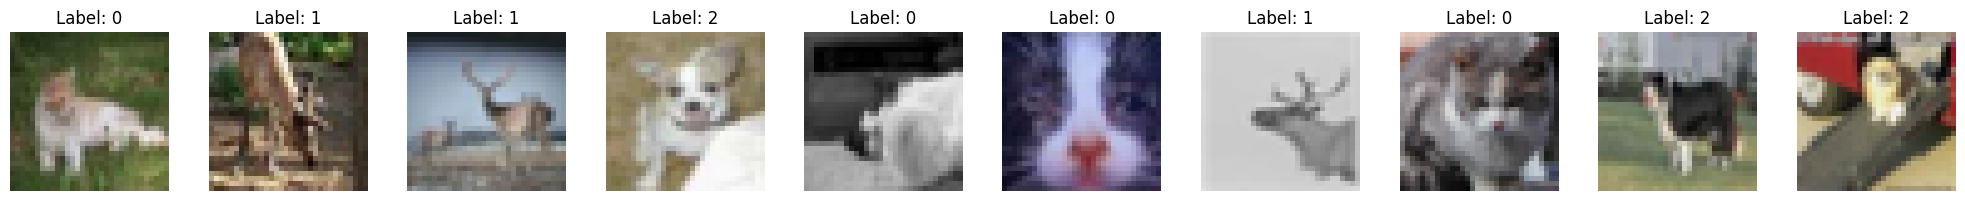

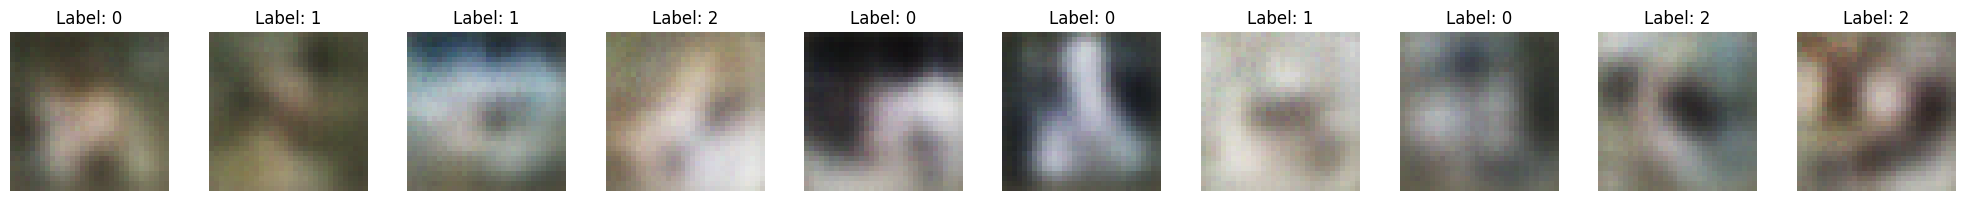

Memory cached in GPU: 0

Training Epoch: [66 | 80] LR: 0.000500
[epoch: 66] (59/59) | Loss: 0.0139 |


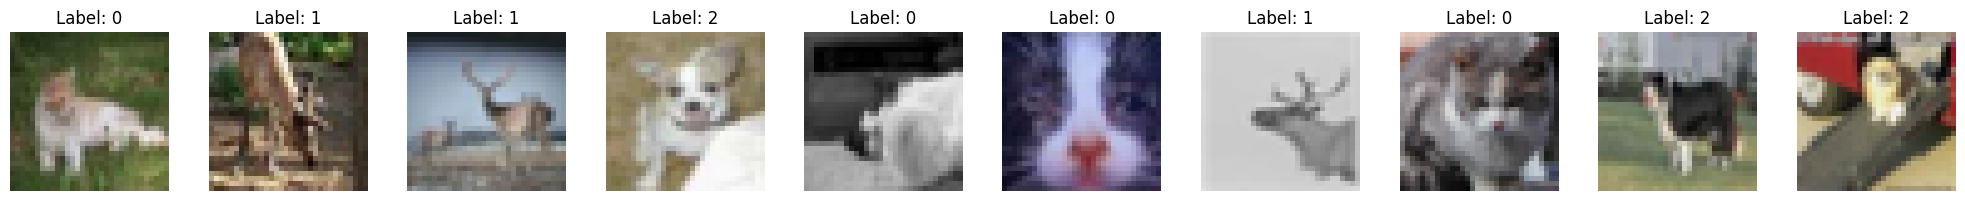

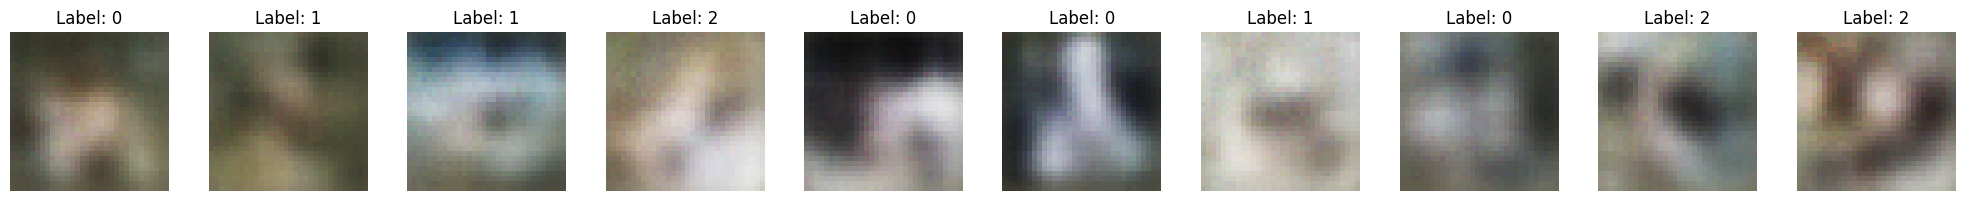

Memory cached in GPU: 0

Training Epoch: [67 | 80] LR: 0.000500
[epoch: 67] (59/59) | Loss: 0.0139 |


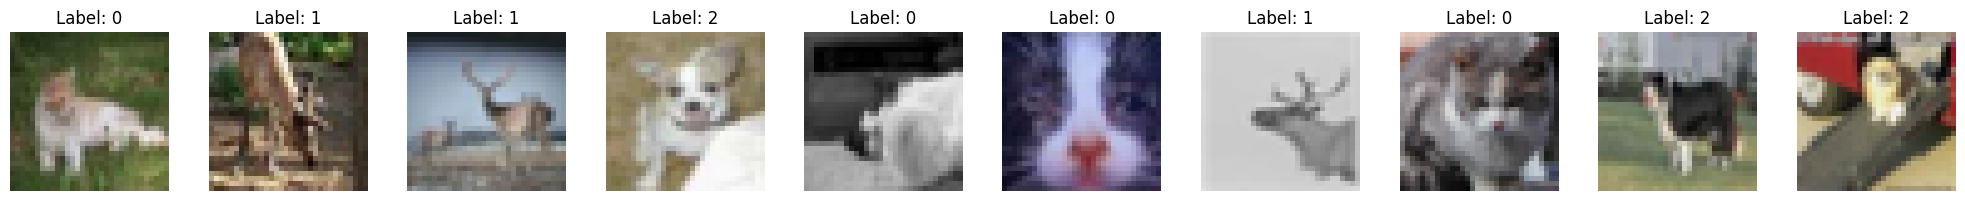

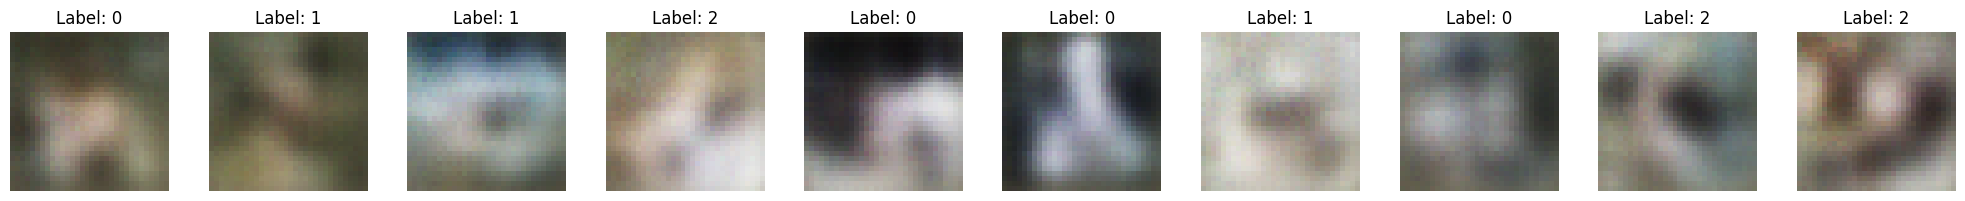

Memory cached in GPU: 0

Training Epoch: [68 | 80] LR: 0.000500
[epoch: 68] (59/59) | Loss: 0.0139 |


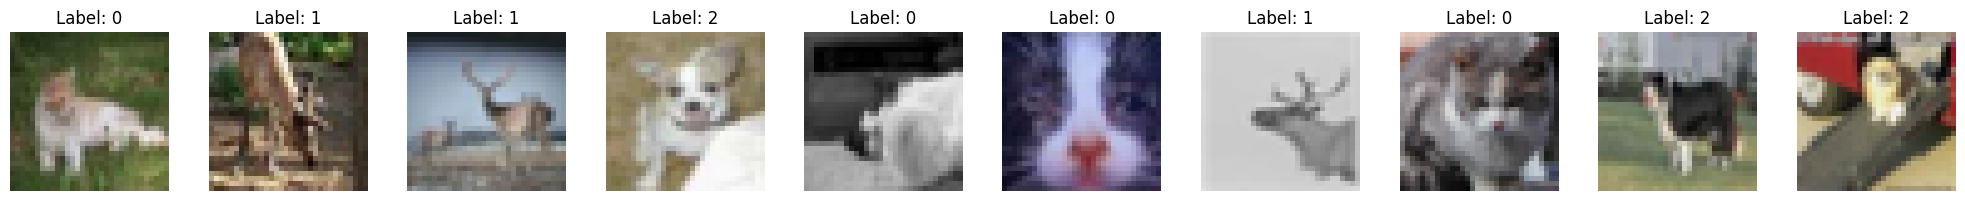

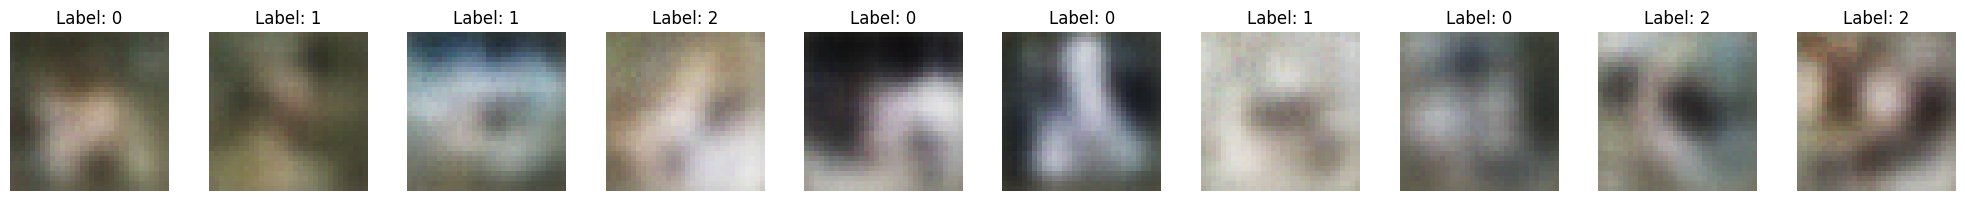

Memory cached in GPU: 0

Training Epoch: [69 | 80] LR: 0.000500
[epoch: 69] (59/59) | Loss: 0.0139 |


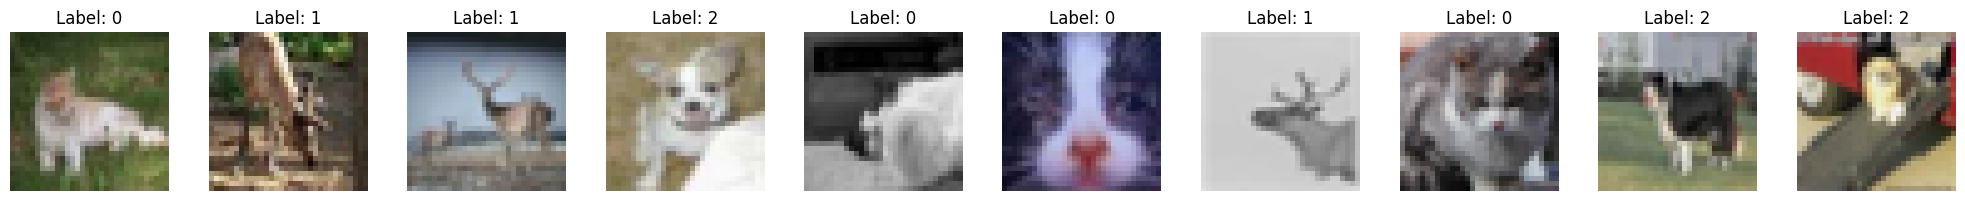

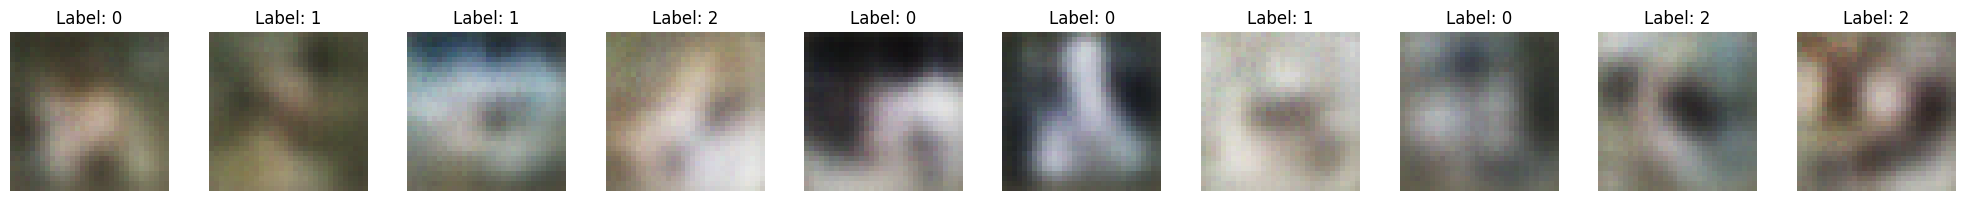

Memory cached in GPU: 0

Training Epoch: [70 | 80] LR: 0.000500
[epoch: 70] (59/59) | Loss: 0.0139 |


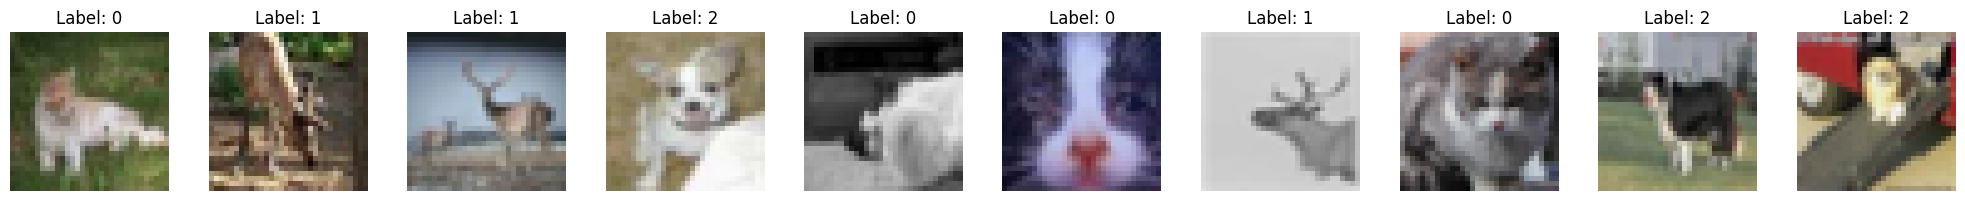

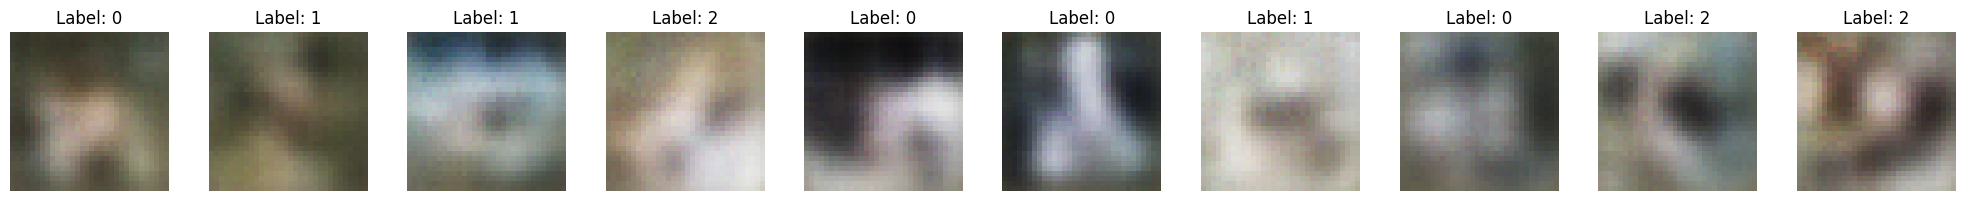

Memory cached in GPU: 0

Training Epoch: [71 | 80] LR: 0.000500
[epoch: 71] (59/59) | Loss: 0.0139 |


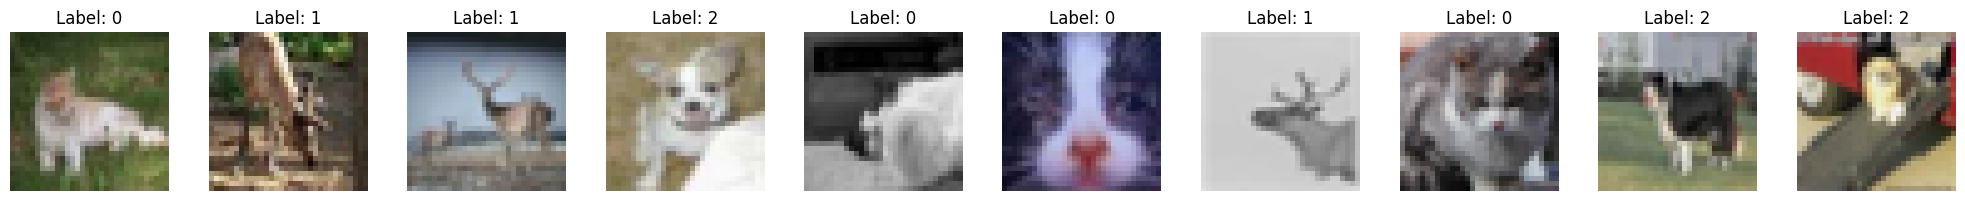

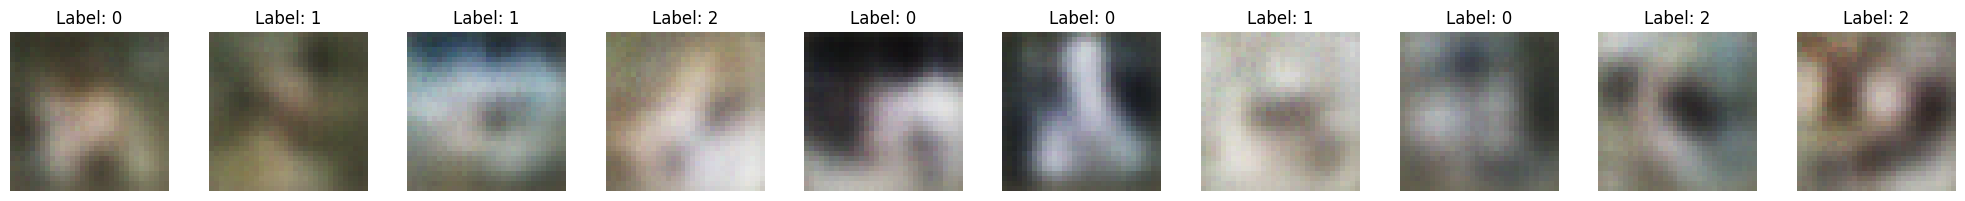

Memory cached in GPU: 0

Training Epoch: [72 | 80] LR: 0.000500
[epoch: 72] (59/59) | Loss: 0.0139 |


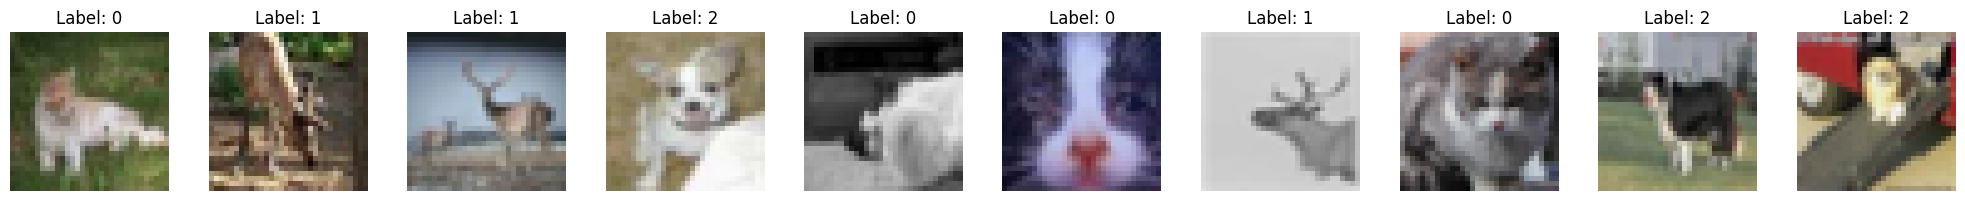

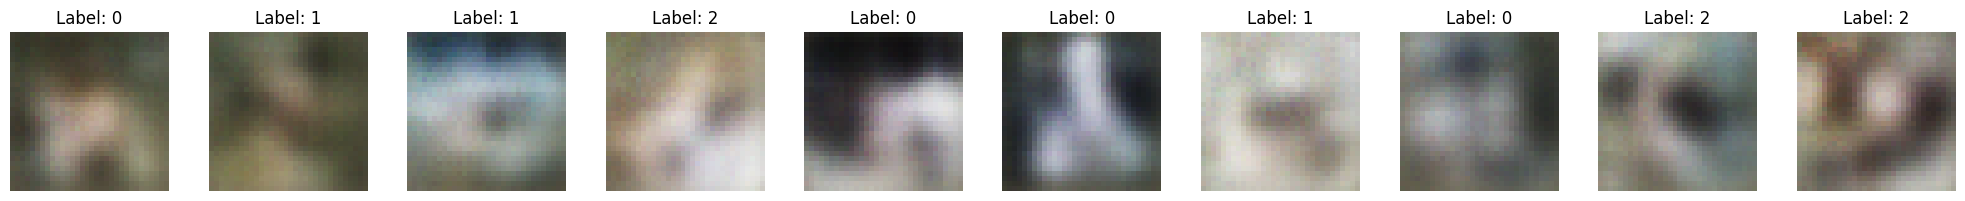

Memory cached in GPU: 0

Training Epoch: [73 | 80] LR: 0.000500
[epoch: 73] (59/59) | Loss: 0.0139 |


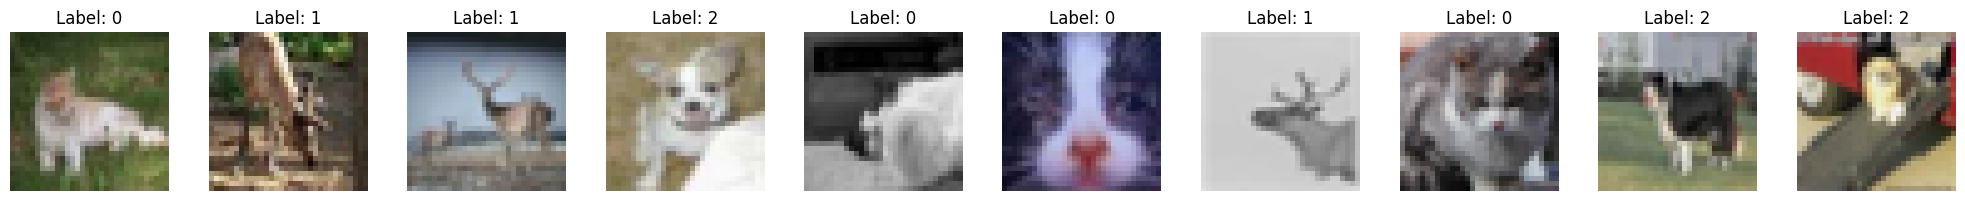

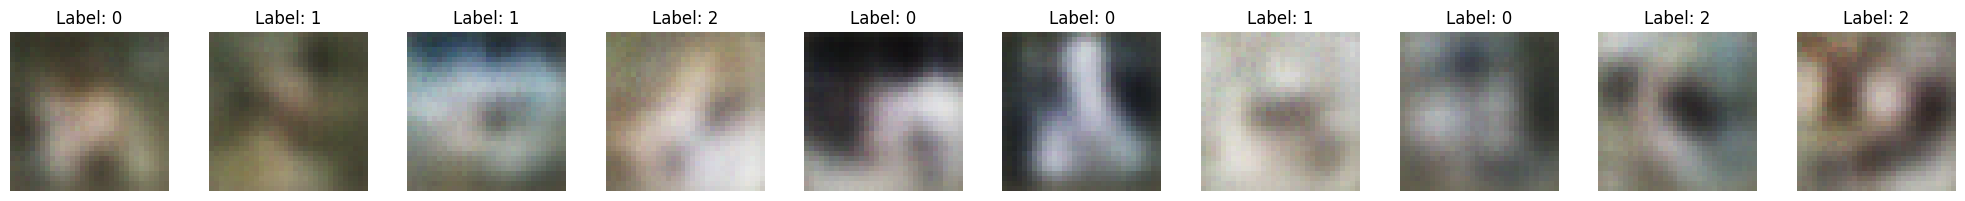

Memory cached in GPU: 0

Training Epoch: [74 | 80] LR: 0.000500
[epoch: 74] (59/59) | Loss: 0.0139 |


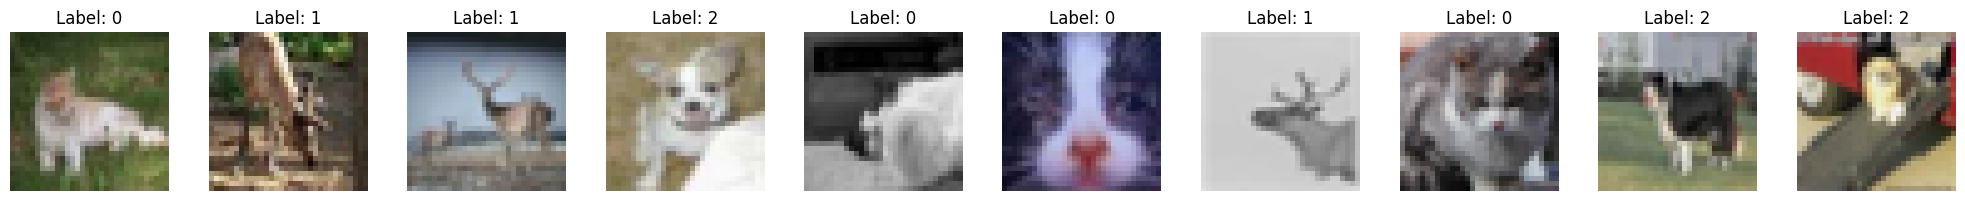

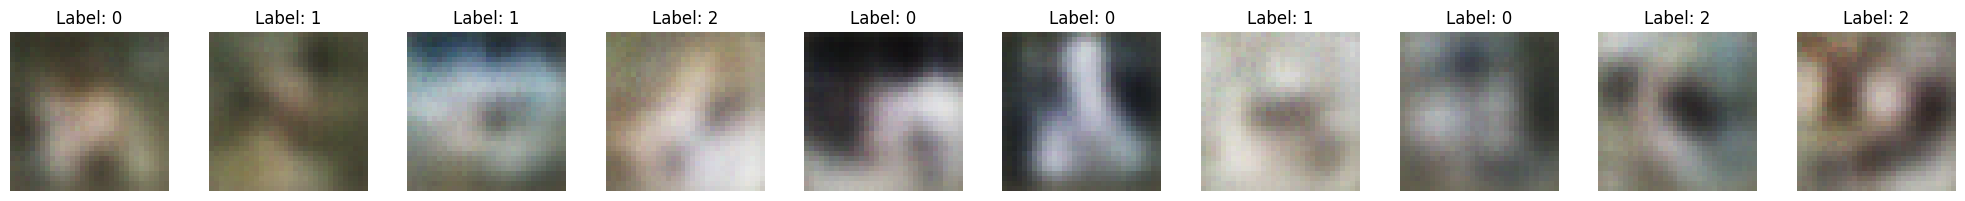

Memory cached in GPU: 0

Training Epoch: [75 | 80] LR: 0.000500
[epoch: 75] (59/59) | Loss: 0.0139 |


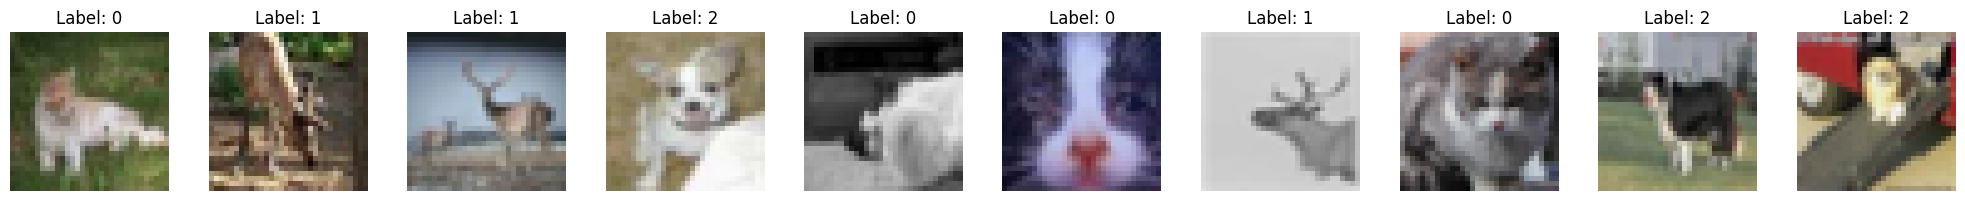

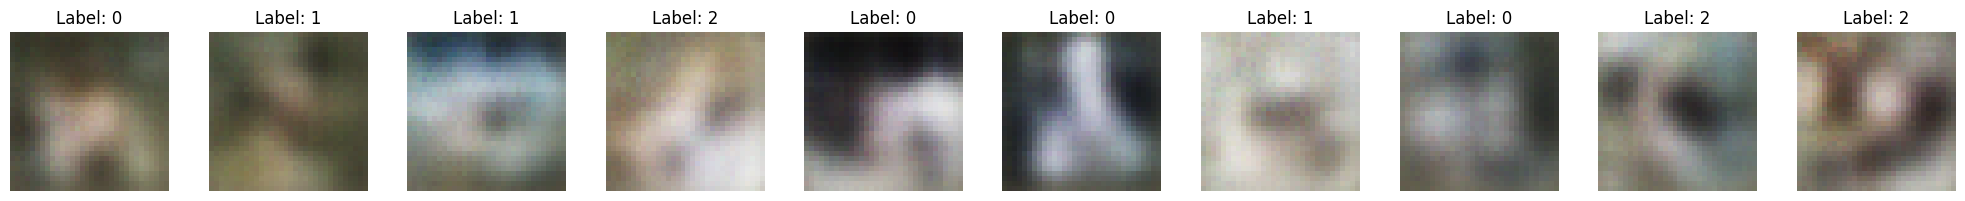

Memory cached in GPU: 0

Training Epoch: [76 | 80] LR: 0.000500
[epoch: 76] (59/59) | Loss: 0.0138 |


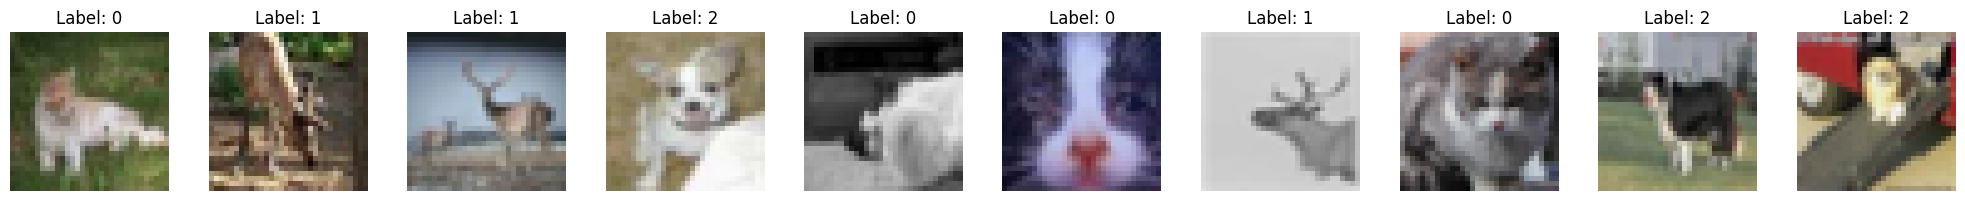

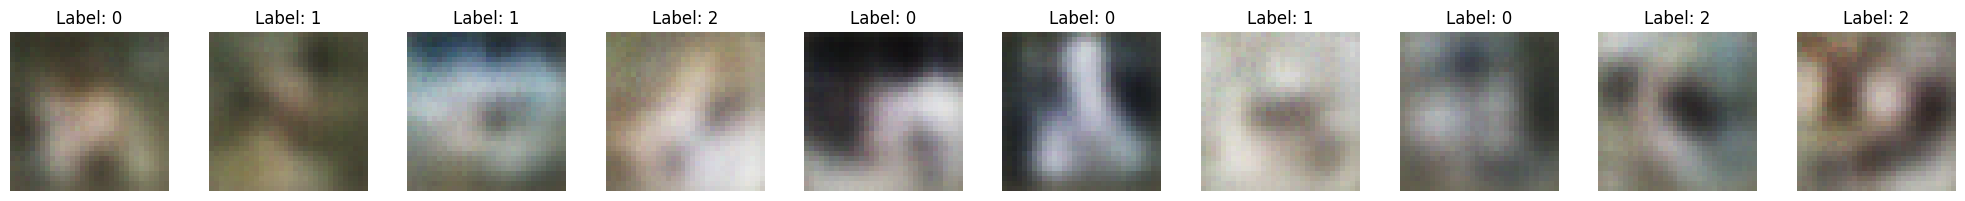

Memory cached in GPU: 0

Training Epoch: [77 | 80] LR: 0.000500
[epoch: 77] (59/59) | Loss: 0.0138 |


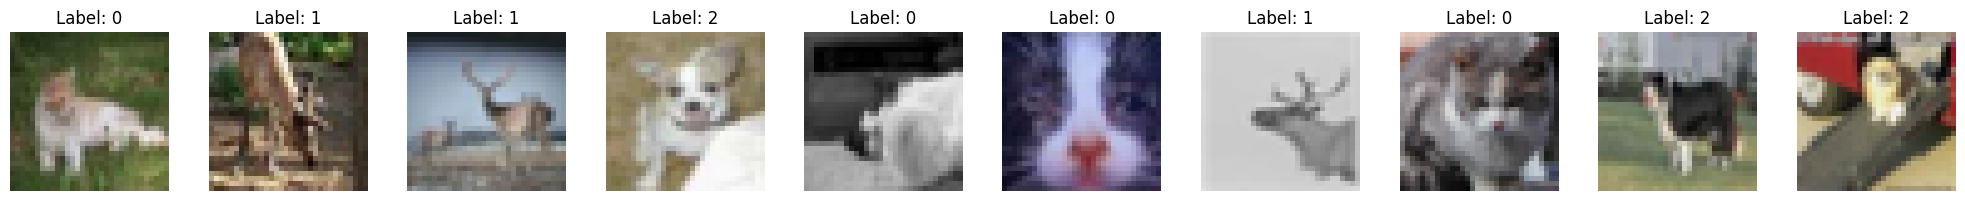

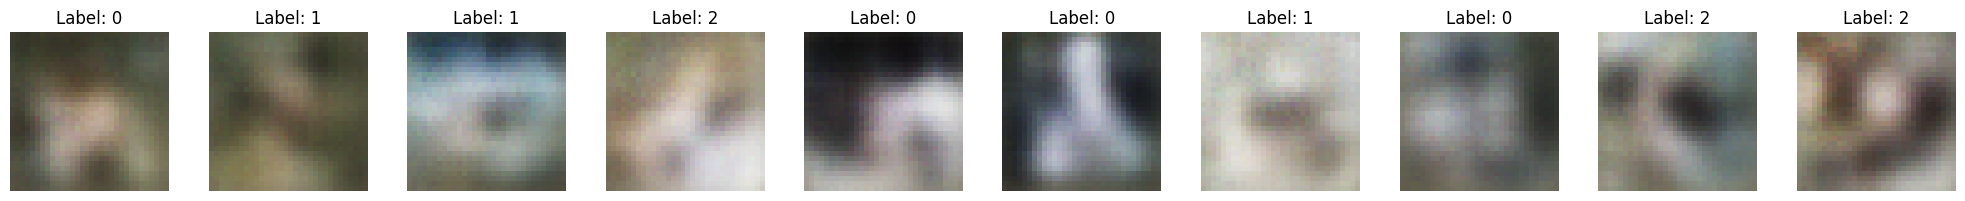

Memory cached in GPU: 0

Training Epoch: [78 | 80] LR: 0.000500
[epoch: 78] (59/59) | Loss: 0.0138 |


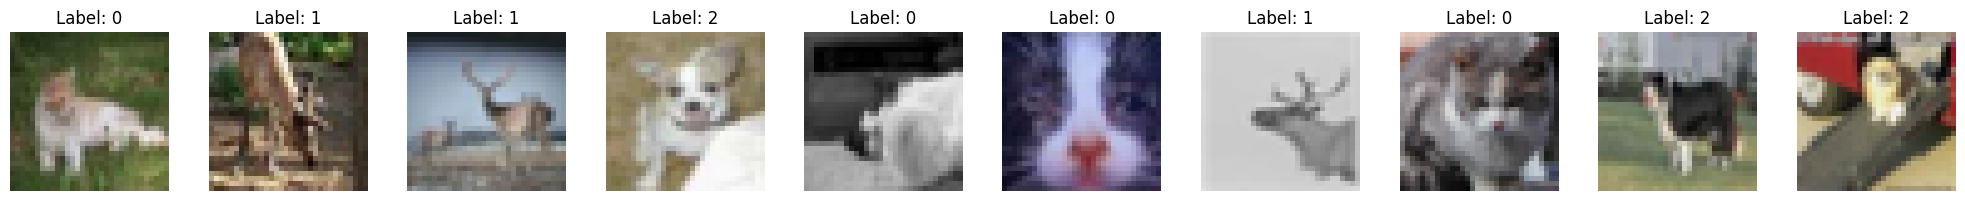

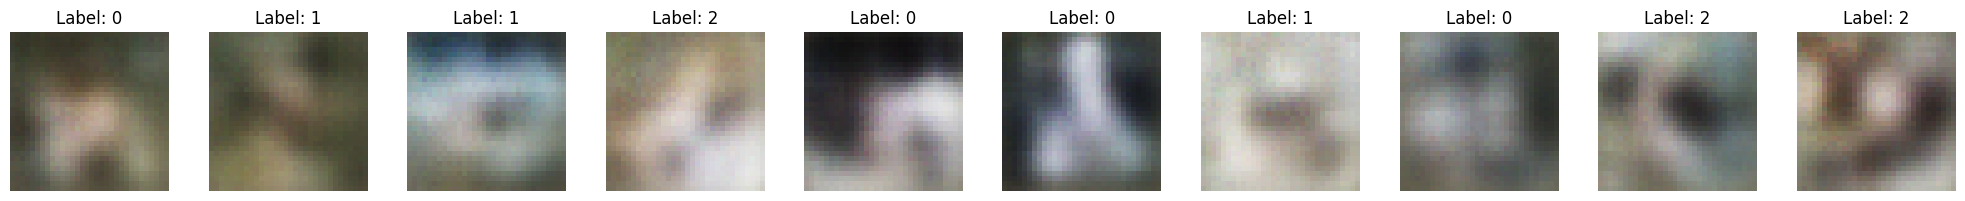

Memory cached in GPU: 0

Training Epoch: [79 | 80] LR: 0.000500
[epoch: 79] (59/59) | Loss: 0.0138 |


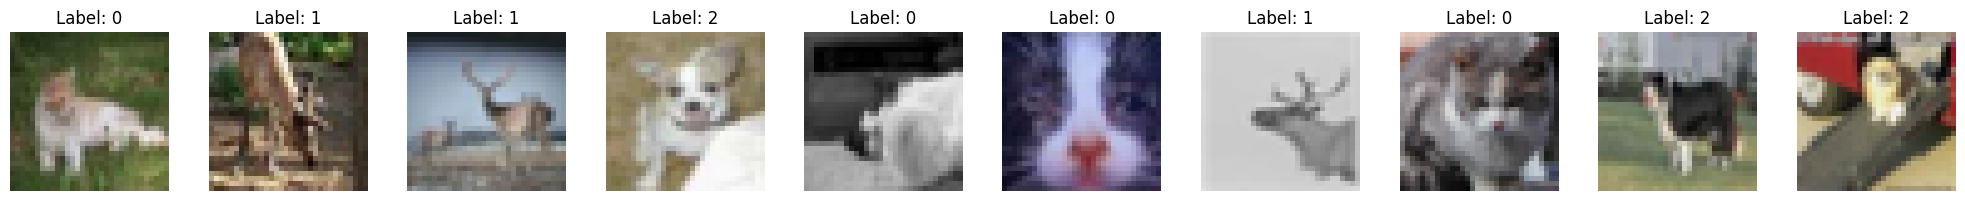

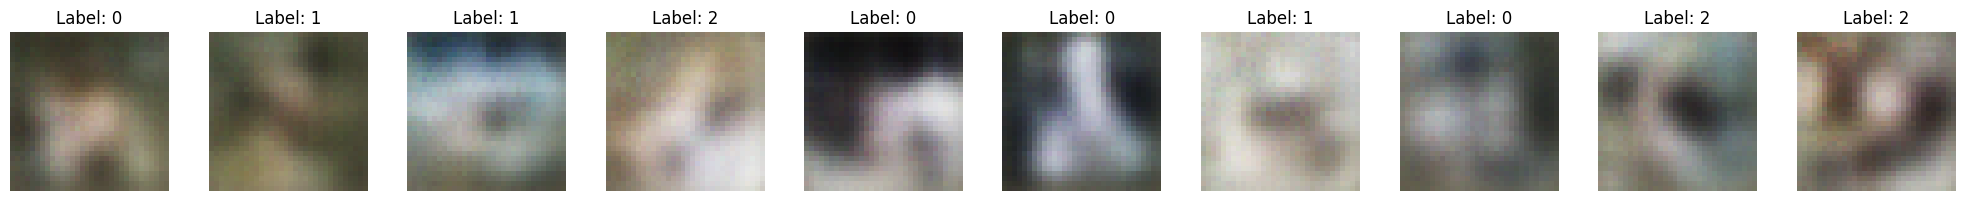

Memory cached in GPU: 0

Training Epoch: [80 | 80] LR: 0.000500
[epoch: 80] (59/59) | Loss: 0.0138 |


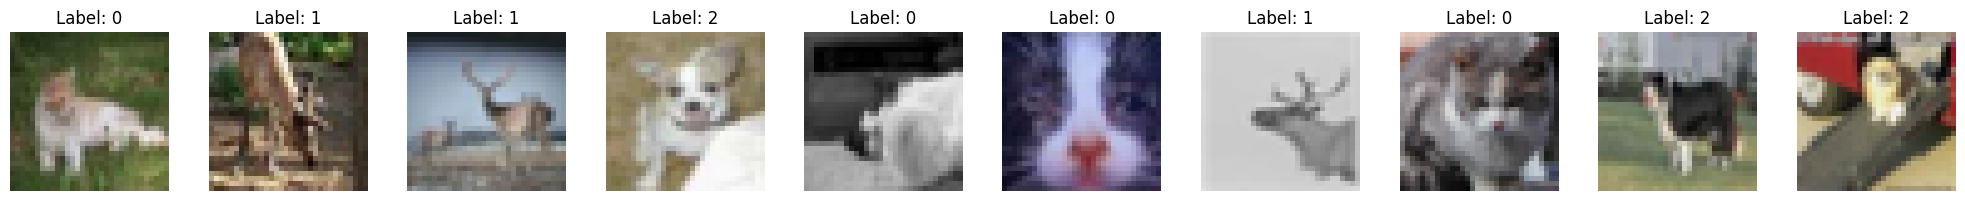

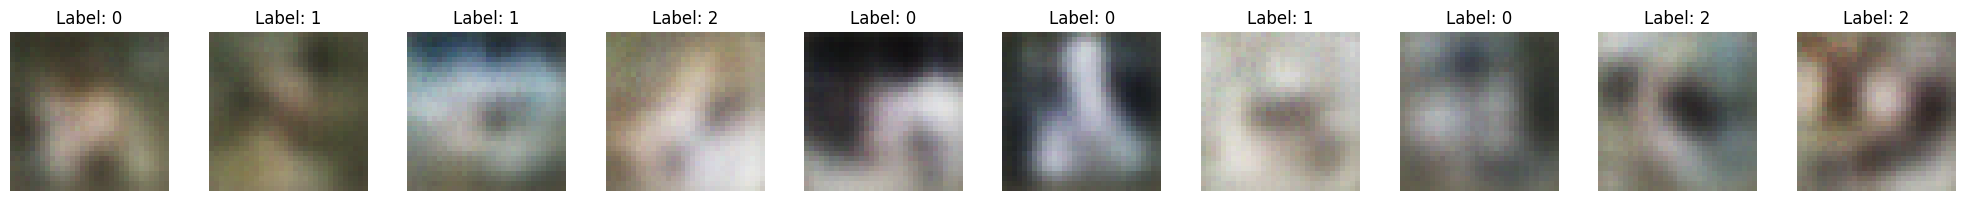

Memory cached in GPU: 0
End time: 2024-06-16 04:09:49
Elapsed time: 10.72 minutes


In [33]:
if TRAIN_AE:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

    print("optimizer: ", args_decoder.optimizer)
    
    AE_train(args_decoder,autoencoder,trainloader,visualize=True)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [34]:
if TRAIN_AE:
    wandb.finish()

## Generate distilled images

In [35]:
if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+args_decoder.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/songze/model_weights/'+args_decoder.uid+"/"
else:
    load_path = "./model_weights/"+args_decoder.uid+"/"

Decoder = Decoder.to(device)

print('--------------------- Evaluating -------------------------------')

### investigate a specific epochs
i = DECODER_STATE_DICT_NUMBER
###

map_location=torch.device(args_encoder.device)
if LOAD_DECODER_STATE_DICT:
    Decoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))

print(H)

with torch.no_grad():
    outputs= Decoder(torch.transpose(H, 0, 1))

print("W is", W)
print("The shape of our weigths in this epochs is ", W.shape)

--------------------- Evaluating -------------------------------
tensor([[ 4.3857, -2.2111, -2.1747],
        [-2.4915,  4.9857, -2.4941],
        [-2.2558, -2.2821,  4.5379],
        ...,
        [-0.2532,  0.3787, -0.1255],
        [-0.0623,  0.3447, -0.2824],
        [-0.0741,  0.0655,  0.0086]], device='cuda:1')
W is Parameter containing:
tensor([[ 0.8165, -0.4082, -0.4082,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4082,  0.8165, -0.4082,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4082, -0.4082,  0.8165,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:1')
The shape of our weigths in this epochs is  torch.Size([3, 512])


In [36]:
def make_prediction(model, image, H = None):
    if H == None:
        with torch.no_grad():
            _, features = model(image)
        H = torch.transpose(features, 0, 1)
    for n, p in model.named_parameters():
            if 'fc.weight' in n:
                W = p
            if 'fc.bias' in n:
                b = p
    W = W.to(device)
    b = b.to(device)

    linear_output = torch.matmul(W, H) + b
    probabilities = torch.nn.functional.softmax(linear_output, dim=-1)
    predicted_labels = torch.argmax(probabilities, dim=-1)
    
    return predicted_labels.tolist()

def find_nearest_neighbor_kdtree(point, points, exclude_self = False, k = 1):
    tree = scipy.spatial.KDTree(points)
    if exclude_self:
        distances, indices = tree.query(point, k=k)  # Find the two nearest neighbors
        print(indices.shape)
        return indices[:,1], distances[:,1]
    else:
        distance, index = tree.query(point, k = k)
    return index, distance

def get_features(args, model, dataloader):
    all_features = []

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(args.device), targets.to(args.device)
    
        with torch.no_grad():
            _, features = model(inputs)
            all_features.append(features.cpu())  # Move features to CPU to avoid memory issues
    
    # Concatenate all features into a single tensor
    all_features = torch.cat(all_features, dim=0)

    return all_features

def get_kNN_images(H, features, trainloader, k = 1):
    m, n = H.shape
    NN1_images = []
    NN1_labels = []
    if k == 2:
        NN2_images = []
        NN2_labels = []
    for i in range(n):
        index, distance = find_nearest_neighbor_kdtree(H[:,i].cpu(), features.cpu(), k = k)
        print(distance)
        print(index)
        if len(index) == len(distance) and k>1:
            for j in range(len(index)):
                image = trainloader.dataset[index[j]][0]
                label = trainloader.dataset[index[j]][1]
                if j % 2 == 0:
                    NN1_images.append(image.cpu())
                    NN1_labels.append(label)
                else:
                    NN2_images.append(image.cpu())
                    NN2_labels.append(label)
        else:
            image = trainloader.dataset[index][0]
            label = trainloader.dataset[index][1]
            NN1_images.append(image.cpu())
            NN1_labels.append(label)

    if k == 1:
        NN1_images = torch.stack(NN1_images, dim=0)
        return NN1_images, NN1_labels
    if k == 2:
        NN1_images = torch.stack(NN1_images, dim=0)
        NN2_images = torch.stack(NN2_images, dim=0)
        return NN1_images, NN2_images, NN1_labels, NN2_labels

In [37]:
features = get_features(args_encoder, Encoder, trainloader)
print(features.shape)
print(H.shape)
NN1_images, NN2_images, NN1_labels, NN2_labels = get_kNN_images(H, features, trainloader, k = 2)

torch.Size([15000, 512])
torch.Size([512, 3])
[9.76054059 9.84930774]
[14954  4728]
[9.55631973 9.77729675]
[ 7107 12156]
[9.46215916 9.52345632]
[6091 8665]


In [38]:
# with torch.no_grad():
#     _, image_feature = Encoder(all_images.to(args_decoder.device))

# index, distance = find_nearest_neighbor_kdtree(image_feature.cpu(), all_features.cpu(), exclude_self=True)
# print(index)

# all_nearest_images = [trainloader.dataset[i][0] for i in index]
# all_nearest_labels = [trainloader.dataset[i][1] for i in index]

# image = trainloader.dataset[index][0]
# label = trainloader.dataset[index][1]
# print(image.shape)
# print(label)
# all_nearest_images.append(image.cpu())
# all_nearest_labels.append(label)

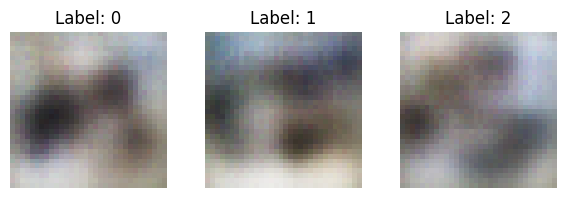

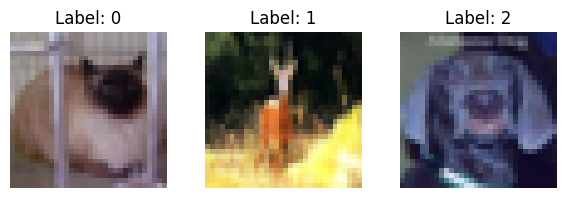

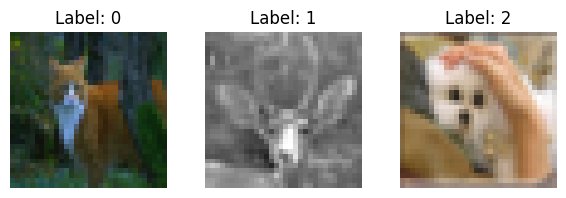

In [39]:
visualize_images(outputs.cpu(), make_prediction(Encoder,outputs.cpu(),H))
visualize_images(NN1_images, NN1_labels)
visualize_images(NN2_images, NN2_labels)
# visualize_images(all_nearest_images, all_nearest_labels)
## To-do list:
## Lexing thinks that the 512 dimension might be too large
## 

In [40]:
make_prediction(Encoder, outputs)

[2, 0, 1]

## Machine Evaluation

In [41]:
_, ETF_feature = Encoder(outputs)
print(H.shape)
NN1_images_loop, NN2_images_loop, NN1_labels_loop, NN2_labels_loop = get_kNN_images(ETF_feature.t(), features, trainloader, k = 2)

torch.Size([512, 3])
[8.77163687 9.00317133]
[2835 9882]
[ 9.61315028 10.6773361 ]
[14897  6750]
[5.17753218 5.32517453]
[2104 4430]


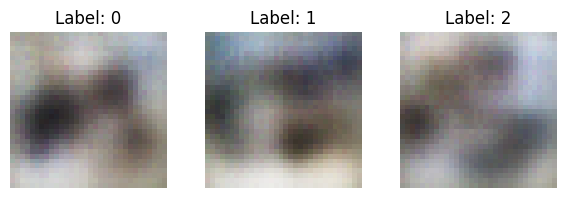

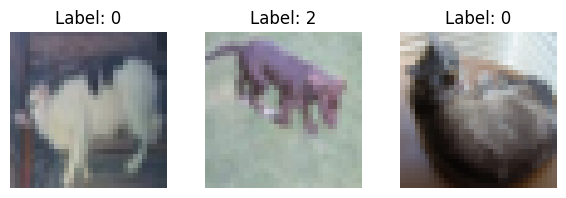

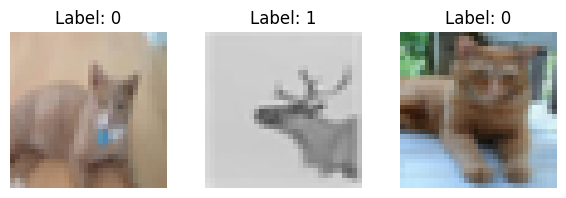

In [42]:
visualize_images(outputs.cpu(), make_prediction(Encoder,outputs.cpu(),H))
visualize_images(NN1_images_loop, NN1_labels_loop)
visualize_images(NN2_images_loop, NN2_labels_loop)
# visualize_images(all_nearest_images, all_nearest_labels)
## To-do list:
## Lexing thinks that the 512 dimension might be too large
## 

In [43]:
make_prediction(Encoder, outputs)

[2, 0, 1]

## Test on image space

In [44]:
def dataset_flattened_to_vector(tensor):
    # Initialize an empty list to collect all data points
    flats = []

    # Iterate over the DataLoader
    for inputs,_ in tensor:
        # Flatten each batch of images
        flattened_inputs = inputs.view(1, -1)
        # Append each batch of flattened inputs to the list
        flats.append(flattened_inputs)

    # Concatenate all collected batches into a single tensor along the batch dimension (dim=0)
    all_data_tensor = torch.cat(flats, dim=0)
    print(all_data_tensor.shape)
    return all_data_tensor

def tensor_flattened_to_vector(tensor):
    # Initialize an empty list to collect all data points
    flats = []

    # Iterate over the DataLoader
    for inputs in tensor:
        # Flatten each batch of images
        flattened_inputs = inputs.view(1, -1)
        # Append each batch of flattened inputs to the list
        flats.append(flattened_inputs)

    # Concatenate all collected batches into a single tensor along the batch dimension (dim=0)
    all_data_tensor = torch.cat(flats, dim=0)

    return all_data_tensor.t()

In [45]:
print(outputs.shape)

torch.Size([3, 3, 32, 32])


In [46]:
flatten_dataset = dataset_flattened_to_vector(trainloader.dataset)
flatten_outputs = tensor_flattened_to_vector(outputs)
NN1_images_auto, NN2_images_auto, NN1_labels_auto, NN2_labels_auto = get_kNN_images(flatten_outputs, flatten_dataset, trainloader, k = 2)

torch.Size([15000, 3072])
[8.03057472 8.13139134]
[ 6045 14459]
[7.36935913 7.91667444]
[   39 13860]
[7.58743184 7.84219622]
[  267 14206]


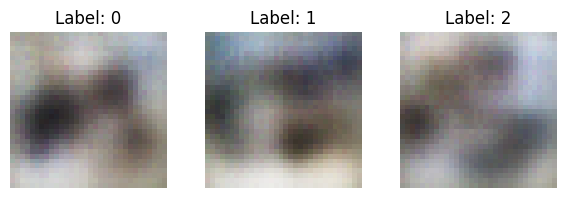

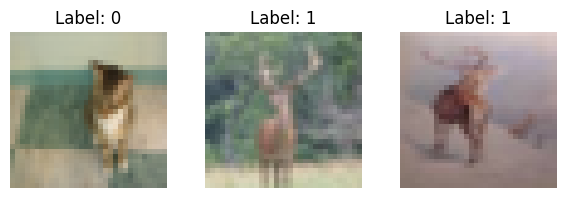

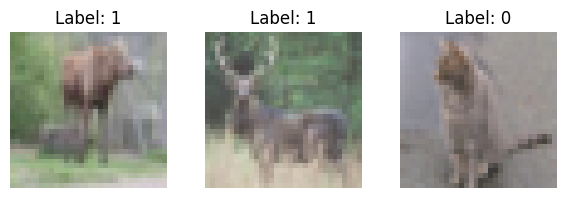

In [47]:
visualize_images(outputs.cpu(), make_prediction(Encoder,outputs.cpu(),H))
visualize_images(NN1_images_auto, NN1_labels_auto)
visualize_images(NN2_images_auto, NN2_labels_auto)
# visualize_images(all_nearest_images, all_nearest_labels)
## To-do list:
## Lexing thinks that the 512 dimension might be too large
## 

In [48]:
make_prediction(Encoder, outputs)

[2, 0, 1]

## Make distilled images

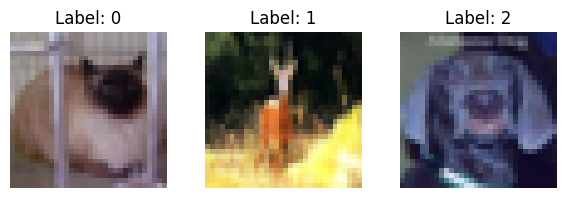

In [49]:
from torch.utils.data import TensorDataset, DataLoader

labels = make_prediction(Encoder,outputs.cpu(),H)
labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
# print((labels.shape))
# print((outputs.shape))
# print((torch.tensor(NN1_labels).shape))
# print((NN1_images.shape))
dataset = TensorDataset(NN1_images, torch.tensor(NN1_labels))
distill_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)
visualize_images(NN1_images, torch.tensor(NN1_labels))

In [50]:
sum(torch.pow(H[:,0].cpu() - (features[43709,:]),2))
print(sum(H[:,9].cpu()>1))
sum(features[43709,:]>1)

IndexError: index 43709 is out of bounds for dimension 0 with size 15000

In [ ]:
features = get_features(args_encoder, Encoder, trainloader)
features
m, n = H.shape
dataset = []
for i in range(n):
    index, distance = find_nearest_neighbor_kdtree(H[:,i].cpu(), features.cpu(), k = 50)
    print(index)
    for j in range(len(index)):
        dataset.append(trainloader.dataset[index[j]])
print(len(dataset))

In [ ]:
distill_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Evaluate model on distilled images

In [ ]:
# # architecture params
# encoder='resnet18'
# bias=True
# ETF_fc=True
# fixdim=0
# SOTA=False

# # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
# width=1024
# depth=6

# # hardware settings
# gpu_id=0
# seed=6
# use_cudnn=True

# # dataset
# dataset='cifar10'
# data_dir='~/data'
# normalize = False
# uid="Resnet18-design(high)-SGD-normalize-on_distill_data"
# force=True

# # learning options
# epochs = 200
# batch_size = 256
# loss = 'CrossEntropy'
# sample_size = None

# # optimization (change for autoencoder)
# lr=0.05
# patience = 40
# history_size=10
# optimizer = "SGD"
# decay_type = "step"

# ## Check the best device on machine
# check = False

In [ ]:
# args_test = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
#                   width=width,depth=depth,
#                   gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
#                   dataset=dataset,data_dir=data_dir,uid=uid,force=force,
#                   epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
#                   lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
#                   device = device)
# args_test.num_classes = num_classes

In [ ]:
# if args_test.model == "MLP":
#     Test_model = models.__dict__[args_test.model](hidden = args_test.width, depth = args_test.depth, fc_bias=args_test.bias, num_classes=num_classes).to(args_test.device)
# elif args_test.model == "ResNet18_adapt":
#     Test_model = ResNet18_adapt(width = args_test.width, num_classes=num_classes, fc_bias=args_test.bias).to(args_test.device)
# else:
#     Test_model = models.__dict__[args_test.model](num_classes=num_classes, fc_bias=args_test.bias, ETF_fc=args_test.ETF_fc, fixdim=args_test.fixdim, SOTA=args_test.SOTA).to(args_test.device)

# print('# of model parameters: ' + str(count_network_parameters(Test_model)))
# print(type(Test_model))

In [ ]:
# config = {
#     # architecture params
#     "model":encoder,
#     "bias": bias,
#     "ETF_fc":ETF_fc,
#     "fixdim":fixdim,
#     "SOTA":SOTA,
    
#     # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
#     "width":width,
#     "depth":depth,
    
#     # hardware settings
#     "gpu_id":gpu_id,
#     "seed":seed,
#     "use_cudnn":use_cudnn,
    
#     # dataset
#     "dataset":dataset,
#     "data_dir":data_dir,
#     "uid":uid,
#     "force":force,
    
#     # learning options
#     "epochs": epochs,
#     "batch_size":batch_size,
#     "loss": loss,
#     "sample_size": sample_size,
    
#     # optimization
#     "lr":lr,
#     "optimizer":optimizer,
#     "decay type": decay_type,
#     "device" :device
# }

# run = wandb.init(
#     project="Test on distilled dataset",
#     notes="Resnet18",
#     tags=["Epochs: 200","Resnet18","SGD","cifar10","SOTA"],
#     config= config
# )

In [ ]:
# del sys.modules["wandb"]

In [ ]:
# # Start timer
# start_time = time.time()
# print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# train(args_test,Test_model,distill_data)

# # End timer
# end_time = time.time()
# print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# elapsed_time_minutes = elapsed_time / 60
# print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [ ]:
# def evaluate_NC(args,load_path,model,trainloader,testloader,nearest_neighbor = False,ontest = False):
    
#     args.load_path = load_path

#     if args.load_path is None:
#         sys.exit('Need to input the path to a pre-trained model!')

#     fc_features = FCFeatures()
#     model.fc.register_forward_pre_hook(fc_features)
#     info_dict = {
#             # 'collapse_metric': [],
#             # 'ETF_metric': [],
#             # 'WH_relation_metric': [],
#             # 'Wh_b_relation_metric': [],
#             # 'W': [],
#             # 'b': [],
#             # 'H': [],
#             # 'mu_G_train': [],
#             # 'mu_G_test': [],
#             'train_acc1': [],
#             'train_acc5': [],
#             'test_acc1': [],
#             'test_acc5': []
#         }

#     print('--------------------- Evaluating -------------------------------')
#     for i in range(190,args.epochs):
        
        
#         map_location=torch.device(args.device)
#         model.load_state_dict(torch.load(args.load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt', 
#                                          map_location=map_location))

#         model.eval()

#         for n, p in model.named_parameters():
#             if 'fc.weight' in n:
#                 W = p
#             if 'fc.bias' in n:
#                 b = p

#         mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, model, fc_features, trainloader, isTrain=True)
#         mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, model, fc_features, testloader, isTrain=False)

#         # Sigma_W = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, trainloader, isTrain=True)
#         # Sigma_W_test_norm = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, testloader, isTrain=False)
#         # Sigma_B = compute_Sigma_B(mu_c_dict_train, mu_G_train)

#         # collapse_metric = np.trace(Sigma_W @ scilin.pinv(Sigma_B)) / len(mu_c_dict_train)
#         # ETF_metric = compute_ETF(W)
#         # WH_relation_metric, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
#         # if ontest:
#         #     _, H_test = compute_W_H_relation(W, mu_c_dict_test, mu_G_test)
#         # if args.bias:
#         #     Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, b)
#         # else:
#         #     Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, torch.zeros((W.shape[0], )))

#         # if nearest_neighbor:
#         #     near_train_acc1, near_train_acc5, avg_distance_train = compute_nearest_neighbor(args, model, fc_features, H, trainloader)
#         #     near_test_acc1, near_test_acc5, avg_distance_test = compute_nearest_neighbor(args, model, fc_features, H, testloader)
#         #     if ontest:
#         #         near_test_acc1_ontest, near_test_acc5_ontest, avg_distance_ontest = compute_nearest_neighbor(args, model, fc_features, H_test, testloader)
        
#         # info_dict['collapse_metric'].append(collapse_metric)
#         # info_dict['ETF_metric'].append(ETF_metric)
#         # info_dict['WH_relation_metric'].append(WH_relation_metric)
#         # info_dict['Wh_b_relation_metric'].append(Wh_b_relation_metric)

#         # info_dict['W'].append((W.detach().cpu().numpy()))
#         # if args.bias:
#         #     info_dict['b'].append(b.detach().cpu().numpy())
#         # info_dict['H'].append(H.detach().cpu().numpy())

#         # info_dict['mu_G_train'].append(mu_G_train.detach().cpu().numpy())
#         # info_dict['mu_G_test'].append(mu_G_test.detach().cpu().numpy())

#         info_dict['train_acc1'].append(train_acc1)
#         info_dict['train_acc5'].append(train_acc5)
#         info_dict['test_acc1'].append(test_acc1)
#         info_dict['test_acc5'].append(test_acc5)


#         # print('[epoch: %d] | collapsemetric: %.4f | ETF metric: %.4f | WH metric: %.4f | Wh_b metric: %.4f ' %
#         #                 (i + 1, collapse_metric, ETF_metric, WH_relation_metric, Wh_b_relation_metric))

#         print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
#                         (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))
#         # if not ontest:
#         #     print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
#         #                     (i + 1, near_train_acc1, near_train_acc5, near_test_acc1, near_test_acc5),"(nearest neighbor accuracy)")
#         # else:
#         #     print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f | Test ETF test top1: %.4f | Test ETF test top5: %.4f ' %
#         #                     (i + 1, near_train_acc1, near_train_acc5, near_test_acc1, near_test_acc5, near_test_acc1_ontest, near_test_acc5_ontest),"(nearest neighbor accuracy)")
        
#         if 'wandb' in sys.modules:
#             if ontest:
#                 wandb.log({
#                             "train_acc1":train_acc1, 
#                             "train_acc5":train_acc5,
#                             "test_acc1":test_acc1,
#                             "test_acc5":test_acc5,
#                             # "collapse_metric":collapse_metric, 
#                             # "ETF_metric":ETF_metric, 
#                             # "WH_relation_metric":WH_relation_metric,
#                             # "Wh_b_relation_metric":Wh_b_relation_metric,
#                             # "nearest neighbor: train_acc1":near_train_acc1, 
#                             # "nearest neighbor: train_acc5":near_train_acc5,
#                             # "nearest neighbor: test_acc1":near_test_acc1,
#                             # "nearest neighbor: test_acc5":near_test_acc5,
#                             # "nearest neighbor (Test ETF): test_acc1":near_test_acc1_ontest,
#                             # "nearest neighbor (Test ETF): test_acc5":near_test_acc5_ontest,
#                             # "nearest neighbor: avg_distance_train":avg_distance_train,
#                             # "nearest neighbor: avg_distance_test":avg_distance_test,
#                             # "nearest neighbor: avg_distance_test":avg_distance_ontest,
#                             })

#             else:
#                 wandb.log({
#                             "train_acc1":train_acc1, 
#                             "train_acc5":train_acc5,
#                             "test_acc1":test_acc1,
#                             "test_acc5":test_acc5,
#                             # "collapse_metric":collapse_metric, 
#                             # "ETF_metric":ETF_metric, 
#                             # "WH_relation_metric":WH_relation_metric,
#                             # "Wh_b_relation_metric":Wh_b_relation_metric,
#                             # "nearest neighbor: train_acc1":near_train_acc1, 
#                             # "nearest neighbor: train_acc5":near_train_acc5,
#                             # "nearest neighbor: test_acc1":near_test_acc1,
#                             # "nearest neighbor: test_acc5":near_test_acc5,
#                             # "nearest neighbor: avg_distance_train":avg_distance_train,
#                             # "nearest neighbor: avg_distance_test":avg_distance_test
#                             })
            
#     with open(args.load_path + 'info.pkl', 'wb') as f:
#         pickle.dump(info_dict, f)

In [ ]:
# # Start timer
# start_time = time.time()
# print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# if 'google.colab' in sys.modules:
#     load_path = "/content/drive/MyDrive/model_weights/"+args_test.uid+"/"
# elif socket.gethostname() == "dijkstra":
#     load_path = '/data5/songze/model_weights/'+args_test.uid+"/"
# else:
#     load_path = "./model_weights/"+args_test.uid+"/"

# evaluate_NC(args_test,load_path,Test_model,trainloader,testloader)

# # End timer
# end_time = time.time()
# print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# elapsed_time_minutes = elapsed_time / 60
# print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")